In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from textblob import TextBlob
import glob
import matplotlib.lines as lines
plt.rcParams['figure.dpi']= 300

# Part 1 (George Fotiadis)

# Racial disparity in police stops and killings

Start by loading the data

In [2]:
df = pd.read_excel("datasets/MPVDatasetDownload.xlsx", sheet_name="2013-2019 Killings by State")

In [3]:
df.head()

State State Abbreviation  Total Population  Black Population  \
0     Alabama                 AL         4864680.0         1285737.0   
1      Alaska                 AK          738516.0           22817.0   
2     Arizona                 AZ         6946685.0          286614.0   
3    Arkansas                 AR         2990671.0          458536.0   
4  California                 CA        39148760.0         2164519.0   

   Hispanic Population  Native American Population  Asian Population  \
0             203146.0                     23243.0           63936.0   
1              51186.0                    103506.0           45617.0   
2            2163312.0                    271946.0          222477.0   
3             219052.0                     17342.0           43441.0   
4           15221577.0                    138427.0         5525439.0   

   Pacific Islander Population  White Population  Other Population  ...  \
0                       1521.0         3196730.0           90367.0  ...   
1                       8544.0          450754.0           56092.0  ...   
2                      12523.0         3825886.0          163927.0  ...   
3                       7877.0         2173849.0           70574.0  ...   
4                     138911.0        14695836.0         1264051.0  ...   

   Rate (Hispanic People)  Rate (Native American People)  Rate (Asian People)  \
0                0.000000                       0.000000             2.234377   
1                2.790942                      16.562187             0.000000   
2                7.594176                       7.354401             0.000000   
3                1.956483                       0.000000             3.288533   
4                4.570580                       7.224024             1.137595   

   Rate (Pacific Islanders)  Rate (White People)  Rate (All People)  \
0                  0.000000             3.306951           4.052535   
1                  0.000000             5.704727           7.737525   
2                  0.000000             5.302227           7.012595   
3                  0.000000             3.942973           4.967829   
4                  9.255669             3.275952           4.302271   

   Disparity in Rate  Black-White Disparity  Hispanic-White Disparity  \
0           1.453111               1.780730                  0.000000   
1           3.236692               4.390041                  0.489233   
2           2.203370               2.914124                  1.432262   
3           1.944122               2.449438                  0.496195   
4           2.868695               3.767425                  1.395191   

   Native American-White Disparity  
0                         0.000000  
1                         2.903239  
2                         1.387040  
3                         0.000000  
4                         2.205168  

[5 rows x 32 columns]

## Disparity in killings

**What is disparity?**

It's easier to explain through an example: Assume 40% of the population are Black and that 45% of the total victims of police violence are Black. In this case the disparity is 5% because there are 5% more victims from what they "should" be according to their population ration.

The dataset we use already had the disparity for black victims so now we're going to calculate the same metric for hispanic and white victims.

First we calculate the percentage of white and hispanic population per state.

In [4]:
df["% Hispanic"] = df["Hispanic Population"] / df["Total Population"] 
df["% White"] = df["White Population"] / df["Total Population"] 

In [5]:
df_perce = df[["State Abbreviation", "% African-American", "% Hispanic", "% White"]]

In [6]:
df_perce = df_perce.rename(columns={"State Abbreviation" : "State", "% African-American": "Black", "% Hispanic": "Hispanic", "% White": "White"})

In [7]:
df_perce["black_disparity"] = df["Disparity"].iloc[:]

Now let's find how many people died of each race and the total number of victims per state

In [8]:
df_perce["total_victims"] = df["# People Killed"]

In [9]:
df_perce["white_victims"] = df["# White people killed"]
df_perce["hispanic_victims"] = df["# Hispanic people killed"]

In [10]:
df_perce = df_perce.iloc[:51] # drop trailing nans

In [11]:
df_perce.fillna(0, inplace=True)

Now we calculate the percentage of victims of each race by dividing the number of victims of that race by the total number of victims

In [12]:
df_perce["white_victims"] = df_perce["white_victims"] / df_perce["total_victims"]
df_perce["hispanic_victims"] = df_perce["hispanic_victims"] / df_perce["total_victims"]

And finally we calculate the disparity for white and hispanic people

In [13]:
df_perce["white_disparity"] = df_perce["white_victims"] - df_perce["White"]
df_perce["hispanic_disparity"] = df_perce["hispanic_victims"] - df_perce["Hispanic"]

In [14]:
disparities = df_perce.drop(["total_victims", "white_victims", "hispanic_victims"], axis = 1).iloc[:]

In [15]:
disparities.head()

State     Black  Hispanic     White  black_disparity  white_disparity  \
0    AL  0.264300  0.041759  0.657131         0.119758        -0.120899   
1    AK  0.030896  0.069309  0.610351         0.069104        -0.160351   
2    AZ  0.041259  0.311416  0.550750         0.049650        -0.134328   
3    AR  0.153322  0.073245  0.726877         0.144755        -0.149954   
4    CA  0.055290  0.388814  0.375384         0.103319        -0.089549   

   hispanic_disparity  
0           -0.041759  
1           -0.044309  
2            0.025827  
3           -0.044399  
4            0.024248

In [16]:
disparities_no_stops = disparities.iloc[:]

## Disparity in stops

Now let's calculate the disparity per race and per state for police stops!

In [19]:
stops = pd.read_csv("./datasets/opp-stops_state.csv")

In [20]:
stops.head()

state       city geography    subgeography subject_race  search_rate  \
0    AZ  Statewide        AZ   Apache County        white          NaN   
1    AZ  Statewide        AZ   Apache County        black          NaN   
2    AZ  Statewide        AZ   Apache County     hispanic          NaN   
3    AZ  Statewide        AZ  Cochise County        white          NaN   
4    AZ  Statewide        AZ  Cochise County        black          NaN   

   stop_rate  hit_rate  inferred_threshold  stops_per_year    stop_rate_n  
0   0.077444       NaN                 NaN     7064.888889  293234.024096  
1   0.115928       NaN                 NaN      385.246753   32012.963855  
2   0.065497       NaN                 NaN     1280.962025  137774.746988  
3   0.077444       NaN                 NaN    12371.855422  293234.024096  
4   0.115928       NaN                 NaN     1568.810127   32012.963855

We will reuse the demographics we calculated before

In [21]:
disparities_stops = disparities.drop(["black_disparity", "white_disparity", "hispanic_disparity"], axis = 1)

First we'll create 3 dataframes (one for each race) that contain the state and number of victims

In [22]:
stops_perce = {}
for state in set(stops["state"]):
    for race in set(["black", "white", "hispanic"]):
        stops_perce[(state, race)] =  stops.groupby(["state", "subject_race"]).get_group((state, race))["stops_per_year"].sum() / stops.groupby(["state"]).get_group((state))["stops_per_year"].sum()

In [23]:
black_disp = {}
white_disp = {}
hispanic_disp = {}

for state in set(stops["state"]):
    black_disp[state] = stops_perce[(state, "black")]
    white_disp[state] = stops_perce[(state, "white")]
    hispanic_disp[state] = stops_perce[(state, "hispanic")]

In [24]:
black_stops = pd.DataFrame(black_disp.items(), columns=["State", "black_stop_perce"])
white_stops = pd.DataFrame(white_disp.items(), columns=["State", "white_stop_perce"])
hispanic_stops = pd.DataFrame(hispanic_disp.items(), columns=["State", "hispanic_stop_perce"])

Now we merge all these dataframes with the original one

In [25]:
disparities_stops = disparities_stops.merge(black_stops, on = "State").merge(white_stops, on = "State").merge(hispanic_stops, on = "State")

In [26]:
disparities_stops.head()

State     Black  Hispanic     White  black_stop_perce  white_stop_perce  \
0    AZ  0.041259  0.311416  0.550750          0.069454          0.631994   
1    CA  0.055290  0.388814  0.375384          0.097157          0.510918   
2    CO  0.039184  0.214204  0.683080          0.034681          0.819285   
3    CT  0.098232  0.156859  0.675330          0.124470          0.770029   
4    FL  0.153752  0.251708  0.543586          0.202367          0.581038   

   hispanic_stop_perce  
0             0.298552  
1             0.391925  
2             0.146034  
3             0.105501  
4             0.216595

Then we calculate the disparity in stops

In [27]:
disparities_stops["black_disparity_stops"] = disparities_stops["black_stop_perce"] - disparities_stops["Black"]
disparities_stops["white_disparity_stops"] = disparities_stops["white_stop_perce"] - disparities_stops["White"]
disparities_stops["hispanic_disparity_stops"] = disparities_stops["hispanic_stop_perce"] - disparities_stops["Hispanic"]

In [28]:
disparities_stops = disparities_stops.drop(["black_stop_perce", "white_stop_perce", "hispanic_stop_perce"], axis = 1)

In [29]:
disparities_stops.head()

State     Black  Hispanic     White  black_disparity_stops  \
0    AZ  0.041259  0.311416  0.550750               0.028195   
1    CA  0.055290  0.388814  0.375384               0.041867   
2    CO  0.039184  0.214204  0.683080              -0.004503   
3    CT  0.098232  0.156859  0.675330               0.026238   
4    FL  0.153752  0.251708  0.543586               0.048615   

   white_disparity_stops  hispanic_disparity_stops  
0               0.081244                 -0.012865  
1               0.135534                  0.003112  
2               0.136205                 -0.068170  
3               0.094699                 -0.051358  
4               0.037452                 -0.035113

And finally we merge with the disparity for killings dataframe using an inner join.

In [30]:
disparities = disparities.merge(disparities_stops, on = ["State", "Black", "Hispanic", "White"])

In [31]:
disparities.head()

State     Black  Hispanic     White  black_disparity  white_disparity  \
0    AZ  0.041259  0.311416  0.550750         0.049650        -0.134328   
1    CA  0.055290  0.388814  0.375384         0.103319        -0.089549   
2    CO  0.039184  0.214204  0.683080         0.057732        -0.229336   
3    CT  0.098232  0.156859  0.675330         0.096213        -0.147552   
4    FL  0.153752  0.251708  0.543586         0.159791        -0.090896   

   hispanic_disparity  black_disparity_stops  white_disparity_stops  \
0            0.025827               0.028195               0.081244   
1            0.024248               0.041867               0.135534   
2            0.094166              -0.004503               0.136205   
3            0.009808               0.026238               0.094699   
4           -0.110706               0.048615               0.037452   

   hispanic_disparity_stops  
0                 -0.012865  
1                  0.003112  
2                 -0.068170  
3                 -0.051358  
4                 -0.035113

Now we will plot the distribution of police stops and killings accros all states per race

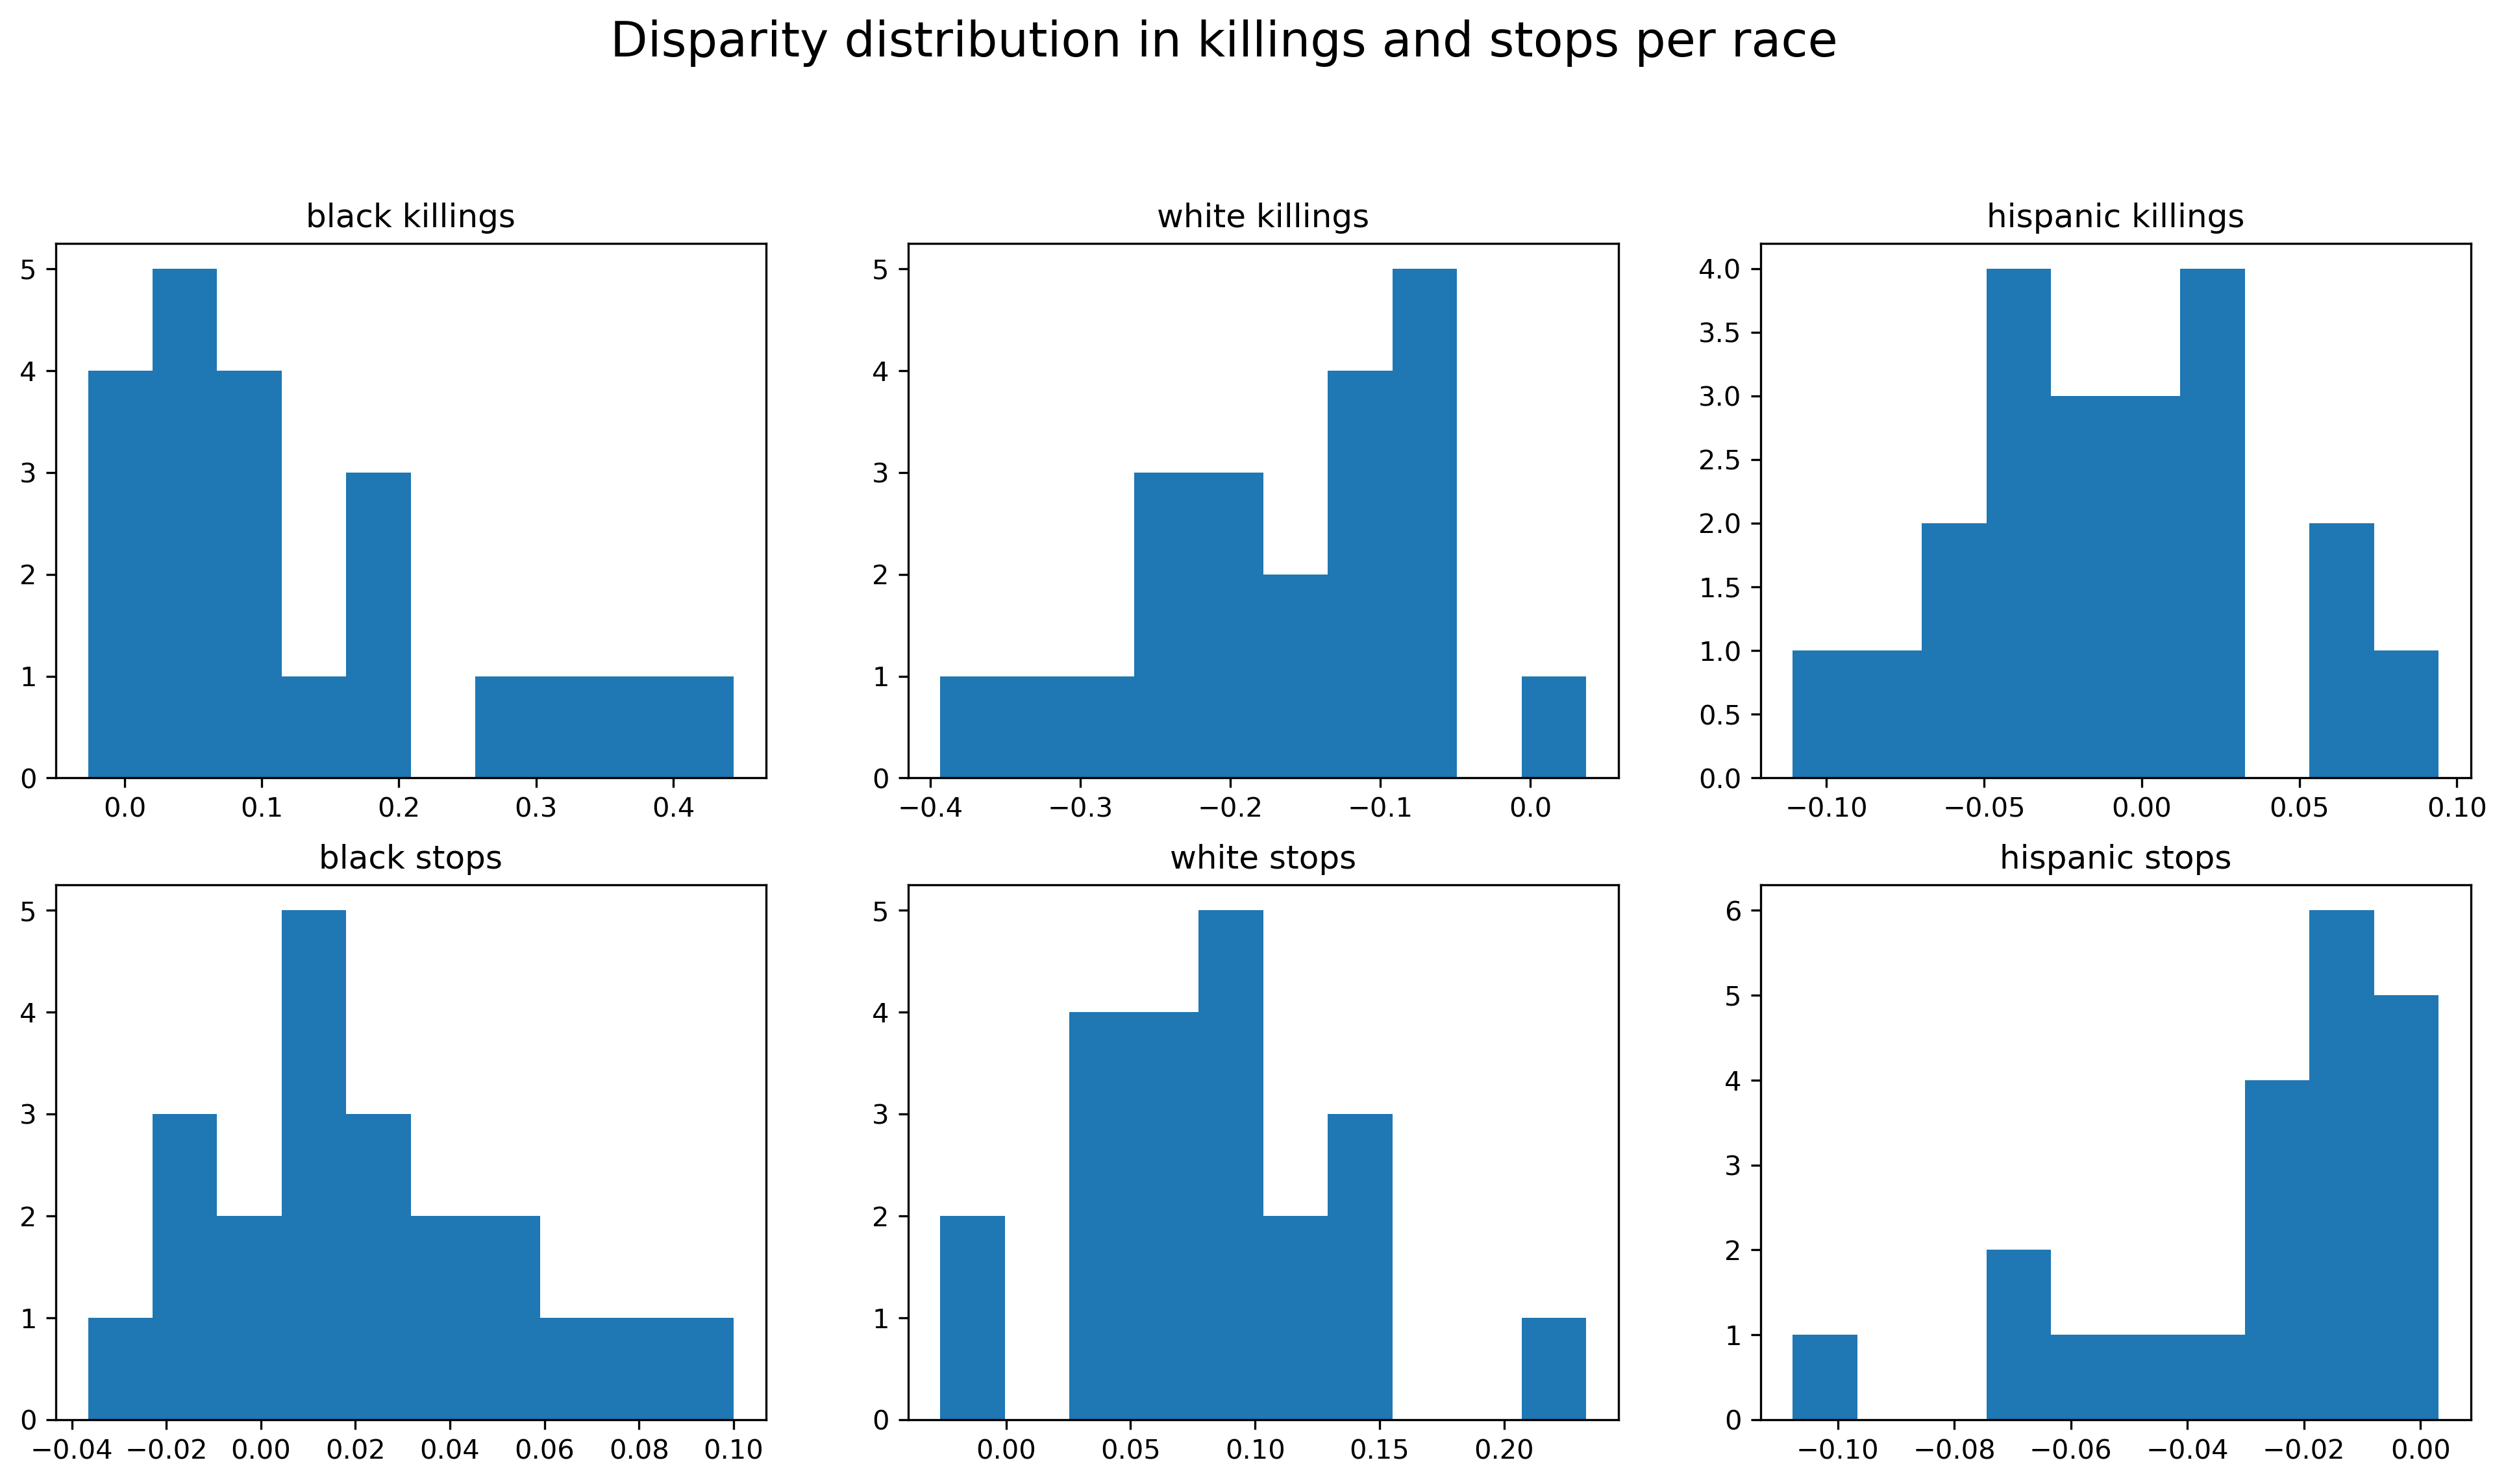

In [32]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 8)
axs[0][0].set_title("black killings")
axs[1][0].set_title("black stops")
axs[0][0].hist(disparities["black_disparity"])
axs[1][0].hist(disparities["black_disparity_stops"])

axs[0][1].set_title("white killings")
axs[1][1].set_title("white stops")
axs[0][1].hist(disparities["white_disparity"])
axs[1][1].hist(disparities["white_disparity_stops"])

axs[0][2].set_title("hispanic killings")
axs[1][2].set_title("hispanic stops")
axs[0][2].hist(disparities["hispanic_disparity"])
axs[1][2].hist(disparities["hispanic_disparity_stops"])
#fig.text(0.5, 0.01, "Disparity", ha='center', fontsize = 18)
fig.text(0.5, 1, "Disparity distribution in killings and stops per race", ha='center', fontsize = 18)
plt.savefig("./images/disparity_dist.png", bbox_inches='tight')

### Observations

From this plot we can extract some interesting obervations:
- When it comes to killings, the disparity for white people is almost always negative but when it comes to police stops it's almost always positive. A reason for that could be that police men don't hesitate to stop white people but their are skeptical when using violence against them.

- When it comes to black stops we see that disparity levels are heavily centered around zero with a very small standard deviation (compared to killings for example). This means that, in these states, there is no tendency of the police stopping disproportionally more black people.

- For Hispanics, we see that both for killings and stops, their disparity levels are very close to zero meaning that there is no strong indication of bias against this racial groups in this case.

## Disparity per year and state

Now let's give a time aspect to our study. Specifically, we're going to examine how disparities change per state through the years

In [36]:
def get_df_for_year(states, year):
    """
    Reads the data and restricts it to the states that we want to explore and the year
    """
    df = pd.read_excel("datasets/MPVDatasetDownload.xlsx", sheet_name="2013-2020 Police Killings")
    df = df[["Victim's race", "Date of Incident (month/day/year)", "State"] ]
    df.columns = ["race", "date", "state"]
    
    df["race"] = df.race.apply(lambda x: "Unknown" if x == "Unknown race" or x == "Unknown Race" or x == "unknown race" else x).iloc[:]
    df.fillna("Unknown", inplace=True)
    
    df = df[(df["race"] == "White") | (df["race"] == "Black") | (df["race"] == "Hispanic")].reset_index(drop = True).iloc[:] # only keep the races we care about
    df = df[(df["date"] >= f"{year}-01-01") & (df["date"] <= f"{year}-12-31")].reset_index(drop = True) # restrict to one year
    
    #Probably not the best way to create the dataframe but it works
    d = {}
    for state in states:
        l = []
        for race in ["Black", "White", "Hispanic"]:
            by_state = df.groupby("state")
            if state in by_state.groups:
                grouped = by_state.get_group(state).groupby("race")
                if race in grouped.groups:
                    l.append(grouped.get_group(race).size / 3)
                else:
                    l.append(0)
            else:
                l = [0, 0, 0]
        d[state] = l
    df = pd.DataFrame.from_dict(d).transpose().reset_index()
    
    # Normalize victim rates
    df.columns = ["state", "Black", "White", "Hispanic"]
    df["total"] = df["Black"] + df["White"] + df["Hispanic"]
    df["White"] = df["White"] / df["total"] 
    df["Black"] = df["Black"] / df["total"] 
    df["Hispanic"] = df["Hispanic"] / df["total"]
    df.fillna(0, inplace=True) # in case total victims were 0
    return df

In [37]:
def get_disparities_for_year(df, year):
    """
    Gets a Dataframe with demographics and calculates the number of victims and the disparity for each race for a specific year
    """
    df_year = get_df_for_year(set(df.State), year)
    df_year.rename(columns={"state" : "State"}, inplace=True)
    
    df_year = df_year[["State", "Black", "Hispanic", "White"]]
    df = df.merge(df_year, on="State",suffixes=("", "_victims"))
    
    df["black_disparity"] = df["Black_victims"] - df["Black"]
    df["white_disparity"] = df["White_victims"] - df["White"]
    df["hispanic_disparity"] = df["Hispanic_victims"] - df["Hispanic"]
    
    return df

In [38]:
get_disparities_for_year(disparities[["State", "Black", "Hispanic", "White"]], 2014).head()

State     Black  Hispanic     White  Black_victims  Hispanic_victims  \
0    AZ  0.041259  0.311416  0.550750       0.121951          0.439024   
1    CA  0.055290  0.388814  0.375384       0.160839          0.503497   
2    CO  0.039184  0.214204  0.683080       0.090909          0.545455   
3    CT  0.098232  0.156859  0.675330       0.500000          0.500000   
4    FL  0.153752  0.251708  0.543586       0.365854          0.121951   

   White_victims  black_disparity  white_disparity  hispanic_disparity  
0       0.439024         0.080692        -0.111725            0.127608  
1       0.335664         0.105550        -0.039720            0.114683  
2       0.363636         0.051725        -0.319444            0.331250  
3       0.000000         0.401768        -0.675330            0.343141  
4       0.512195         0.212101        -0.031391           -0.129757

In [42]:
def get_disparities_for_state(df, state):
    "Calculates and plots how the disparities change for a specific state throughout the years"
    l = []
    df = df[df["State"] == state]
    for year in range(2013, 2021):
        temp = get_disparities_for_year(df, year)
        l.append(temp[temp["State"] == state])
    df = pd.concat(l, axis = 0).drop(["State"], axis = 1).reset_index(drop = True)
    years = pd.DataFrame(list(range(2013, 2021)), columns=['year'])
    df = pd.concat([df, years], axis = 1)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)

    df.plot(x = "year", y = "black_disparity", ax = ax, color = "black")
    df.plot(x = "year", y = "white_disparity", ax = ax, color = "blue")
    df.plot(x = "year", y = "hispanic_disparity", ax = ax, color = "red")
    
    ax.axhline(y = 0, color = "red", linestyle = "--")

    ax.set_ylabel("Disparities")
    ax.set_title(f"Disparities for {state} for 2013-2020")
    plt.savefig(f"./images/{state}_disp.png", bbox_inches='tight')
    return df

First we plot the disparity for the 3 states with the strongest gun laws: California, New Jersey and Connecticut

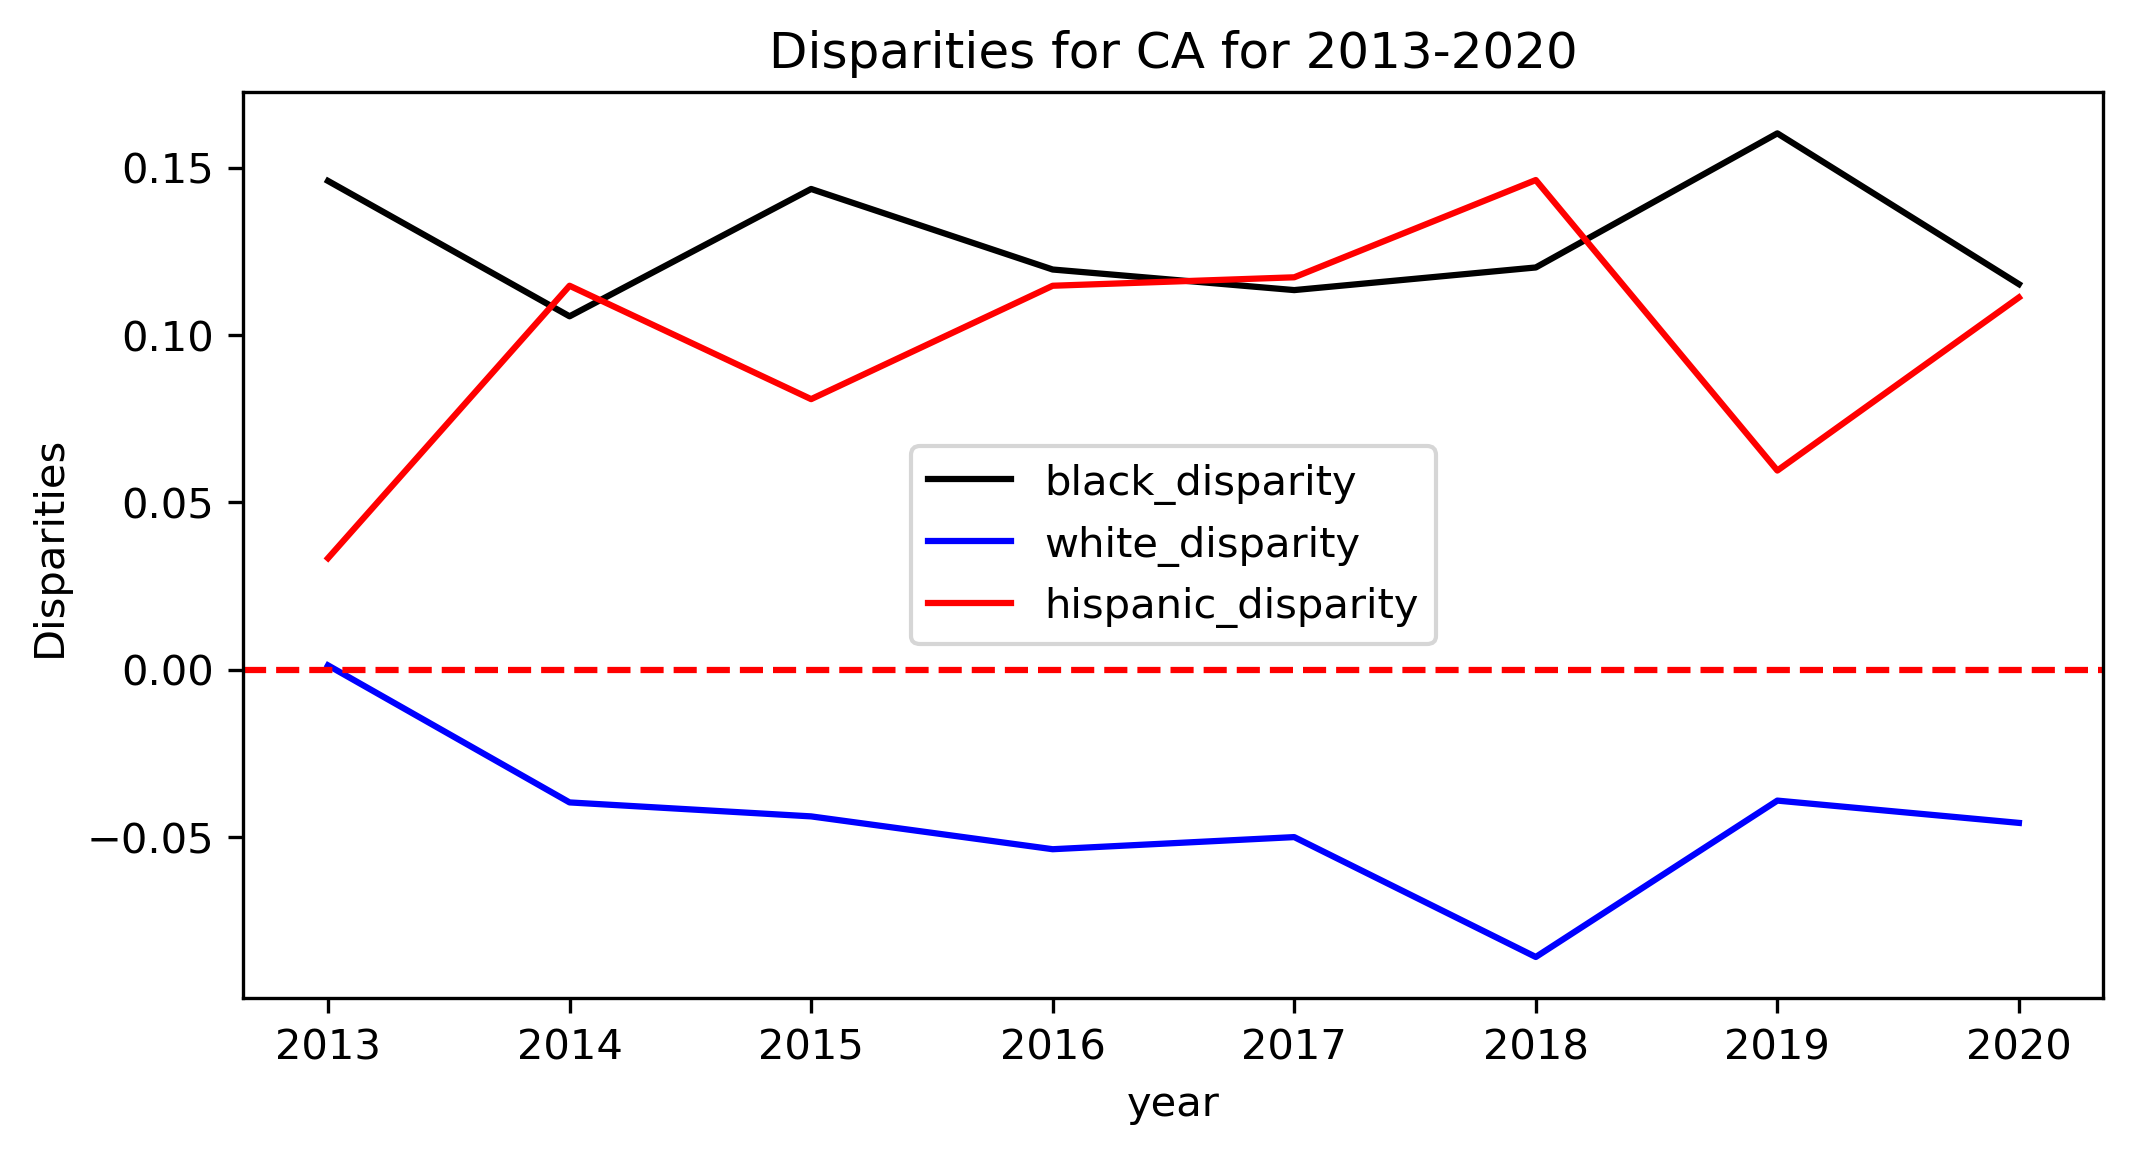

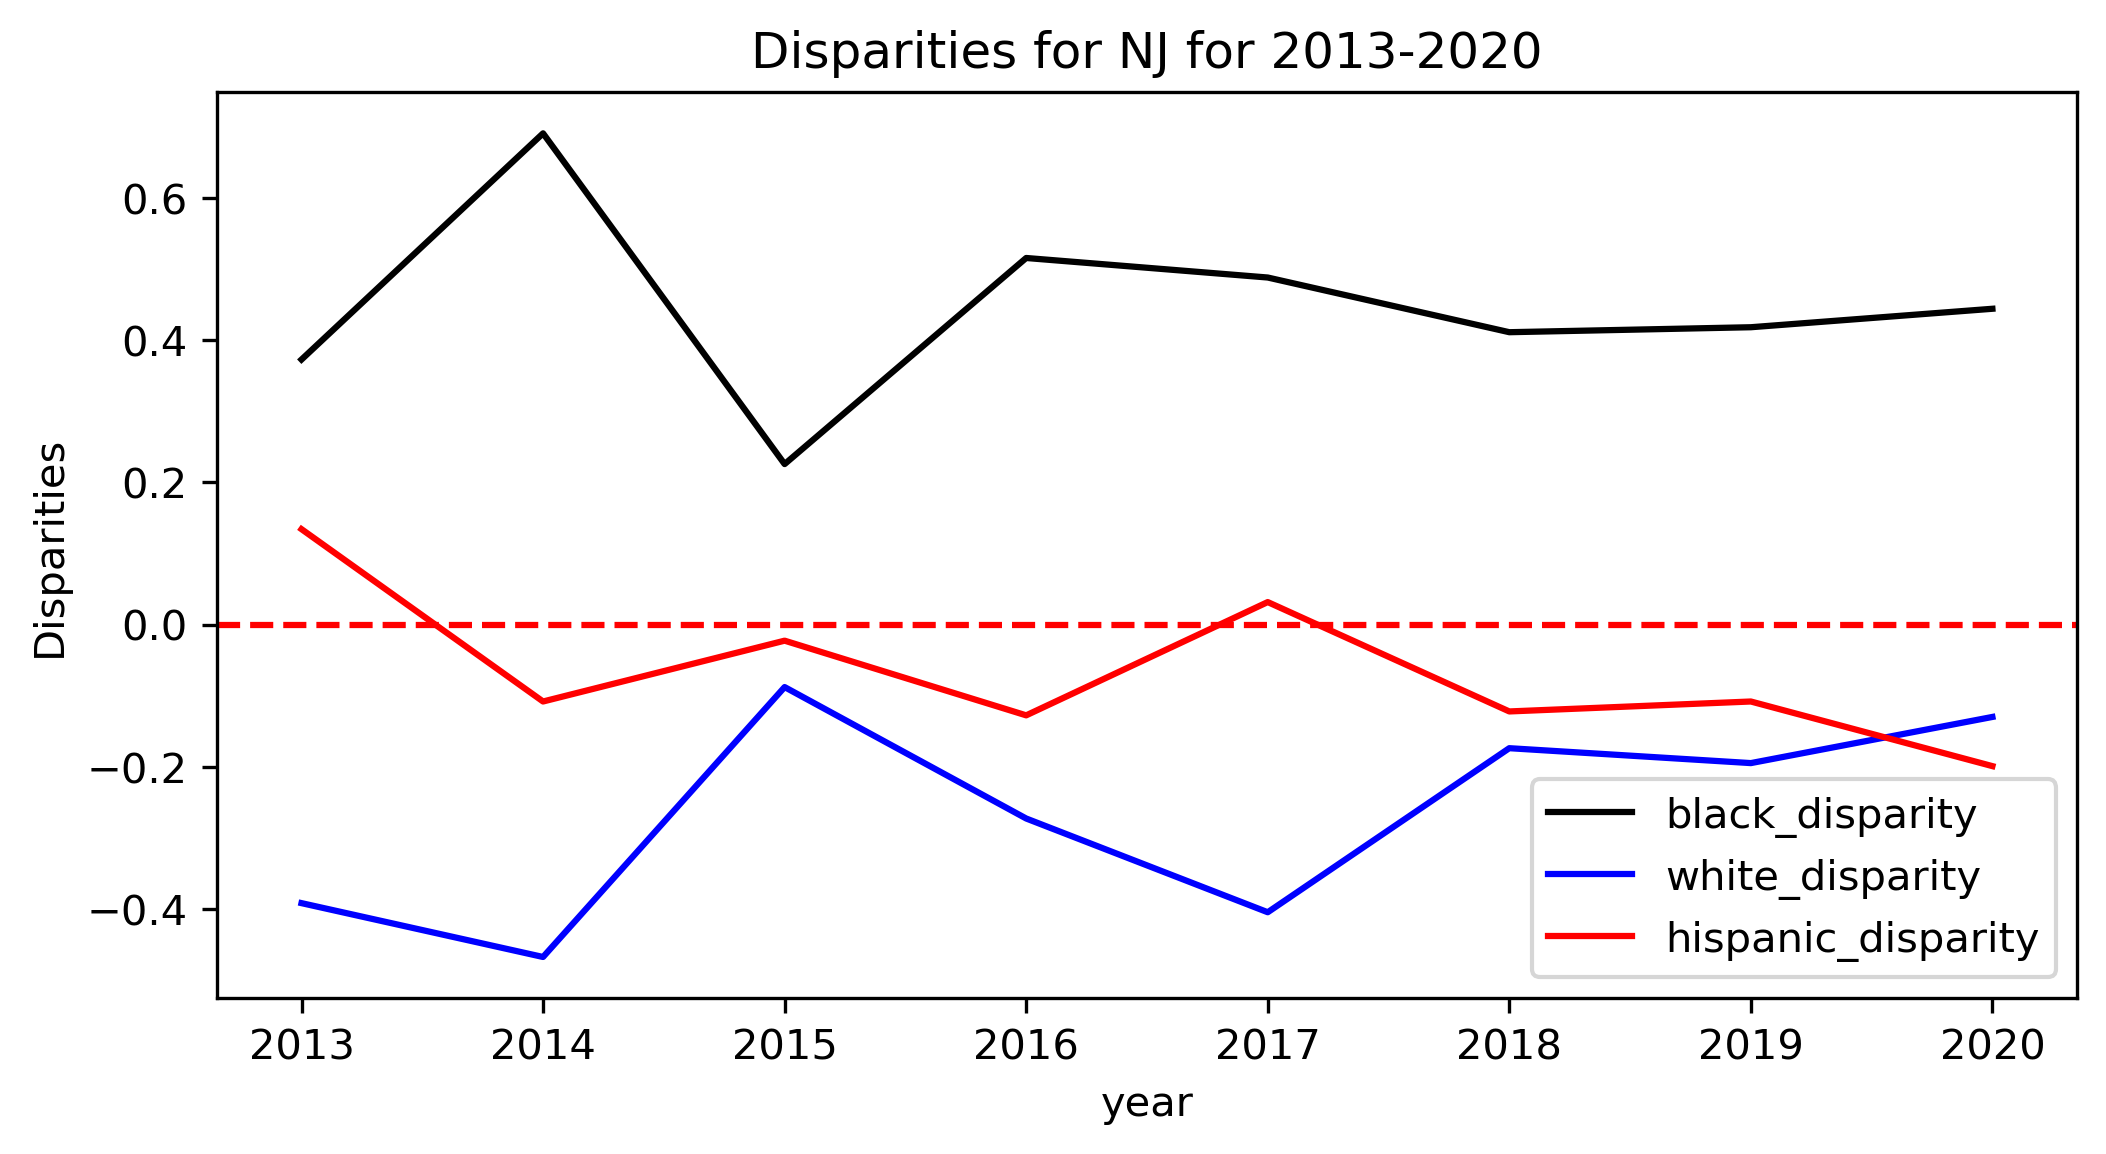

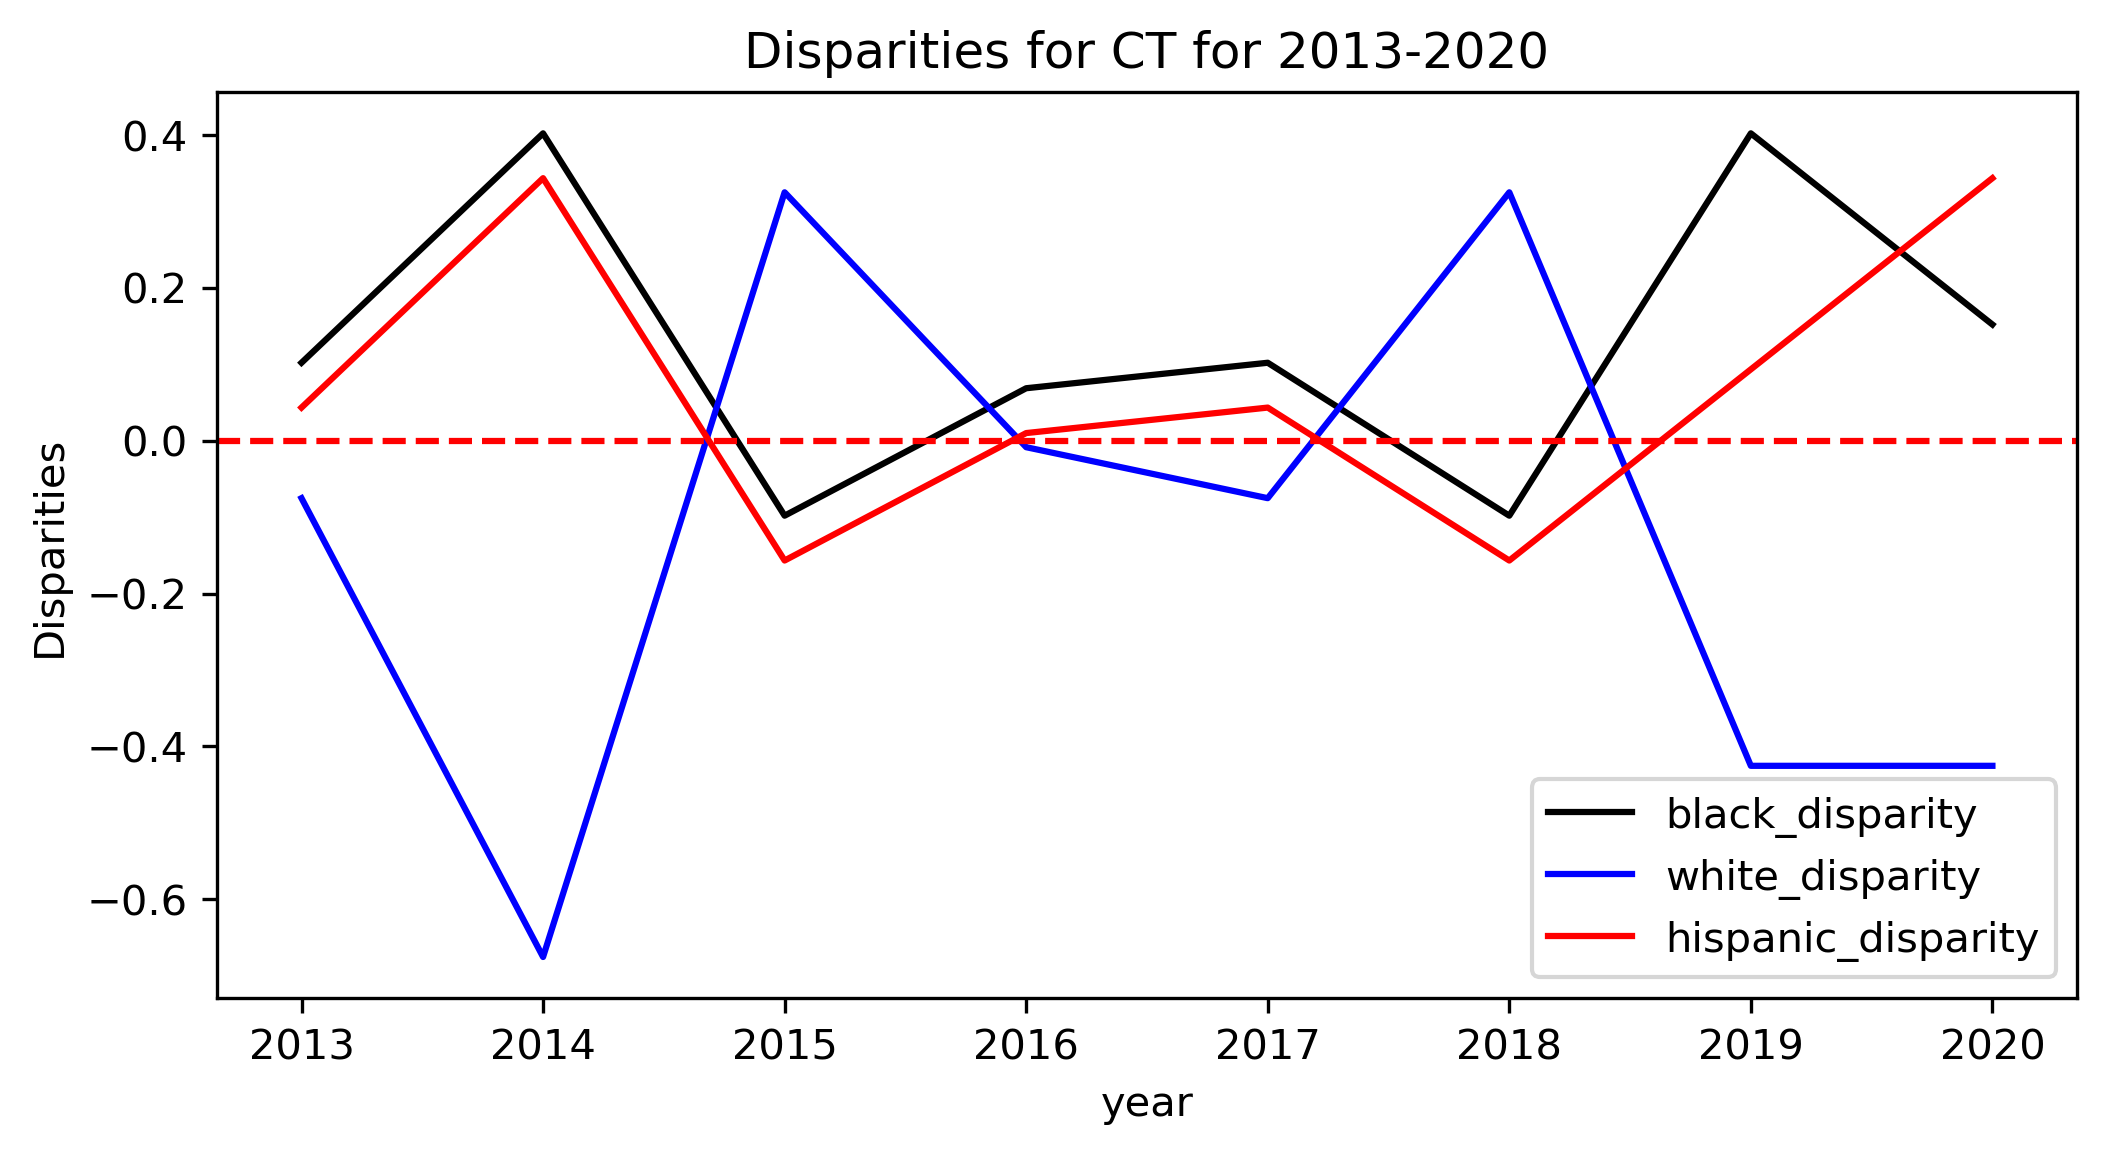

In [44]:
df = get_disparities_for_state(disparities_no_stops[["State", "Black", "Hispanic", "White"]], "CA")
df = get_disparities_for_state(disparities_no_stops[["State", "Black", "Hispanic", "White"]], "NJ")
df = get_disparities_for_state(disparities_no_stops[["State", "Black", "Hispanic", "White"]], "CT")

Then we plot the disparity for the 3 states with the weakest gun laws: Mississipi, Wyoming and Idaho

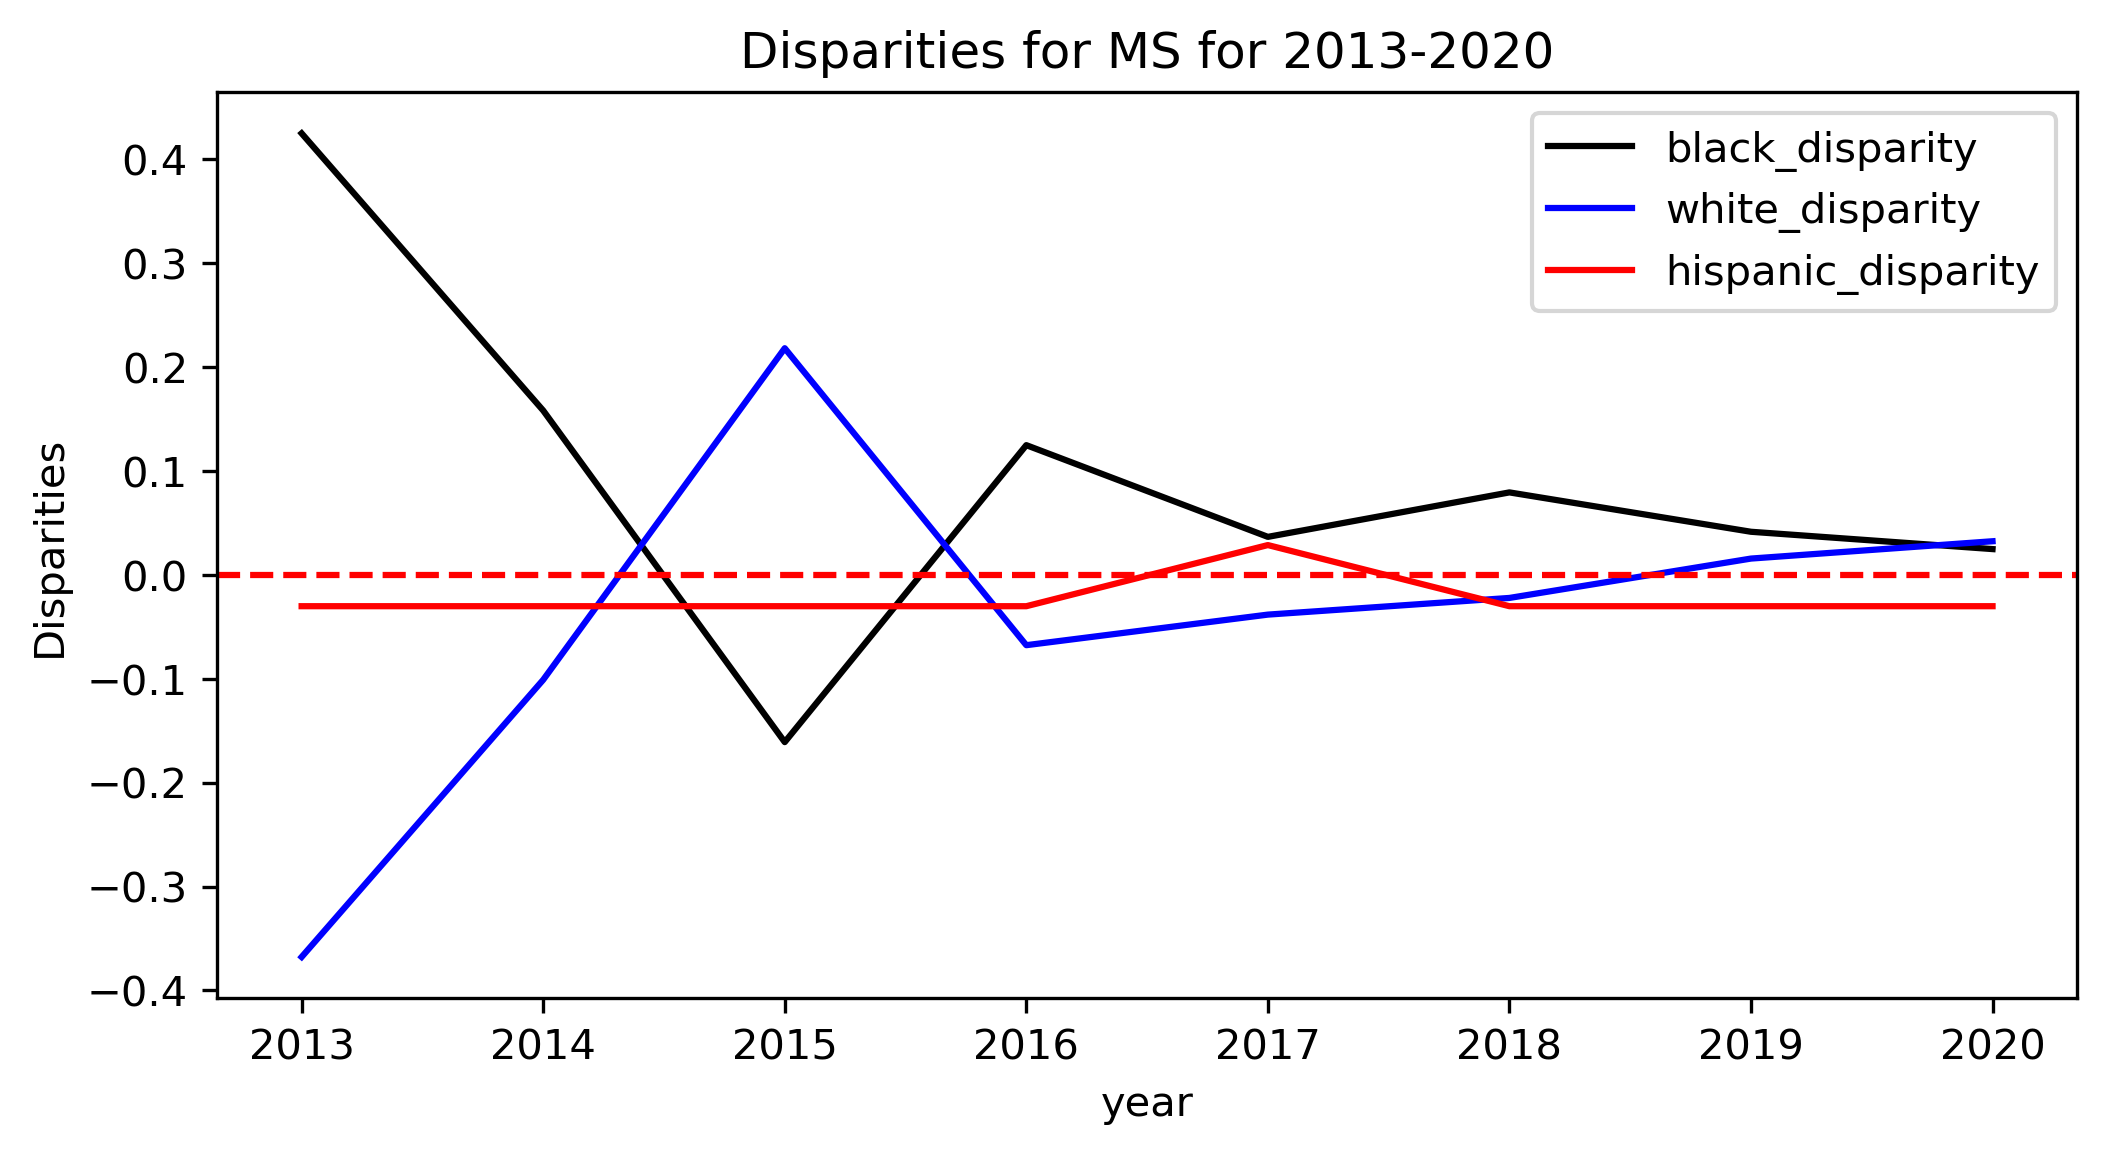

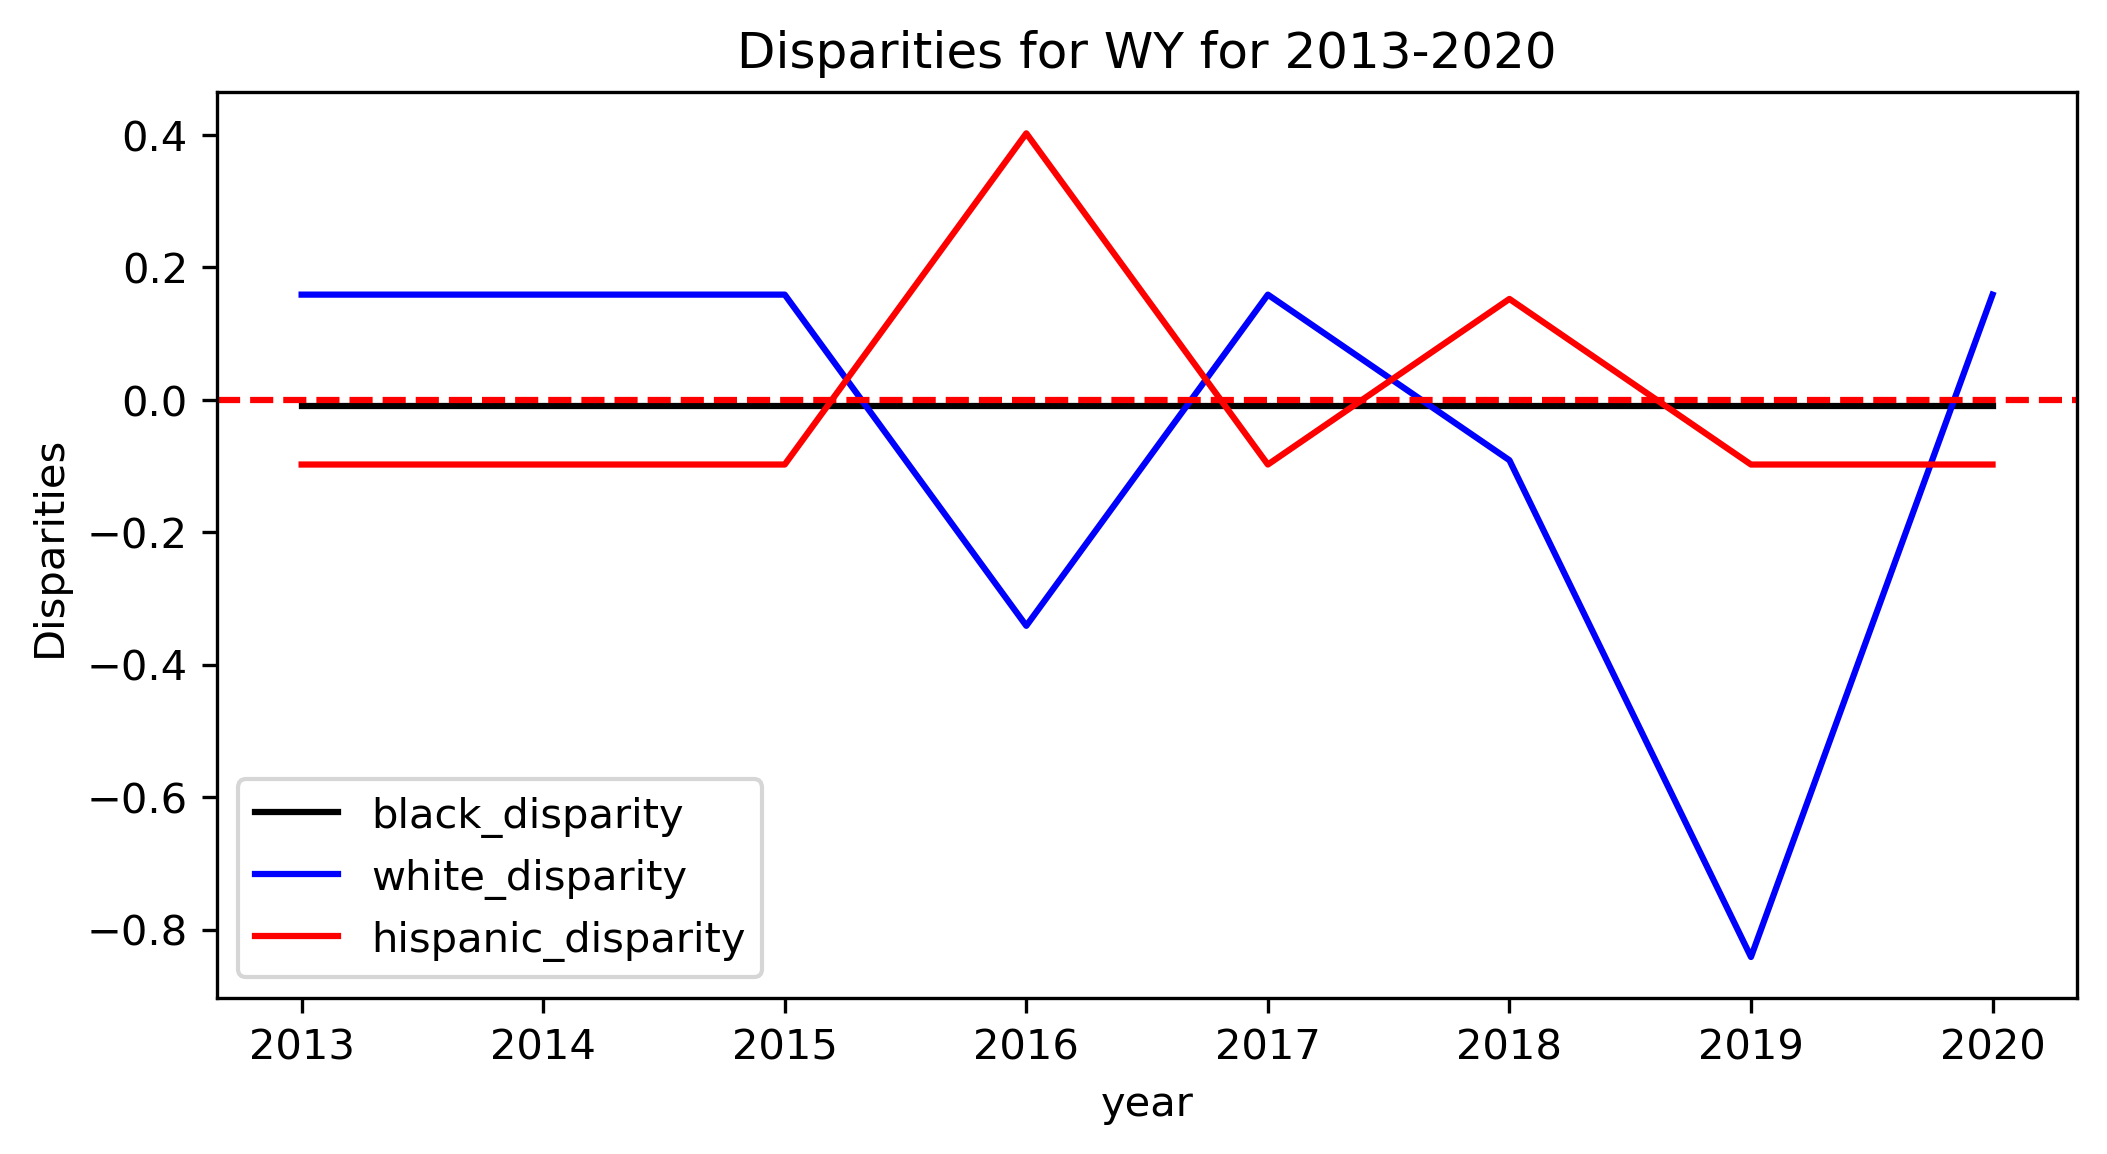

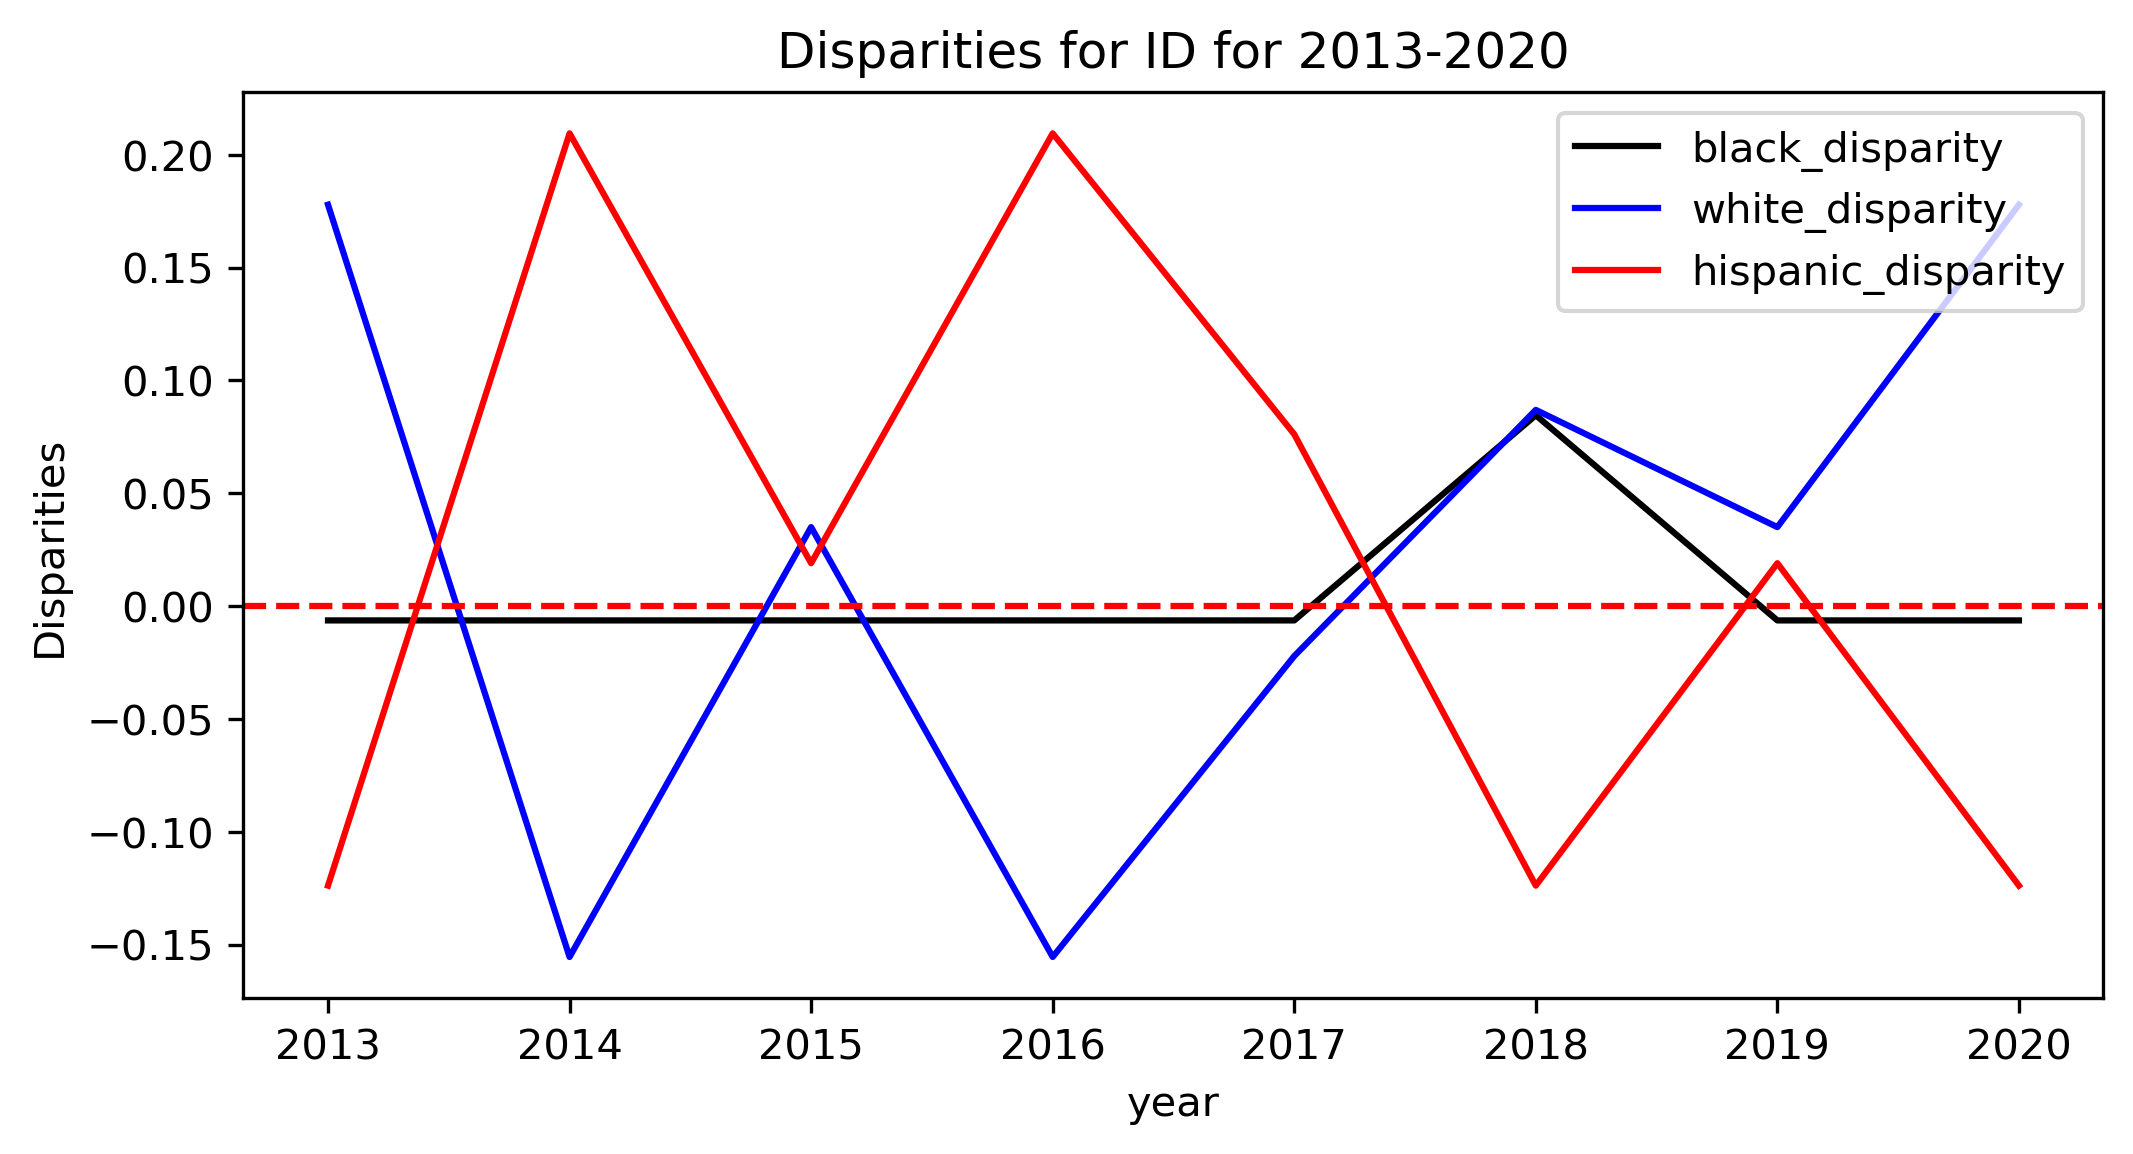

In [45]:
df = get_disparities_for_state(disparities_no_stops[["State", "Black", "Hispanic", "White"]], "MS")
df = get_disparities_for_state(disparities_no_stops[["State", "Black", "Hispanic", "White"]], "WY")
df = get_disparities_for_state(disparities_no_stops[["State", "Black", "Hispanic", "White"]], "ID")

### Observations

Intuitively, we'd expect that states with strict gun laws would have smaller disparity compared to the ones with loose ones but we observe quite the opposite. Specifically, in California and New Jersey, we observe that there is a constant gap between black and white disparity, when for Mississipi and Idaho ther quite intertwined. For Wyoming, our data showed that there were no black victims for police violence from 2013 which could be due to the very small percentage of black population in that state or due to incorrect victim race categorization as Unknown.

# Effect of protests

In [47]:
df = pd.read_excel("datasets/MPVDatasetDownload.xlsx", sheet_name="2013-2020 Police Killings")

In [48]:
df.head()

Victim's name Victim's age Victim's gender Victim's race  \
0       Pedro Martinez           66            Male      Hispanic   
1         James Horton           42            Male           NaN   
2  Dustin James Acosta           28            Male         White   
3          Javon Brice           39            Male           NaN   
4      Joshua D. Evans           32            Male           NaN   

  URL of image of victim Date of Incident (month/day/year)  \
0                    NaN                        2020-11-18   
1                    NaN                        2020-11-17   
2                    NaN                        2020-11-17   
3                    NaN                        2020-11-17   
4                    NaN                        2020-11-16   

  Street Address of Incident           City State  Zipcode  ...  \
0                        NaN         Tyler     TX      NaN  ...   
1                        NaN    Hart County    KY      NaN  ...   
2                        NaN  St. Augustine    FL      NaN  ...   
3                        NaN      La Vergne    TN      NaN  ...   
4                        NaN     Batesville    IN      NaN  ...   

  Unarmed/Did Not Have an Actual Weapon  \
0                       Allegedly Armed   
1                       Allegedly Armed   
2                       Allegedly Armed   
3                       Allegedly Armed   
4                       Allegedly Armed   

  Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)  \
0                                     unknown weapon                                
1                                                gun                                
2                                                gun                                
3                                                gun                                
4                                                gun                                

  Alleged Threat Level (Source: WaPo) Fleeing (Source: WaPo)  \
0                               other            not fleeing   
1                              attack                  other   
2                              attack                    NaN   
3                              attack                    car   
4                              attack            not fleeing   

  Body Camera (Source: WaPo) WaPo ID (If included in WaPo database)  \
0                         no                                 6321.0   
1                         no                                 6322.0   
2                         No                                 6320.0   
3                         no                                 6319.0   
4                         no                                 6314.0   

  Off-Duty Killing?  \
0               NaN   
1               NaN   
2               NaN   
3               NaN   
4               NaN   

  Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )  \
0                                                NaN                                                                                                                           
1                                                NaN                                                                                                                           
2                                                NaN                                                                                                                           
3                                                NaN                                                                                                                           
4                                                NaN                                                                                                                           

  MPV ID Fatal Encounters ID  
0    NaN 

We only keep the victims race, the date that (s)he died and the state that the incident happened

In [49]:
df = df[["Victim's race", "Date of Incident (month/day/year)", "State"] ]

In [50]:
df.head()

Victim's race Date of Incident (month/day/year) State
0      Hispanic                        2020-11-18    TX
1           NaN                        2020-11-17    KY
2         White                        2020-11-17    FL
3           NaN                        2020-11-17    TN
4           NaN                        2020-11-16    IN

In [51]:
df.columns = ["race", "date", "state"]

In [52]:
df["race"] = df.race.apply(lambda x: "Unknown" if x == "Unknown race" or x == "Unknown Race" or x == "unknown race" else x).iloc[:]

In [53]:
df.fillna("Unknown", inplace=True)

In [54]:
df.race.value_counts()

White               3769
Black               2158
Hispanic            1482
Unknown              922
Asian                132
Native American      120
Pacific Islander      46
Name: race, dtype: int64

We see that there is a significant amount of victims that has been classified as unkown

In [55]:
def get_week(df, event):
    "Get the week that the event happened"
    filtered = df[(df["date"] <= event)]
    return filtered.iloc[-1]["date"], filtered.index[-1]

In [56]:
def get_next_weeks(df, event, weeks):
    "Get the average number of victims for the next weeks weeks"
    pos = get_week(df, event)[1]
    if pos + weeks + 1 > len(df):
        return df.iloc[pos:].total_victims.mean()
    else:
        return df.iloc[pos + 1: pos + weeks + 1].total_victims.mean()

In [57]:
def get_previous_weeks(df, event, weeks):
    "Get the average number of victims for the previous weeks weeks"
    pos = get_week(df, event)[1]
    if pos - weeks < 0:
        return df.iloc[:pos].total_victims.mean()
    else:
        return df.iloc[pos - weeks:pos].total_victims.mean()

In [58]:
def do_plot(df, events, minority, year, title):
    "Plot the evolution of police killings before and after the events"
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)
    
    df["date_ordinal"]=df.date.apply(lambda date: date.toordinal()) # necessary for regplot
    
    for i, event in enumerate(events):
        d = datetime.datetime.strptime(event, '%Y-%m-%d').date() # get date of the event
        if len(events) == 1:
            df_before = df[df["date"]<=event]
            df_after = df[df["date"]>event]
        elif i == 0:
            df_before = df[df["date"]<=event]
        elif i == len(events) - 1:
            df_before = df[(df["date"]>=events[i - 1]) & (df["date"]<=event)]
            df_after = df[df["date"]>event]
        else:
            df_before = df[(df["date"]>=events[i - 1]) & (df["date"]<=event)]
            
        sns.regplot(x=df_before.date_ordinal,y=df_before.total_victims,data=df_before, fit_reg=True,scatter=False, color='black')
        ax.axvline(x=d.toordinal(), color = "red")
        
    sns.regplot(x=df_after.date_ordinal,y=df_after.total_victims,data=df_after, fit_reg=True,scatter=False, color='black')
    sns.lineplot(x=df.date_ordinal, y = df.total_victims, data = df)

    # convert x axis labels from numericals to actual dates
    xticks = ax.get_xticks()
    xticks_dates = [datetime.date.fromordinal(int(x)).strftime('%Y-%m-%d') for x in xticks]
    ax.set_xticklabels(xticks_dates)
    
    if title:
        ax.set_title(title)
    
    if minority:
        ax.set_ylabel(f"Total {minority} victims")
    else:
        ax.set_ylabel("Total victims")
    ax.set_xlabel("Date")
    plt.savefig(f"./images/protest_{minority}_{year}.png", bbox_inches='tight')

    plt.show()

In [59]:
def blm_march_influence(df, year, events, weeks, minority = None, title = None):
    """
    Calculate and plot the impact of some events that represent protests on the police killings against a specific race or in total
    """
    df = df[(df["date"] >= f"{year}-01-01") & (df["date"] <= f"{year}-12-31")].reset_index(drop = True).iloc[:] # restrict to a specific year
    
    if minority:
        df = df[df["race"] == minority].reset_index(drop = True) # restrict to minority
    
    grouped = df.groupby("date")
    killings = {}

    for date in set(df["date"]):
        killings[date] = grouped.get_group(date).size / 3
    
    df = pd.DataFrame(killings.items(), columns = ["date", "total_victims"])
    pd.Grouper(key = "date", freq = "1W")
    df = df.groupby(pd.Grouper(key = "date", freq = "1W",)).sum().reset_index()
    
    
    do_plot(df, events, minority, year, title)
    
    for event in events:
        print(f"Average number of deaths over the previous {weeks} weeks before the event of {event} :" , get_previous_weeks(df, event, weeks))
        print(f"Average number of deaths over the next {weeks} weeks after the event of {event}:" , get_next_weeks(df, event, weeks))
        print()
    return df

First we'll create a list of major Black lives matter protests taken from https://www.abc.net.au/news/2016-07-14/black-lives-matter-timeline/7585856?nw=0 and https://en.wikipedia.org/wiki/Black_Lives_Matter#Timeline_of_notable_events_and_demonstrations_in_the_United_States

In [60]:
g_floyd = "2020-05-25" # George Floyd's death
b_taylor = "2020-03-13" # Breonna Taylor's death
biggest = "2020-06-06" # Biggest blm protest of 2020

events = ["2013-11-02", "2014-07-17", "2014-08-09", "2015-04-12", "2015-11-16", "2015-11-24", "2016-07-05", b_taylor, g_floyd]

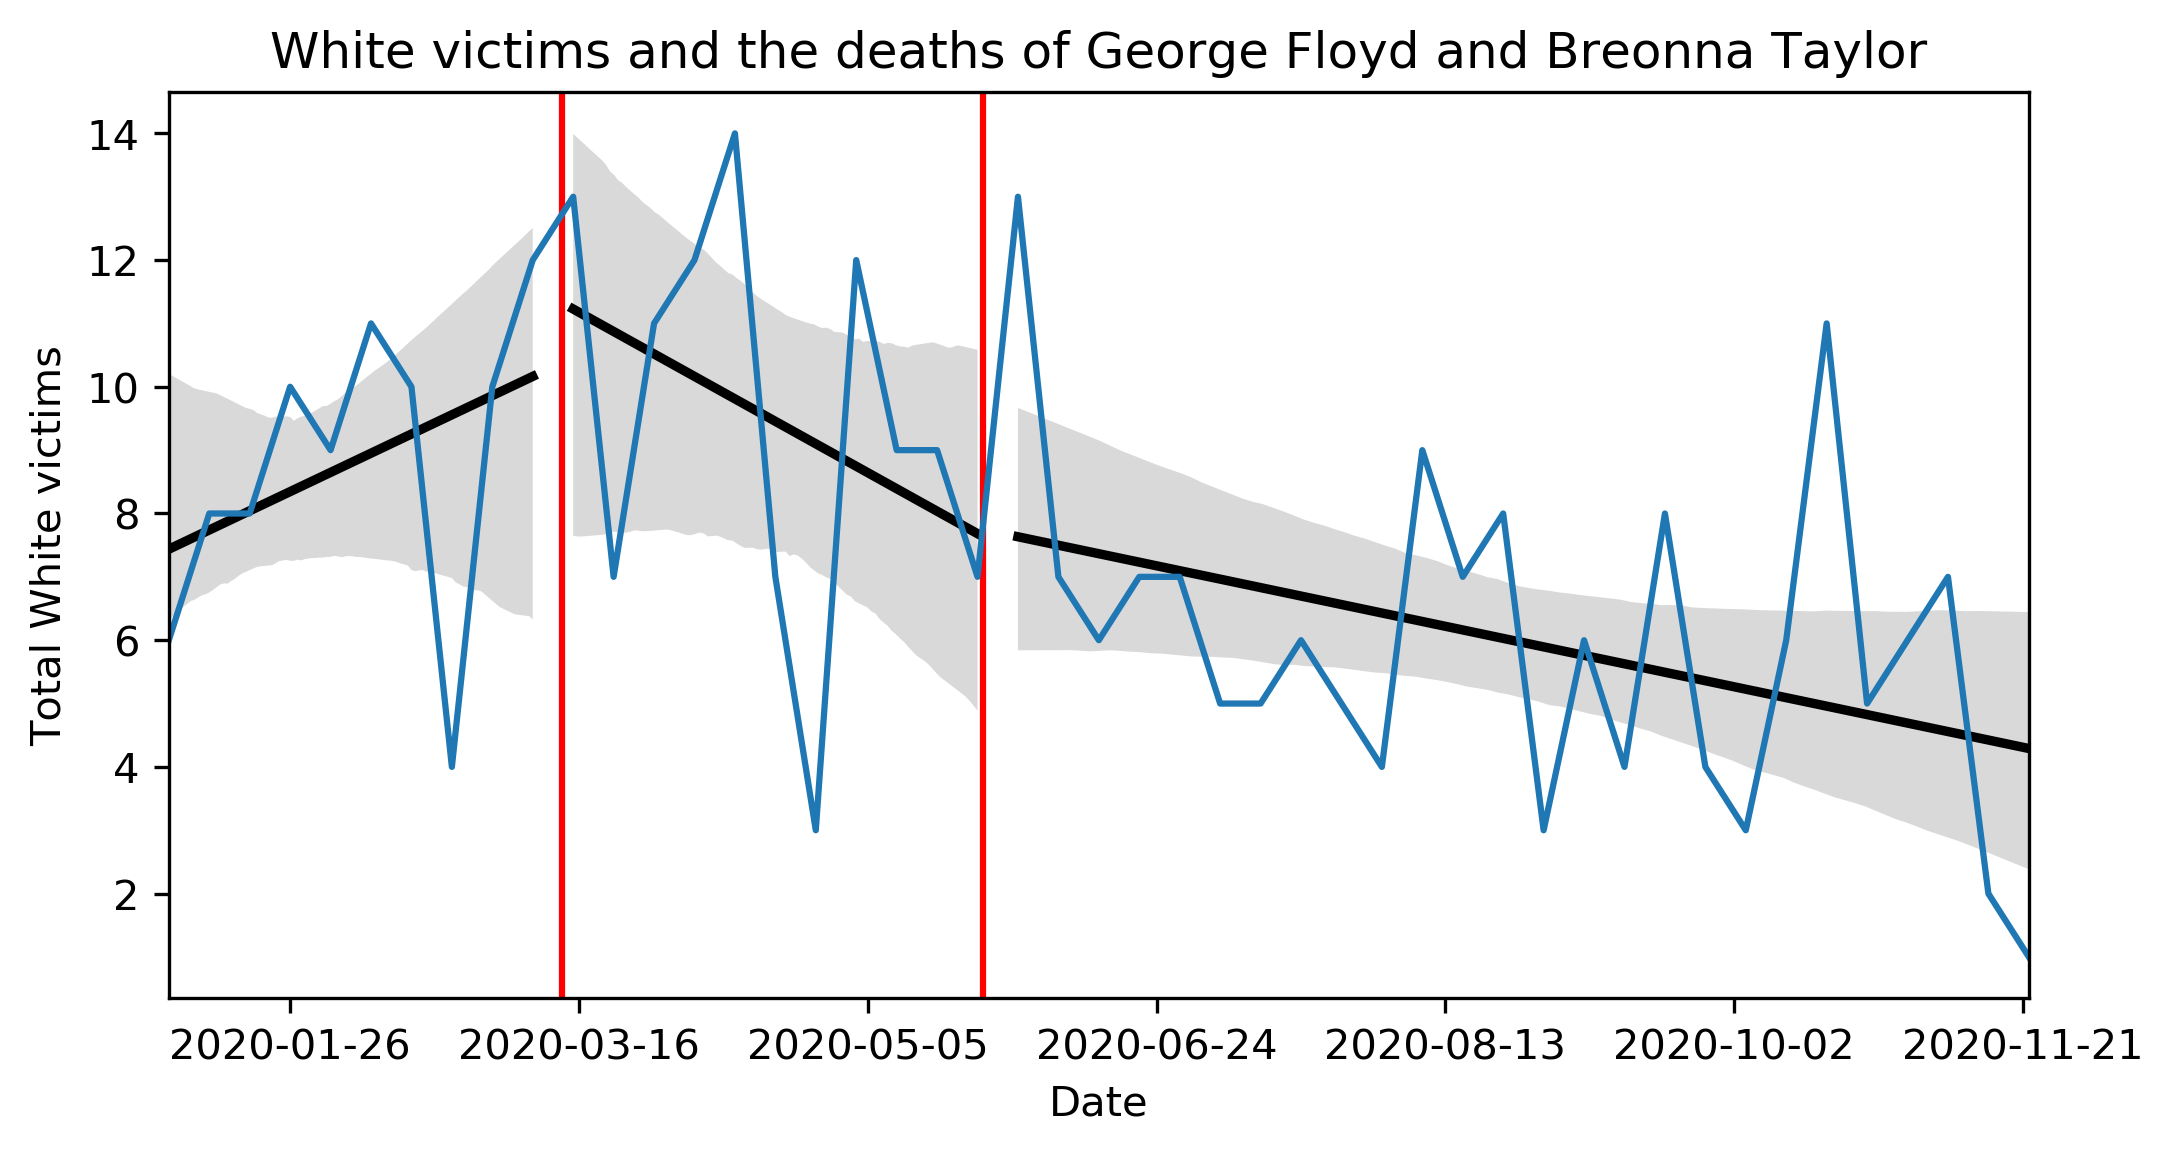

Average number of deaths over the previous 5 weeks before the event of 2020-03-13 : 8.8
Average number of deaths over the next 5 weeks after the event of 2020-03-13: 11.4

Average number of deaths over the previous 5 weeks before the event of 2020-05-25 : 8.0
Average number of deaths over the next 5 weeks after the event of 2020-05-25: 8.0



In [61]:
df_events = blm_march_influence(df, "2020", events[7:], 5, minority="White", title = "White victims and the deaths of George Floyd and Breonna Taylor")

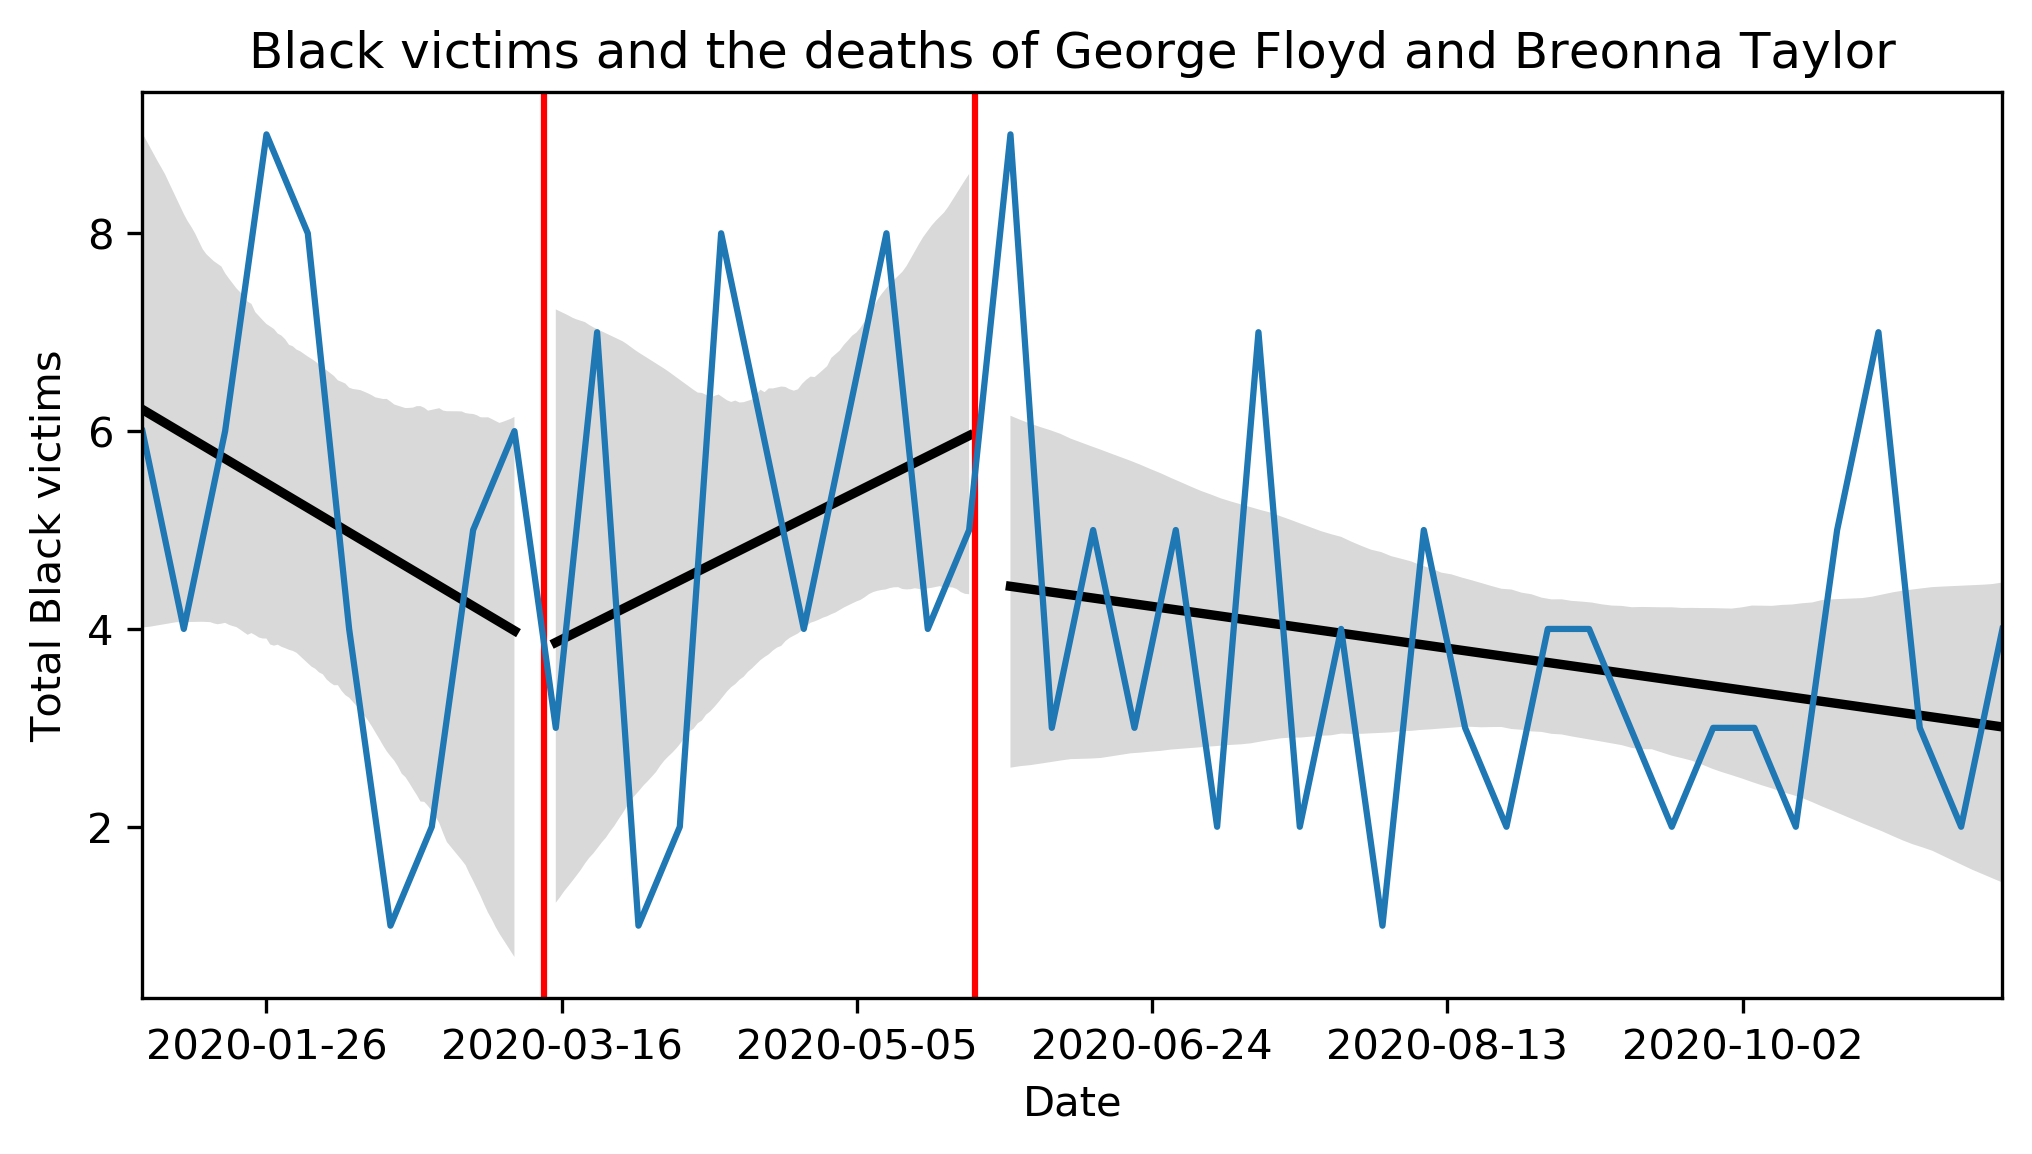

Average number of deaths over the previous 5 weeks before the event of 2020-03-13 : 4.0
Average number of deaths over the next 5 weeks after the event of 2020-03-13: 4.2

Average number of deaths over the previous 5 weeks before the event of 2020-05-25 : 5.6
Average number of deaths over the next 5 weeks after the event of 2020-05-25: 5.0



In [62]:
df_events = blm_march_influence(df, "2020", events[7:], 5, minority="Black", title = "Black victims and the deaths of George Floyd and Breonna Taylor")

## George Floyd

George Floyd's death sparked huge protests across the US and it was a landmark event for the BLM movement. Let's see how the protests that started because of it influenced police violence.

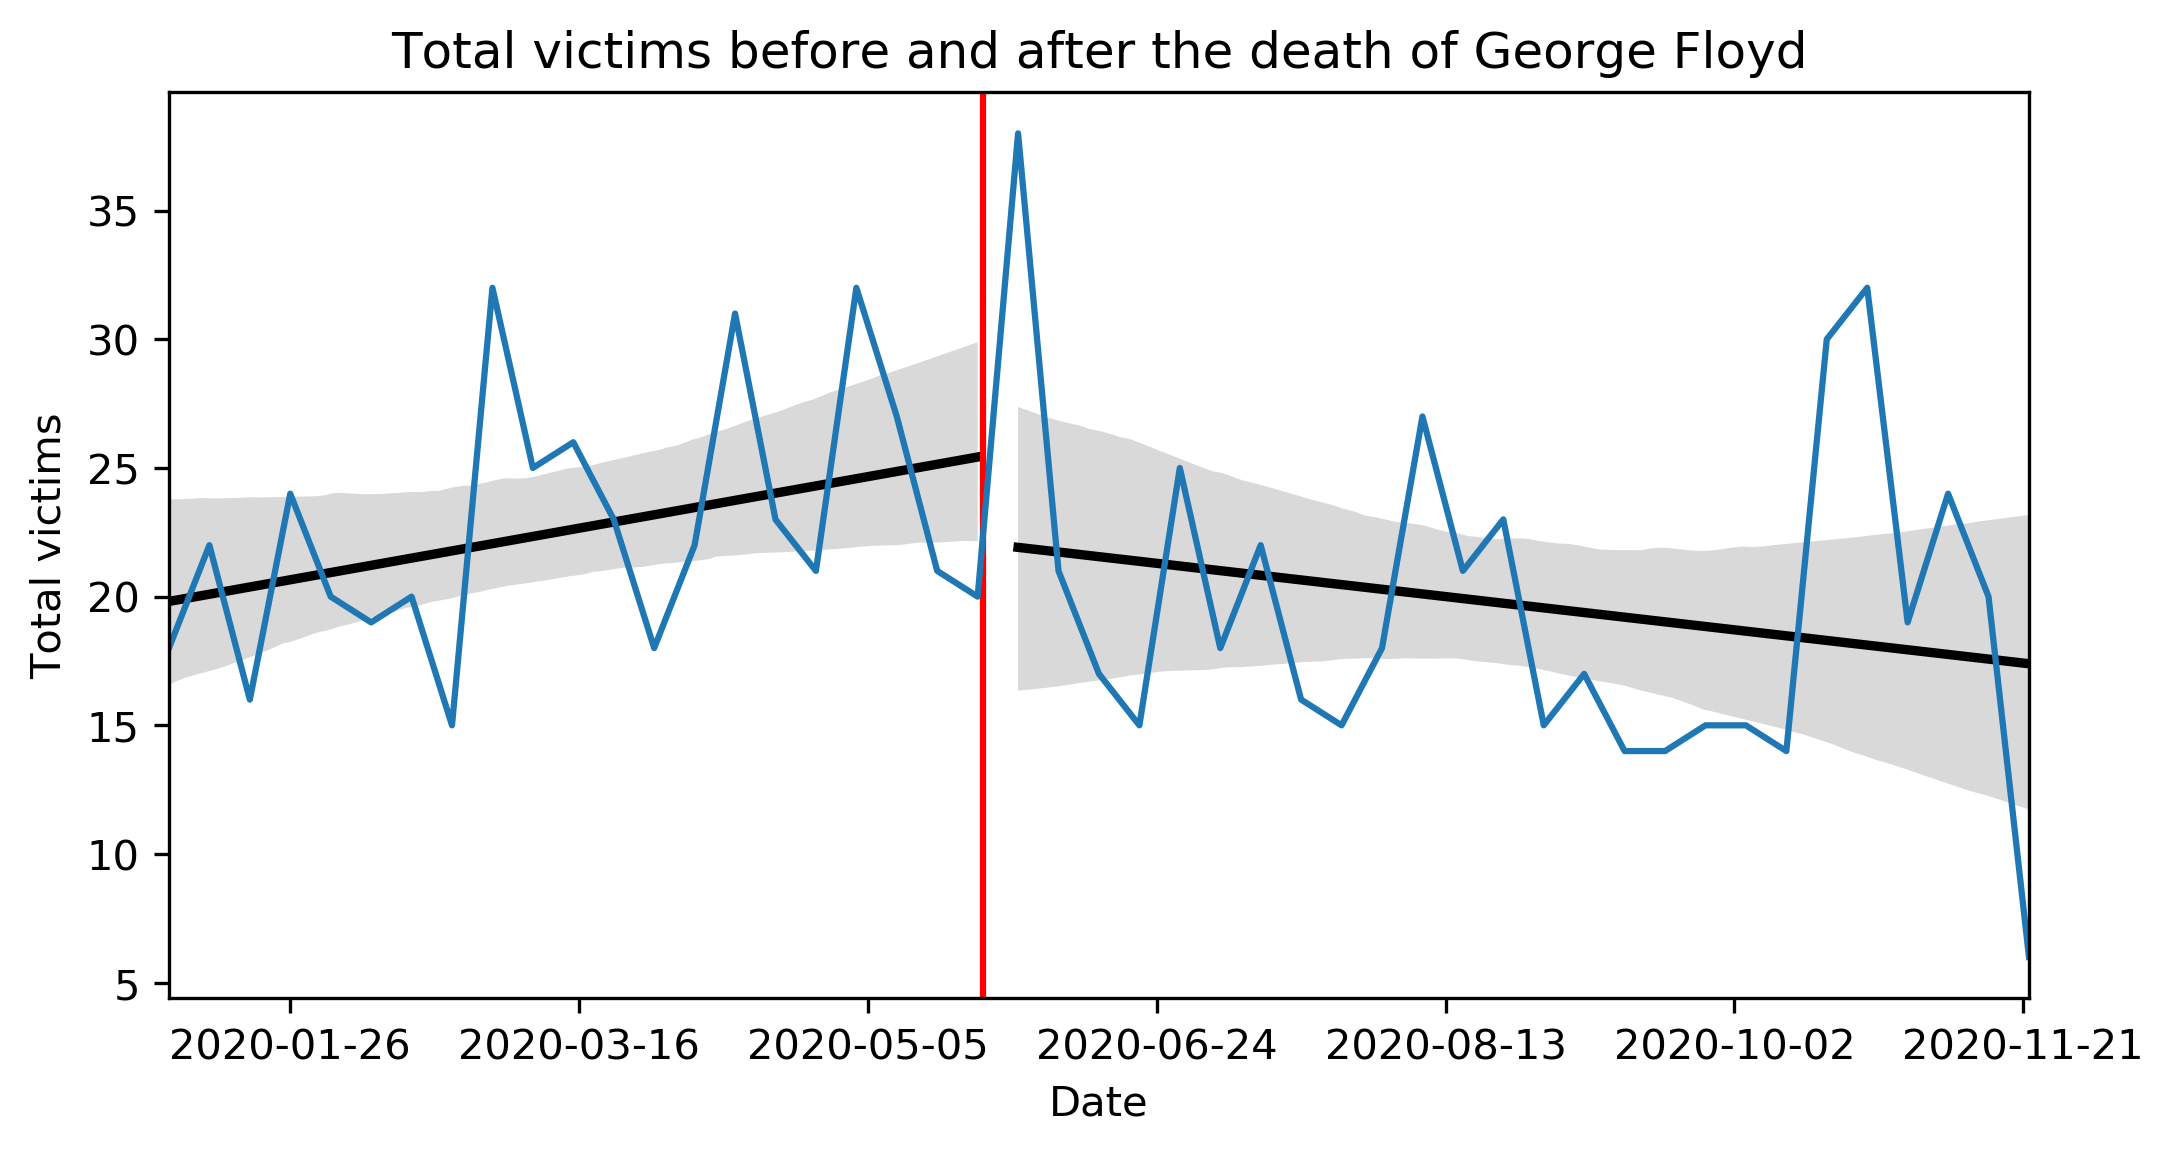

Average number of deaths over the previous 5 weeks before the event of 2020-05-25 : 24.8
Average number of deaths over the next 5 weeks after the event of 2020-05-25: 23.2



In [63]:
df_events = blm_march_influence(df, "2020", [g_floyd], 5, title = "Total victims before and after the death of George Floyd")

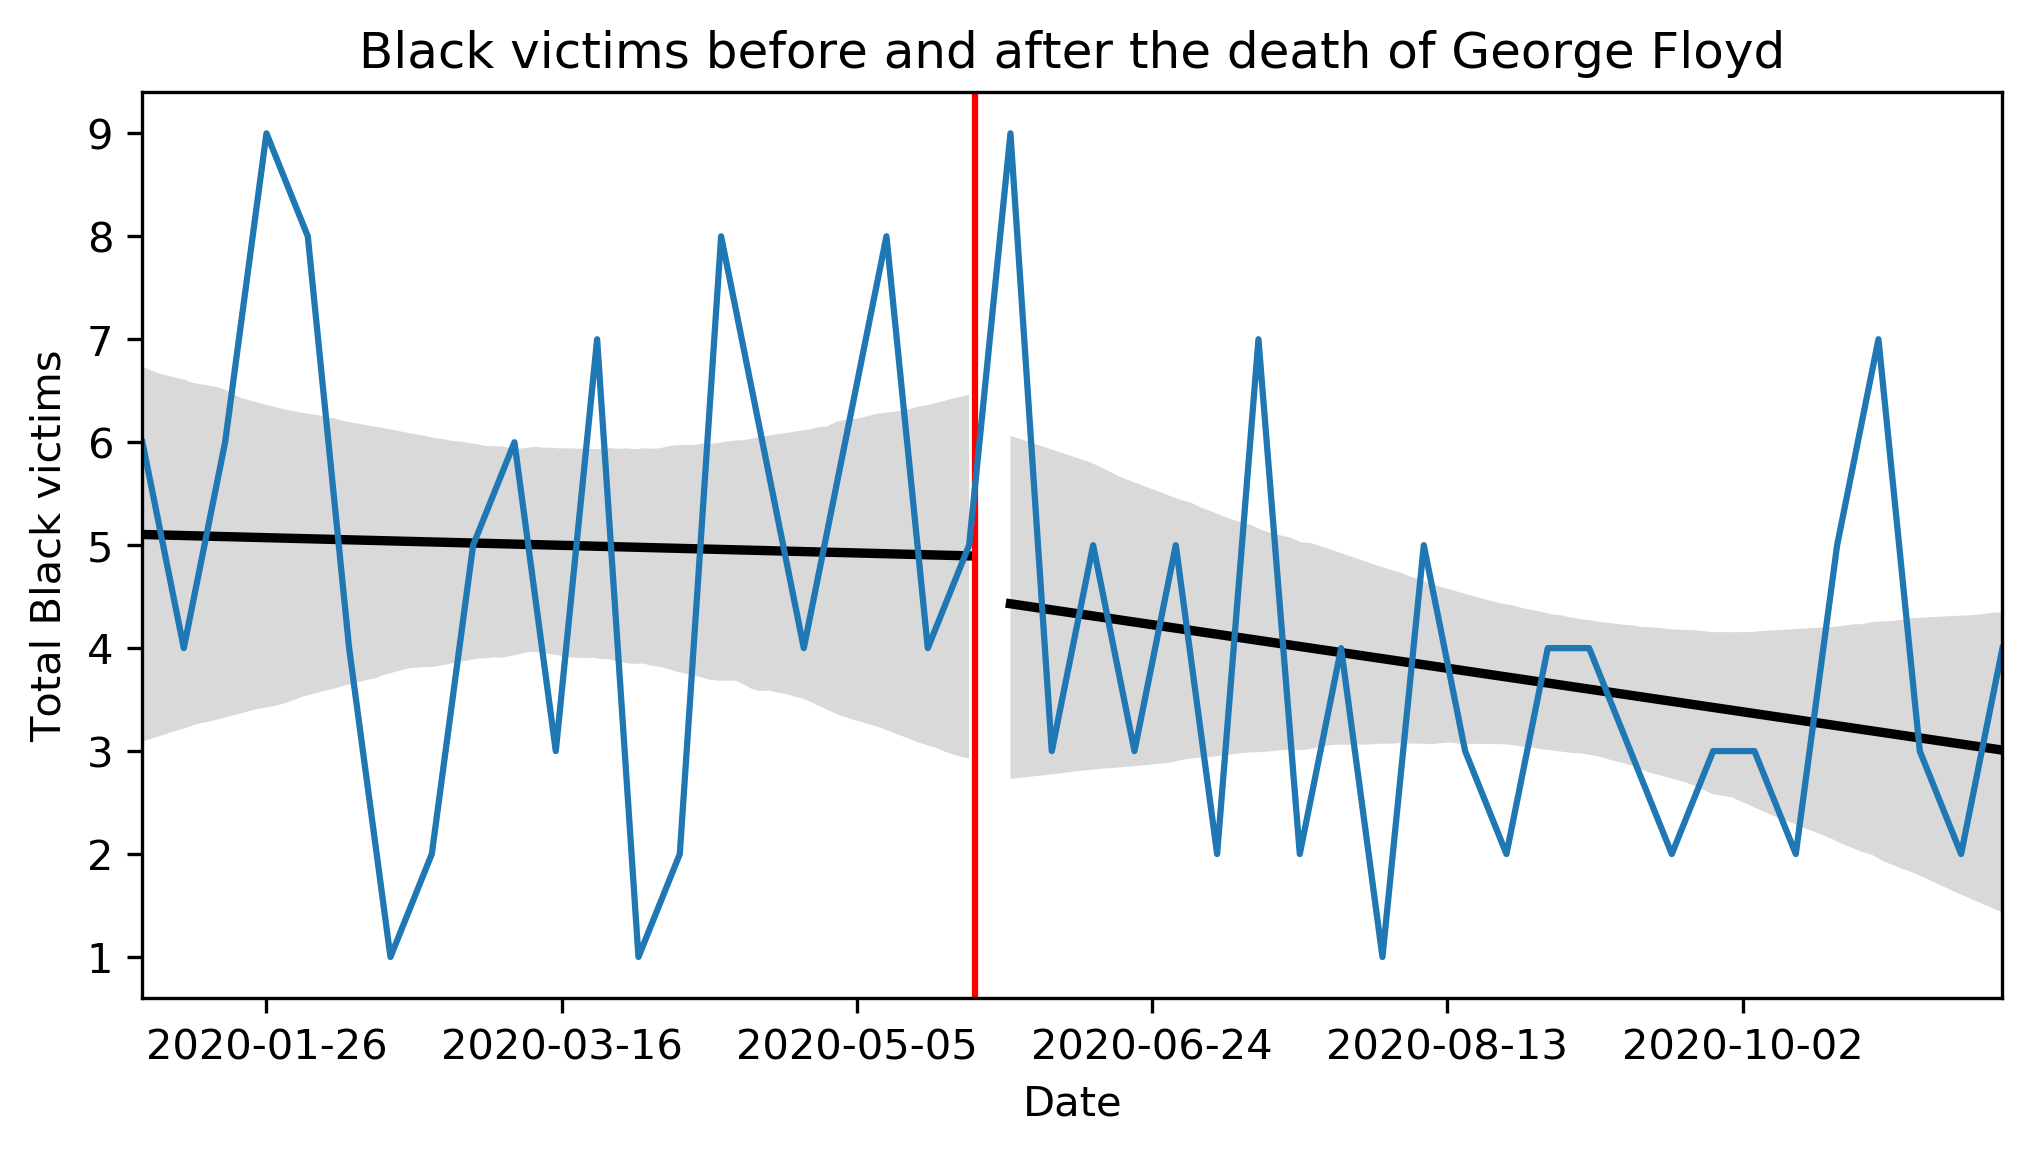

Average number of deaths over the previous 5 weeks before the event of 2020-05-25 : 5.6
Average number of deaths over the next 5 weeks after the event of 2020-05-25: 5.0



In [64]:
df_events = blm_march_influence(df, "2020", [g_floyd], 5, minority="Black", title = "Black victims before and after the death of George Floyd")

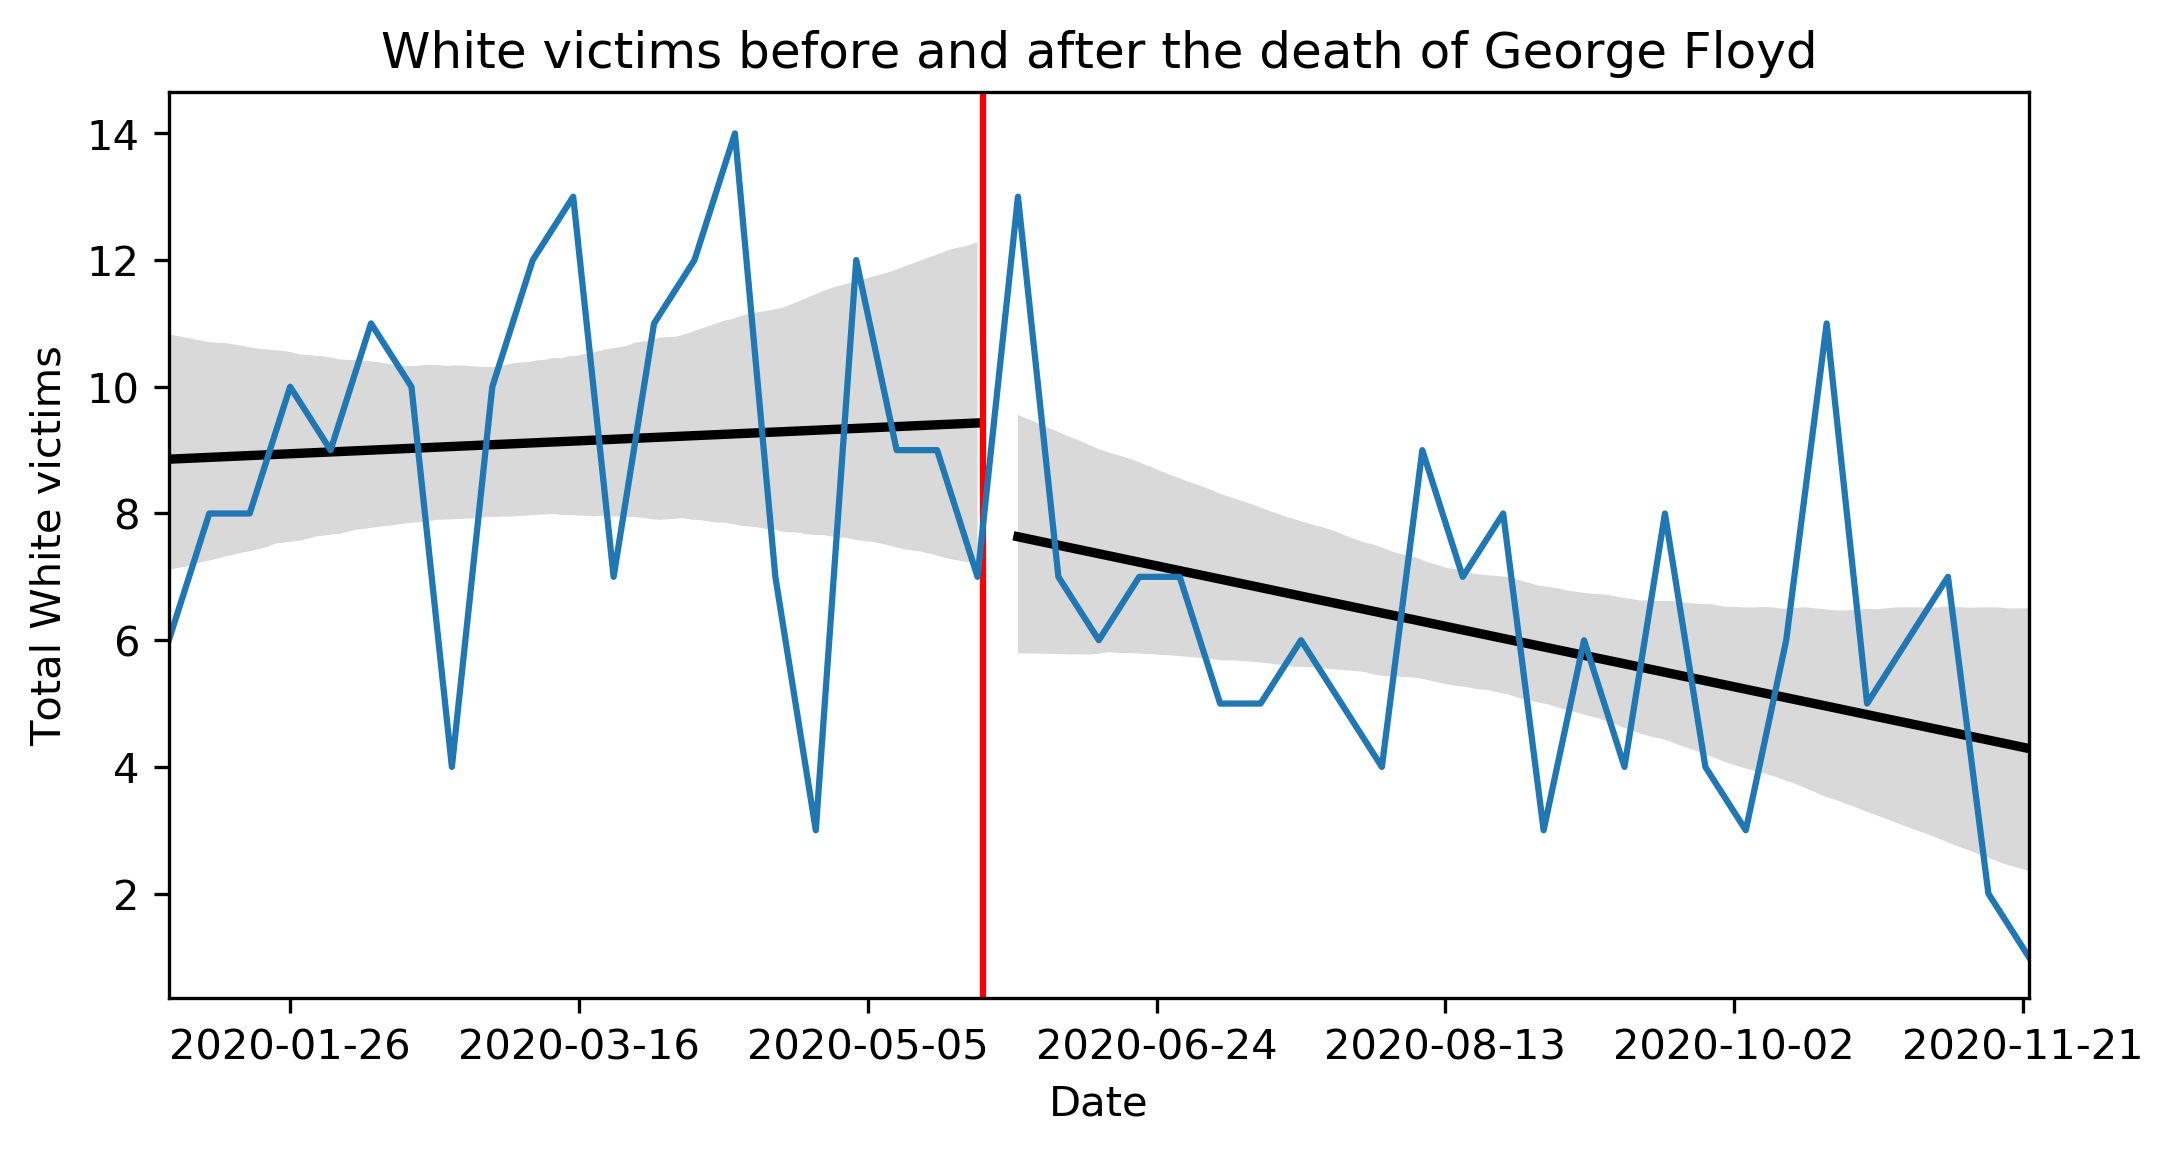

Average number of deaths over the previous 5 weeks before the event of 2020-05-25 : 8.0
Average number of deaths over the next 5 weeks after the event of 2020-05-25: 8.0



In [65]:
df_events = blm_march_influence(df, "2020", [g_floyd], 5, minority="White", title = "White victims before and after the death of George Floyd")

## Observations

For both white, black and total victims we observe that the slope of the regression line after the protests is negative, meaning that in the longterm police violence was reduced

For the shorterm effect, we see that the average number of black and total victims in the 5 weeks following the protests are reduced compared to the 5 weeks before the protests and for white people they remain constant. 

## Analyzing 2015's protests

2015 was a year were very big blm events took place but we decided to focus on two of them: the April protests in Maryland and the November rally in New York

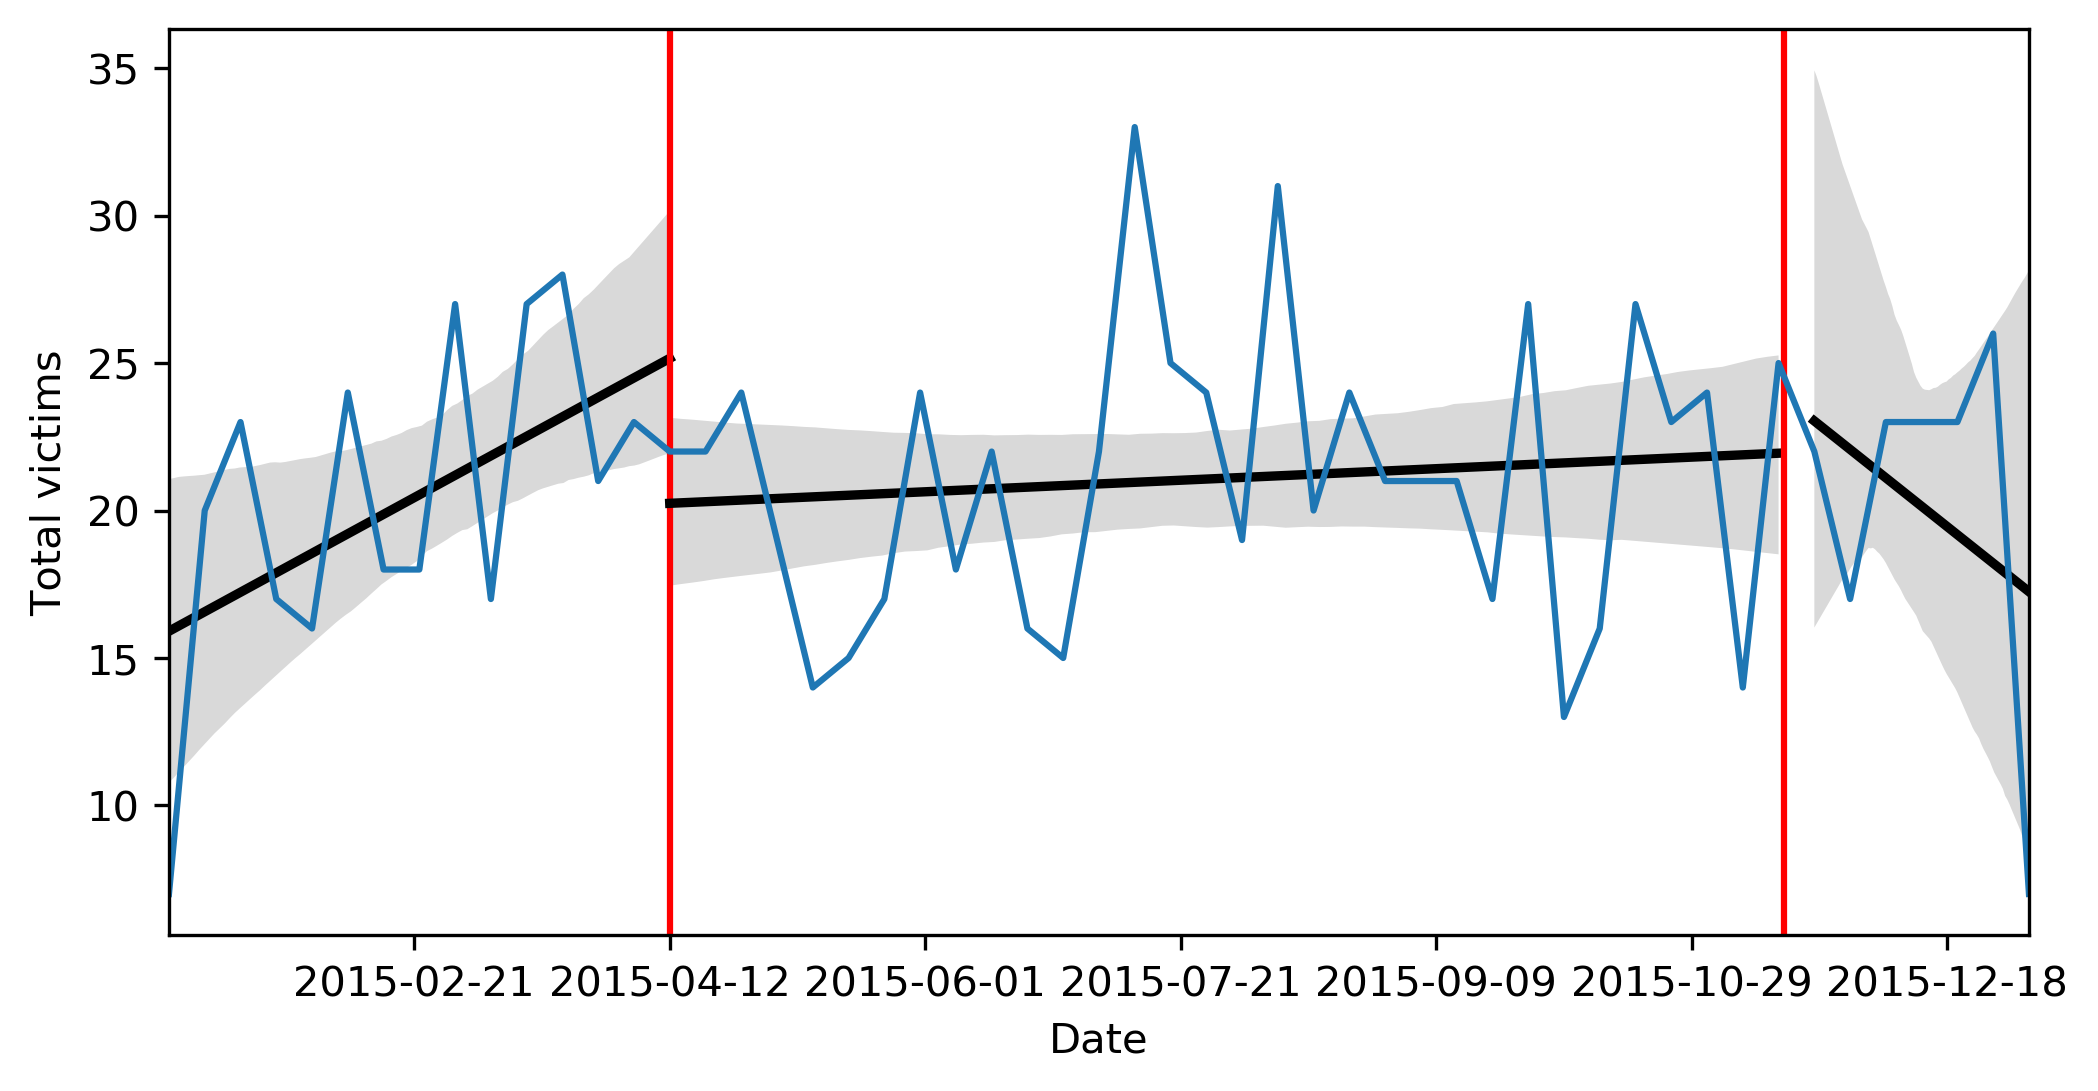

Average number of deaths over the previous 5 weeks before the event of 2015-04-12 : 23.2
Average number of deaths over the next 5 weeks after the event of 2015-04-12: 18.8

Average number of deaths over the previous 5 weeks before the event of 2015-11-16 : 20.8
Average number of deaths over the next 5 weeks after the event of 2015-11-16: 21.6



In [66]:
df_events = blm_march_influence(df, "2015", events[3:5], 5)

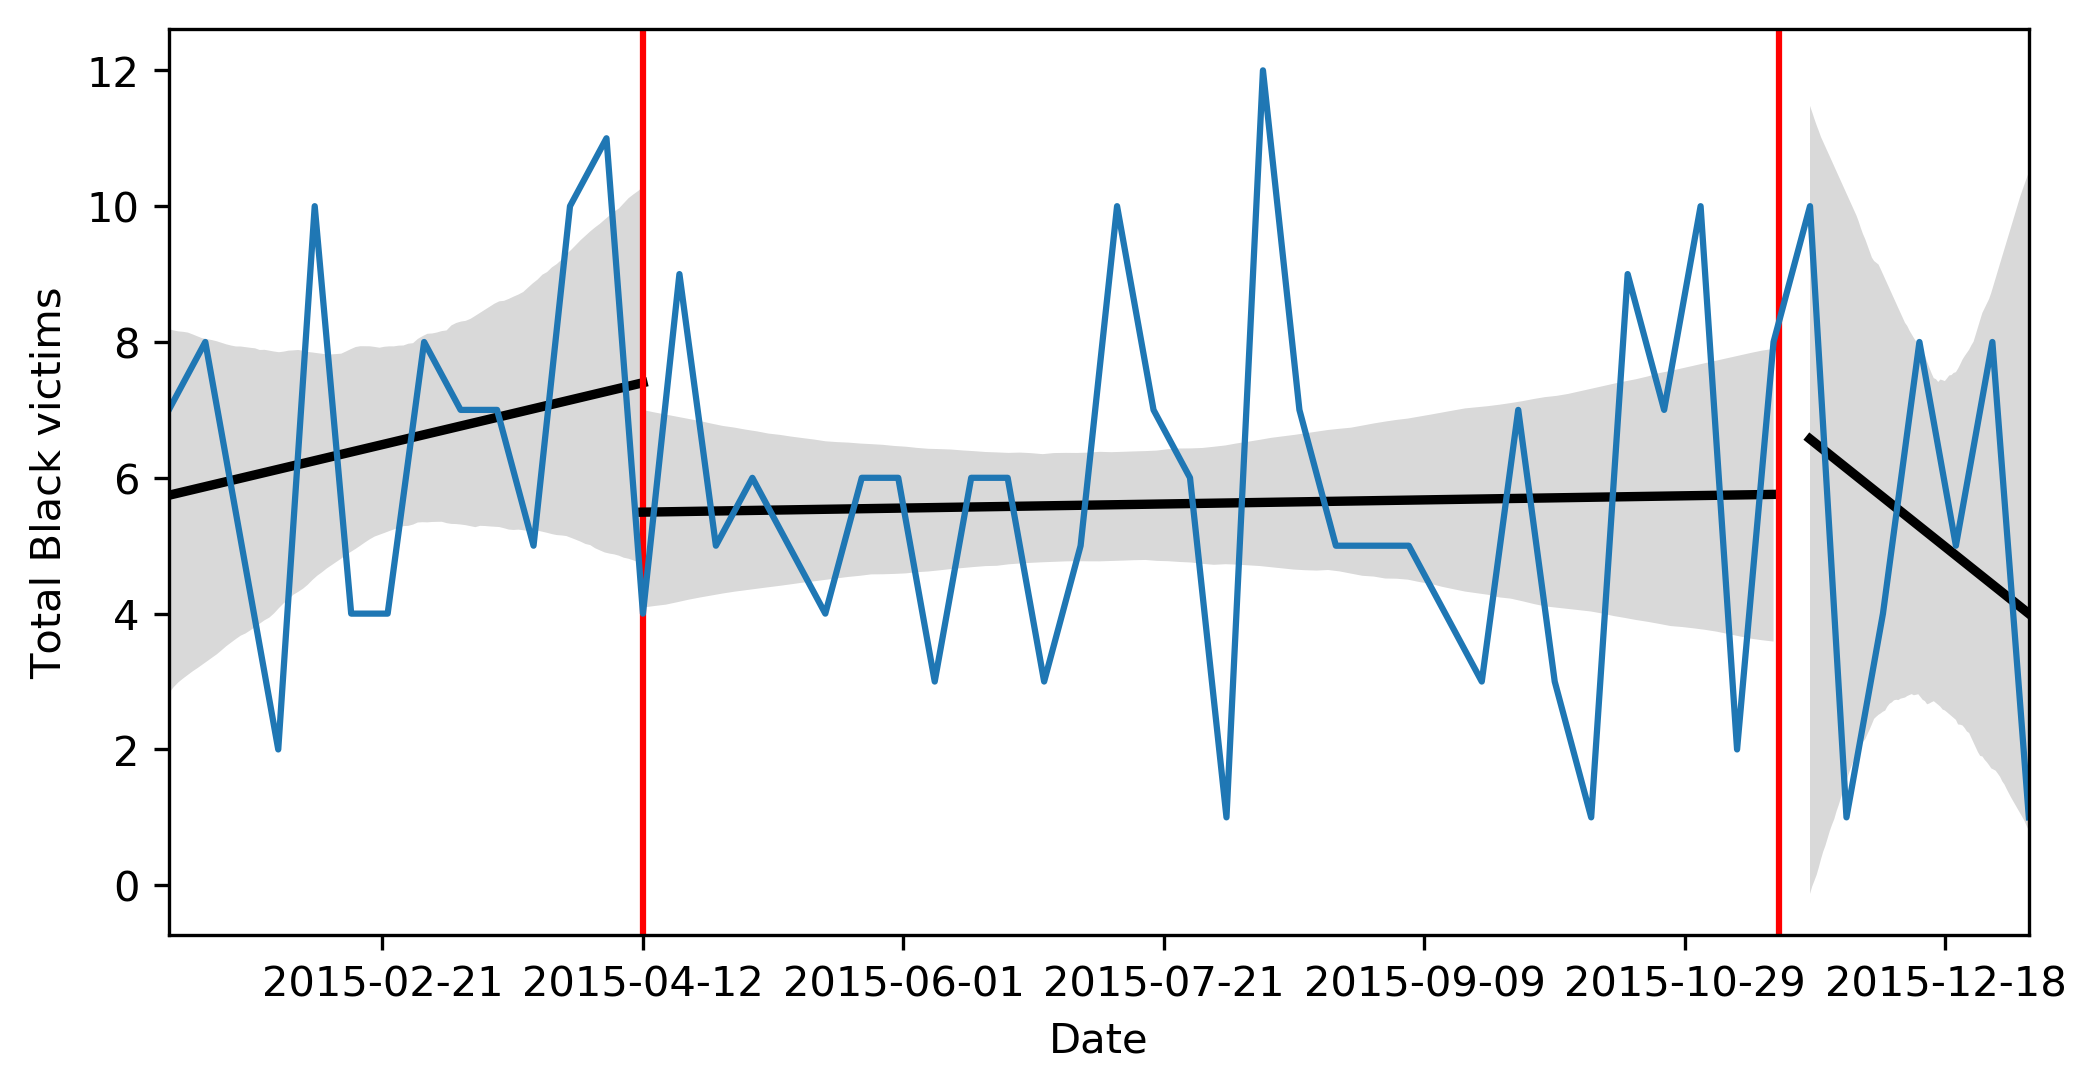

Average number of deaths over the previous 5 weeks before the event of 2015-04-12 : 8.0
Average number of deaths over the next 5 weeks after the event of 2015-04-12: 5.8

Average number of deaths over the previous 5 weeks before the event of 2015-11-16 : 5.8
Average number of deaths over the next 5 weeks after the event of 2015-11-16: 5.6



In [67]:
df_events = blm_march_influence(df, "2015", events[3:5], 5, minority="Black")

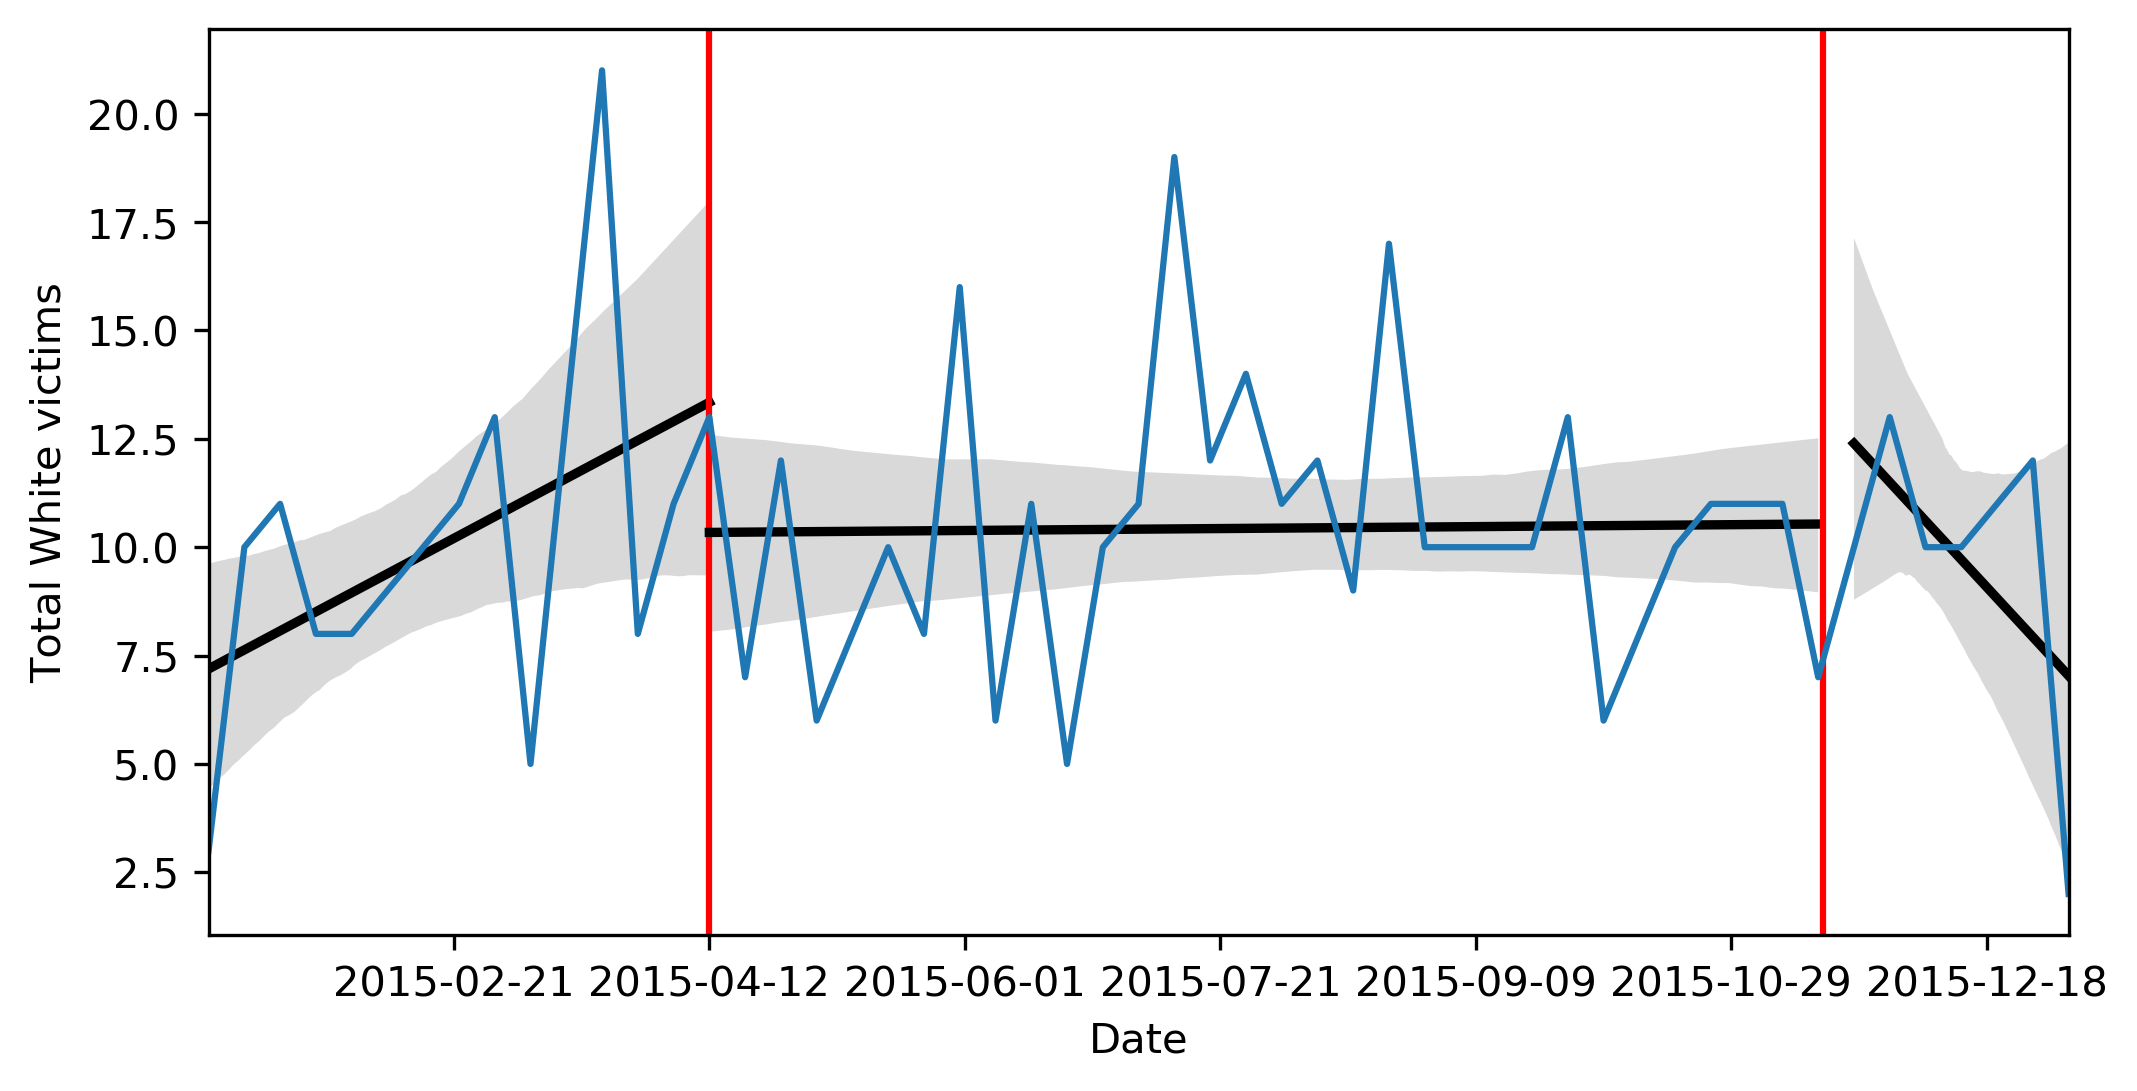

Average number of deaths over the previous 5 weeks before the event of 2015-04-12 : 11.6
Average number of deaths over the next 5 weeks after the event of 2015-04-12: 8.6

Average number of deaths over the previous 5 weeks before the event of 2015-11-16 : 10.2
Average number of deaths over the next 5 weeks after the event of 2015-11-16: 10.8



In [68]:
df_events = blm_march_influence(df, "2015", events[3:5], 5, minority="White")

## Observations

There are a few things we observe in these plots:
- For total victims we see that after the first event, in the short-term there's a huge drop in police killings but actually until the second event the trend is slightly increasing.
- In the few weeks after the first event we observe that although the number of white victims drops, the black victims sharply increase, an effect that in the long term gets neutralized as both regression lines have similar slopes.
- For the second event in the black victims plot, the coming weeks were quite unstable seeing big increases and drops whereas for white victims it's a more regular pattern.

# Part 2 (Gerald Sula)

Let's start by loading the data of the government killings in the US. Every year/sector is in a separate file, so let's load them one by one, and also perform some quick cleaning while loading them.

In [2]:
def parse_number(number):
    '''
    Helper fuction used to pase numbers containing comma in the 100s.
    '''

    new_number= number.replace(",","")
    return float(new_number)

In [3]:
all_files = glob.glob("./datasets/spending_data/*.csv")
all_files.sort()
datasets = []

main_df = pd.DataFrame(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'All states combined', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],  columns =['State'])

for filename in all_files:
    print(filename)
    split=filename.split('_')
    year=split[-2]
    sector=split[-1][:-4]
    

    df = pd.read_csv(filename,skiprows=6)
    df.drop(df.tail(4).index, inplace = True) 
    df = df.drop(columns=df.columns.difference(['State','State and Local Spending']))
    
    df["State and Local Spending"] = df["State and Local Spending"].apply(lambda x: parse_number(x))
    df.columns= ["State", "{}_{}".format(year, sector)]
    
    
    main_df= pd.merge(main_df, df, on ="State")



./datasets/spending_data/usgs_state_2013_edu.csv
./datasets/spending_data/usgs_state_2013_health.csv
./datasets/spending_data/usgs_state_2013_police.csv
./datasets/spending_data/usgs_state_2014_edu.csv
./datasets/spending_data/usgs_state_2014_health.csv
./datasets/spending_data/usgs_state_2014_police.csv
./datasets/spending_data/usgs_state_2015_edu.csv
./datasets/spending_data/usgs_state_2015_health.csv
./datasets/spending_data/usgs_state_2015_police.csv
./datasets/spending_data/usgs_state_2016_edu.csv
./datasets/spending_data/usgs_state_2016_health.csv
./datasets/spending_data/usgs_state_2016_police.csv
./datasets/spending_data/usgs_state_2017_edu.csv
./datasets/spending_data/usgs_state_2017_health.csv
./datasets/spending_data/usgs_state_2017_police.csv
./datasets/spending_data/usgs_state_2018_edu.csv
./datasets/spending_data/usgs_state_2018_health.csv
./datasets/spending_data/usgs_state_2018_police.csv
./datasets/spending_data/usgs_state_2019_edu.csv
./datasets/spending_data/usgs_sta

In [4]:
main_df.head()

State  2013_edu  2013_health  2013_police  2014_edu  2014_health  \
0     Alabama    3016.4       2400.1        501.0    2984.9       2451.7   
1      Alaska    4977.5       3041.5       1240.3    4923.4       3024.5   
2     Arizona    2193.0       1577.6        746.4    2265.4       1690.9   
3    Arkansas    2772.2       1972.7        490.5    2758.8       2123.4   
4  California    2748.0       2240.2       1029.5    2826.2       2444.7   

   2014_police  2015_edu  2015_health  2015_police  ...  2017_police  \
0        507.2    3049.6       2516.7        530.3  ...        542.8   
1       1286.6    5036.4       3091.4       1356.8  ...       1307.7   
2        737.1    2058.9       1332.9        742.2  ...        786.5   
3        510.1    2766.2       2470.6        534.4  ...        526.9   
4       1083.1    2995.8       3211.7       1106.1  ...       1181.7   

   2018_edu  2018_health  2018_police  2019_edu  2019_health  2019_police  \
0    3027.1       2767.2        563.0    3147.8       2770.9        583.4   
1    4422.2       3896.6       1556.8    4356.7       3988.2       1631.4   
2    2231.0       1845.4        771.0    2291.2       1889.6        762.1   
3    2918.8       2627.0        536.9    3032.0       2543.9        548.2   
4    3616.4       4126.5       1244.0    3852.2       4403.7       1307.5   

   2020_edu  2020_health  2020_police  
0    3265.9       2788.6        603.6  
1    4315.1       4080.0       1700.8  
2    2349.8       1933.3        757.9  
3    3142.2       2486.1        560.3  
4    4075.0       4665.0       1369.1  

[5 rows x 25 columns]

Throughout all the notebook, we will be loading data that comes from different sources. So it's a good idea to homogenify some fields, such as the name of the State. We are defining a helper dictionary that will help matching different states of the us to unique identifying characters. 

In [5]:
main_df = main_df[main_df.State != "All states combined"]

us_state_abbrev = {    'Alabama': 'AL',    'Alaska': 'AK',    'American Samoa': 'AS',    'Arizona': 'AZ',    'Arkansas': 'AR',    'California': 'CA',    'Colorado': 'CO',    'Connecticut': 'CT',    'Delaware': 'DE',    'District of Columbia': 'DC',    'Florida': 'FL',    'Georgia': 'GA',    'Guam': 'GU',    'Hawaii': 'HI',    'Idaho': 'ID',    'Illinois': 'IL',    'Indiana': 'IN',    'Iowa': 'IA',    'Kansas': 'KS',    'Kentucky': 'KY',    'Louisiana': 'LA',    'Maine': 'ME',    'Maryland': 'MD',    'Massachusetts': 'MA',    'Michigan': 'MI',    'Minnesota': 'MN',    'Mississippi': 'MS',    'Missouri': 'MO',    'Montana': 'MT',    'Nebraska': 'NE',    'Nevada': 'NV',    'New Hampshire': 'NH',    'New Jersey': 'NJ',    'New Mexico': 'NM',    'New York': 'NY',    'North Carolina': 'NC',    'North Dakota': 'ND',    'Northern Mariana Islands':'MP',    'Ohio': 'OH',    'Oklahoma': 'OK',    'Oregon': 'OR',    'Pennsylvania': 'PA',    'Puerto Rico': 'PR',    'Rhode Island': 'RI',    'South Carolina': 'SC',    'South Dakota': 'SD',    'Tennessee': 'TN',    'Texas': 'TX',    'Utah': 'UT',    'Vermont': 'VT',    'Virgin Islands': 'VI',    'Virginia': 'VA',    'Washington': 'WA',    'West Virginia': 'WV',    'Wisconsin': 'WI',    'Wyoming': 'WY'}


main_df["State"] = main_df["State"].apply(lambda x: us_state_abbrev[x])

Since the different fundings do not change a lot from year to year, we will be taking the average value through the last 6 years for the fundings.

In [6]:
# Compute mean per each sector

main_df["mean_edu"]=main_df.filter(regex='edu').mean(axis=1)
main_df["mean_police"]=main_df.filter(regex='police').mean(axis=1)
main_df["mean_health"]=main_df.filter(regex='health').mean(axis=1)

main_df = main_df.drop(columns=main_df.columns.difference(['State','mean_edu', 'mean_police', 'mean_health']))

In [7]:
main_df.set_index("State", inplace=True)

In [8]:
main_df.head()

mean_edu  mean_police  mean_health
State                                     
AL     3026.6875     545.4375    2648.4250
AK     4669.4625    1423.0625    3528.7125
AZ     2209.9375     757.7875    1721.4500
AR     2877.7125     529.2500    2451.8375
CA     3338.5500    1185.1375    3530.4750

In [9]:
main_df=main_df[['mean_police','mean_edu','mean_health']]

Great! The first dataset is ready. Let's quickly visualize the data we have, by sorting on the average police funding in every state.

In [10]:
main_df_sorted =  main_df.sort_values(by='mean_police', ascending=False)

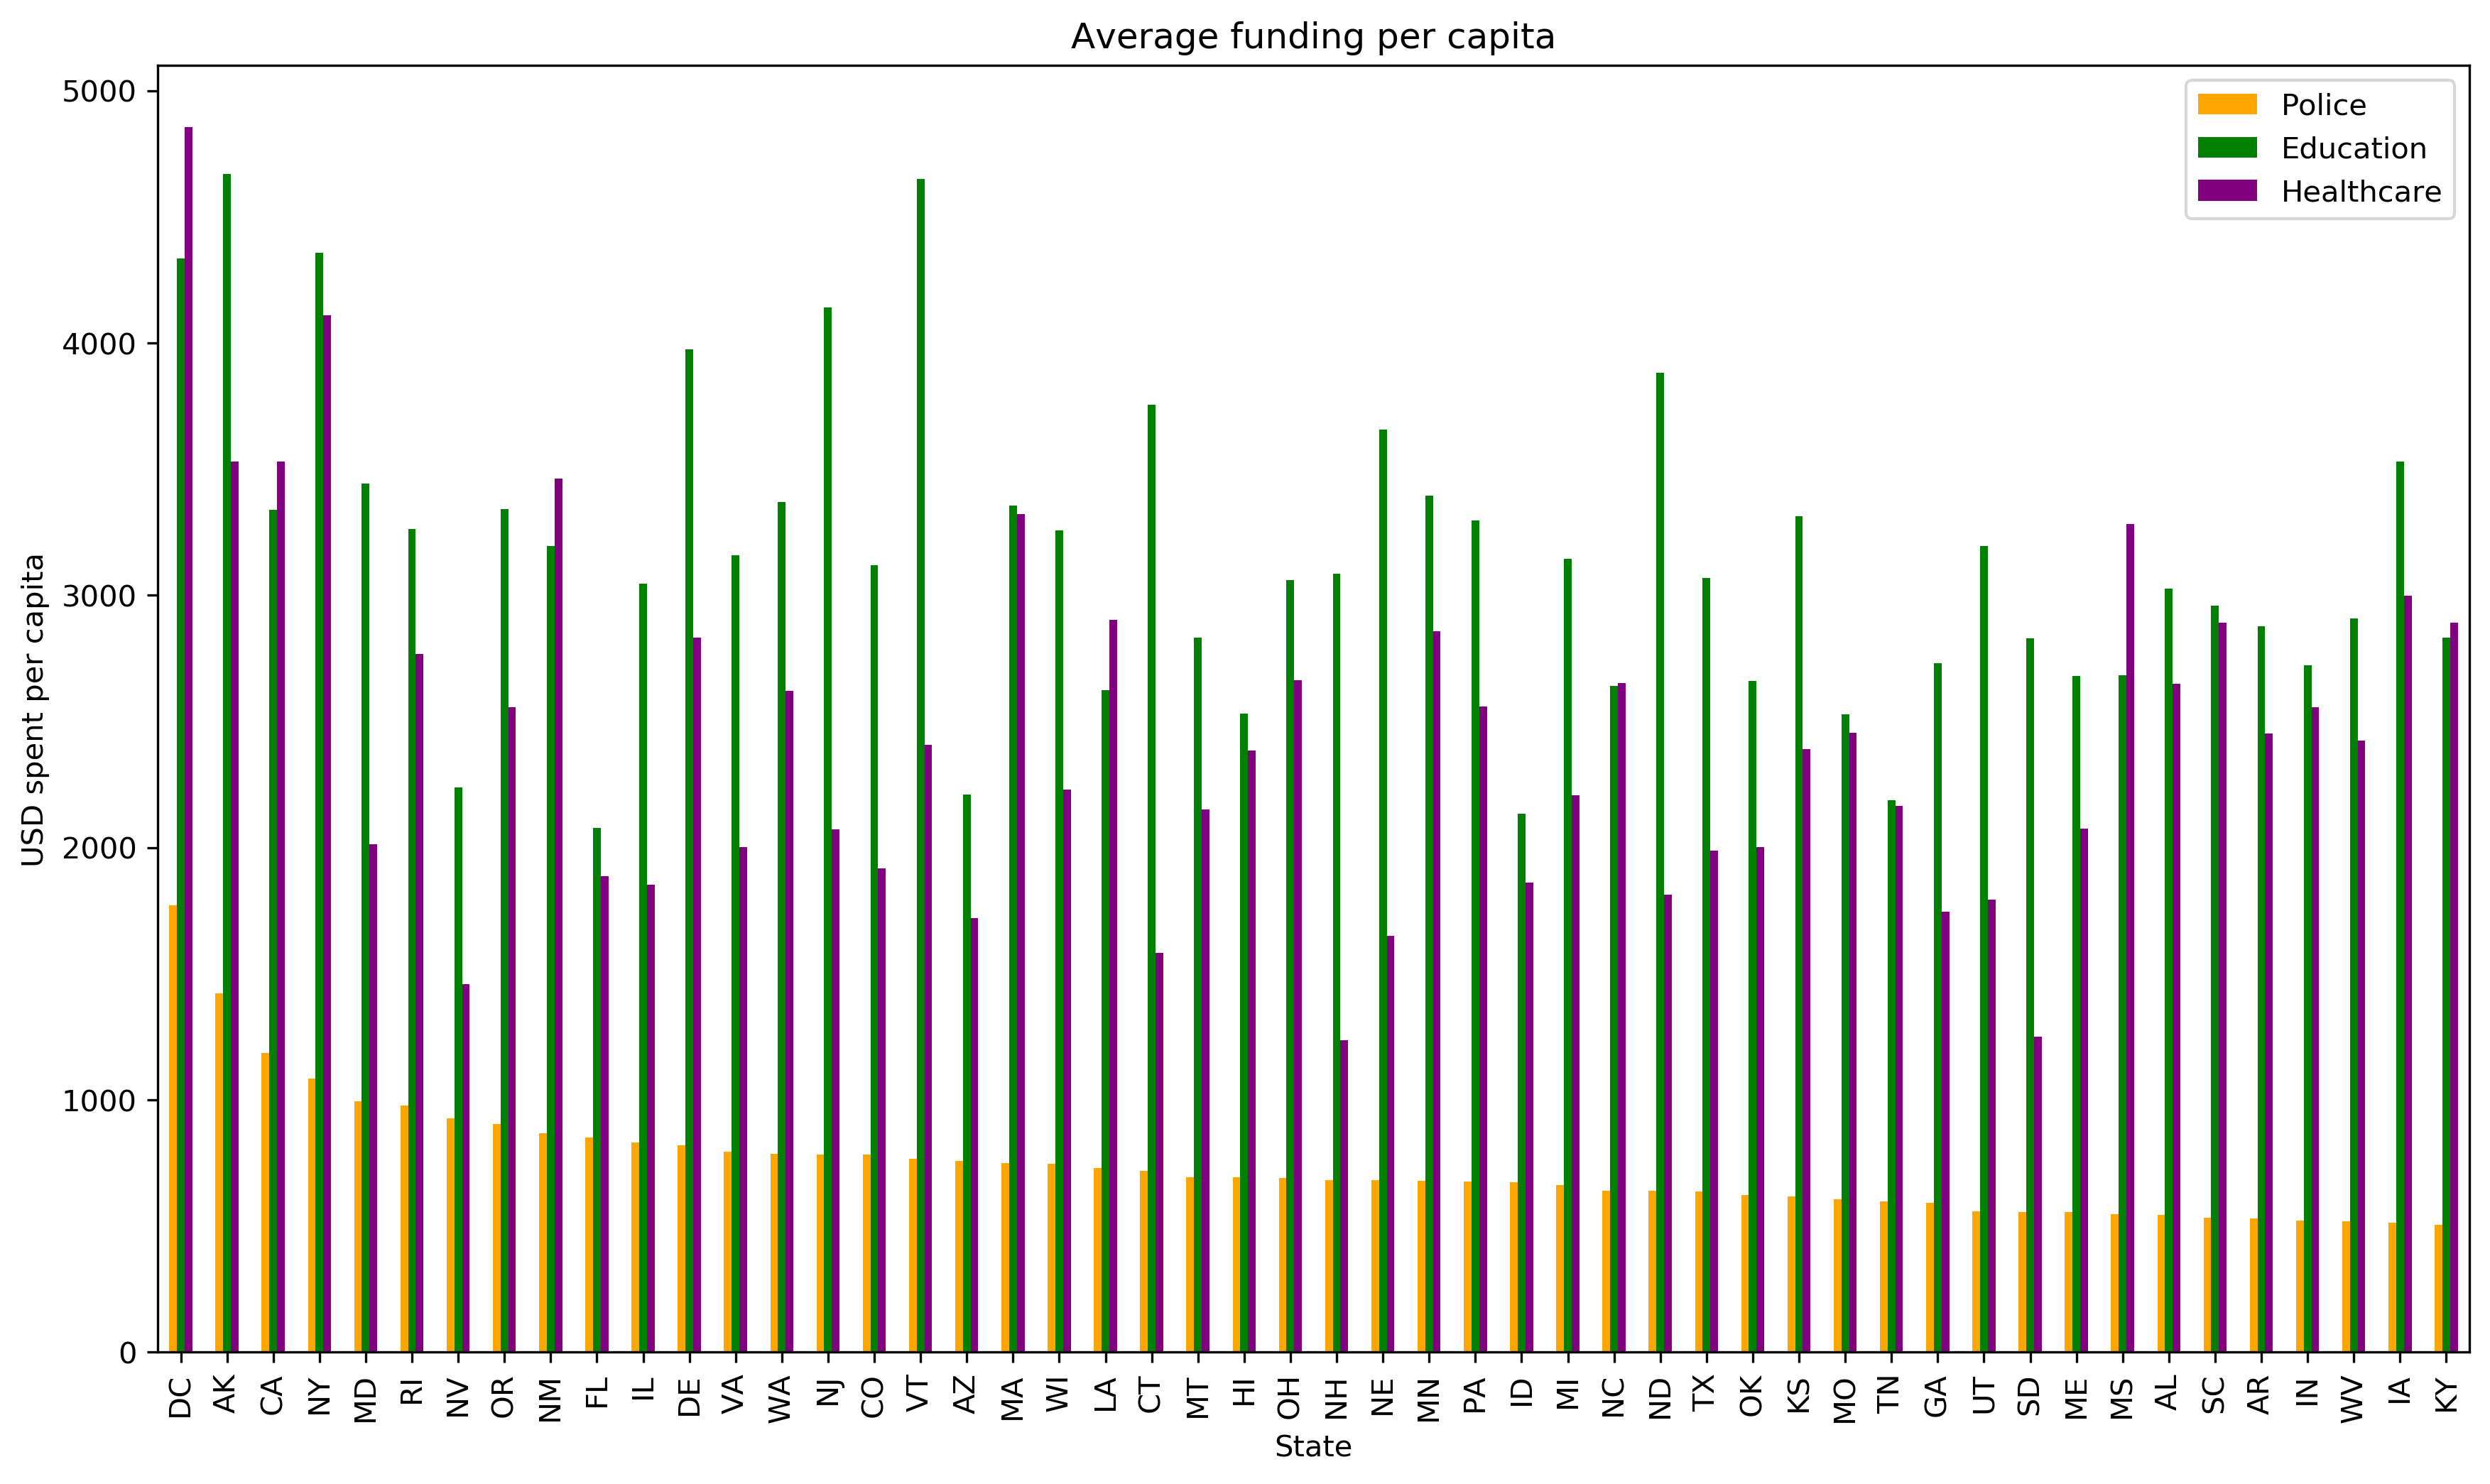

In [11]:
ax=main_df_sorted.plot.bar( rot=90, figsize=(14,8), title='Average funding per capita', color=["orange", "green", "purple"])
ax.set_ylabel("USD spent per capita")
ax.legend(["Police", "Education", "Healthcare"])
plt.savefig('./images/funding_sorted.jpg')

From this plot, it seems that both education and healthcare funding follows proportionately  police spending. To make sure our eyes are not lying to us, we can see the trends of these values, by building linear regression lines using this data. Remember: the data is sorted on police funding, so we want to compare that trend (which will necessairly be decreasing), to the trends of education and healthcare funding.

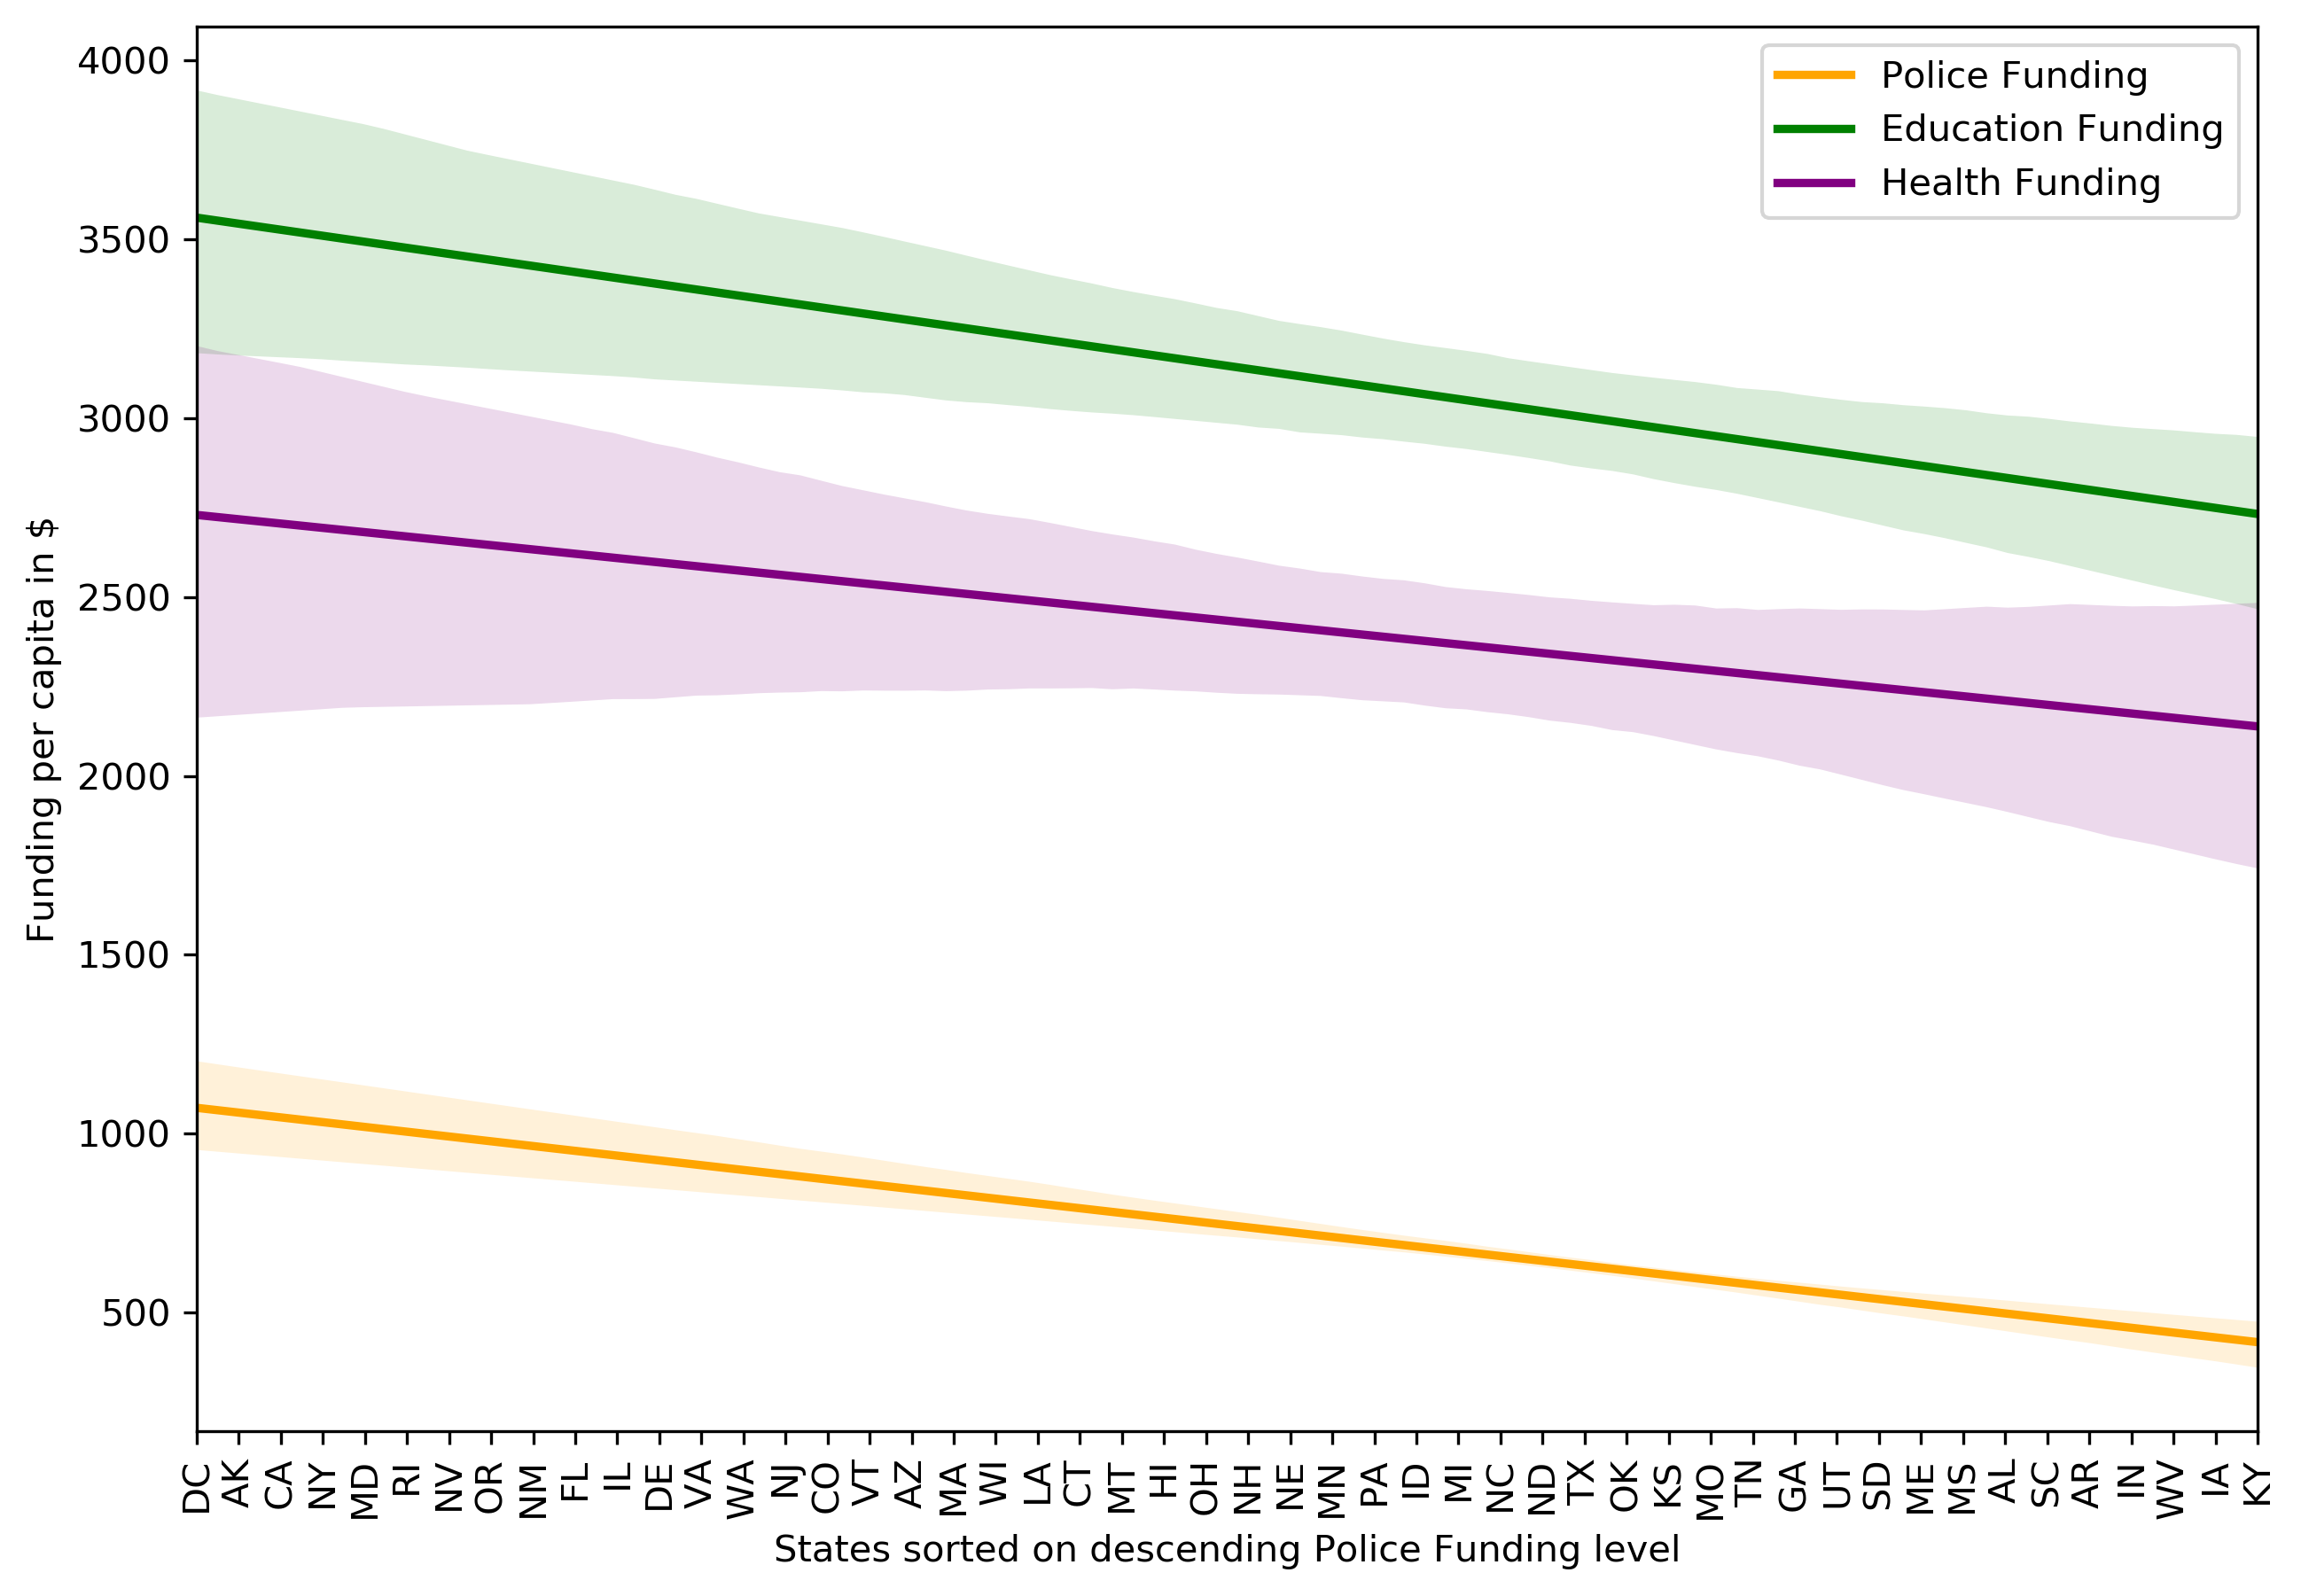

In [12]:
main_df_sorted = main_df_sorted.reset_index()
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

plt.xticks(np.arange(0, len(main_df)))
ax.set_xticklabels(main_df_sorted.State)

sns.regplot(x=main_df_sorted.index, y='mean_police', data= main_df_sorted,fit_reg=True,scatter=False, color='orange', label="Police Funding")
sns.regplot(x=main_df_sorted.index, y='mean_edu', data= main_df_sorted,fit_reg=True,scatter=False, color = 'green', label="Education Funding")
sns.regplot(x=main_df_sorted.index, y='mean_health', data= main_df_sorted,fit_reg=True,scatter=False, color = 'purple', label="Health Funding")


plt.xticks(rotation=90)
# fig.tight_layout()
ax.set_xlabel('States sorted on descending Police Funding level')
ax.set_ylabel('Funding per capita in $')
ax.legend()
plt.savefig('./images/funding_trends.jpg',bbox_inches='tight')
plt.show()

### Observations:

It seems it is indeed the case that both education and healthcare funding follow the same trend as police funding. What this means is that states do not sacriface on police funding to provide for healthcare/education, or the other way around. It means that states spend a proportinal amount of funding on these sectors. Richer states will spend more on all 3 comparef to poorer states, and education is the best funded of the 3, followed by healthcare.

## Get percentage of population by state

We want to include data on police killings in the US. But we want to make sure that we normalize this data. We are doing this because there are states such as California with 40M inhabitants, and we want to be able to compare the data with states with much smaller populations. To do this we are loading a dataset which includes the percentage of population per each state.  


Data downloaded from: https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population using https://wikitable2csv.ggor.de


In [13]:
population_pd = pd.read_csv('./datasets/popuations_by_state_wiki.csv')

In [14]:
population_pd.head()

Rank in states & territories, 2019  Rank in states & territories, 2010  \
0                                   1                                   1   
1                                   2                                   2   
2                                   3                                   4   
3                                   4                                   3   
4                                   5                                   6   

          State Population estimate, July 1, 2019[2]  \
0    California                           39,512,223   
1         Texas                           28,995,881   
2       Florida                           21,477,737   
3      New York                           19,453,561   
4  Pennsylvania                           12,801,989   

  Census population, April 1, 2010[3] Percent change, 2010–2019[note 1]  \
0                          37,254,523                              6.1%   
1                          25,145,561                             15.3%   
2                          18,801,310                             14.2%   
3                          19,378,102                              0.4%   
4                          12,702,379                              0.8%   

  Absolute change, 2010-2019  \
0                 +2,257,700   
1                 +3,850,320   
2                 +2,676,427   
3                    +75,459   
4                    +99,610   

  Total seats in the U.S. House of Representatives, 2013–2023  \
0                                                 53            
1                                                 36            
2                                                 27            
3                                                 27            
4                                                 18            

  Estimated population per electoral vote, 2019[note 2]  \
0                                            718,404      
1                                            763,050      
2                                            740,611      
3                                            670,812      
4                                            640,099      

  Estimated population per House seat, 2019  \
0                                   745,514   
1                                   805,441   
2                                   795,472   
3                                   720,502   
4                                   711,222   

  Census population per House seat, 2010  \
0                                702,885   
1                                698,503   
2                                696,468   
3                                717,707   
4                                705,715   

  Percent of the total U.S. population, 2018[note 3]  
0                                             11.96%  
1                                              8.68%  
2                                              6.44%  
3                                              5.91%  
4                                              3.87%

Filter out the columns we don't need

In [15]:
population_pd = population_pd[["State", "Percent of the total U.S. population, 2018[note 3]"]]
population_pd.columns=["State", "Percentage of total population"]

Replace the name of the state with the abbreviations we prepared eariler so we have homegeneous data.

In [16]:
population_pd["State"] = population_pd["State"].apply(lambda x: us_state_abbrev[x])

In [17]:
population_pd["Percentage of total population"] = population_pd["Percentage of total population"].apply(lambda x: float(x[:-1])/100)

In [18]:
population_pd.head()

State  Percentage of total population
0    CA                          0.1196
1    TX                          0.0868
2    FL                          0.0644
3    NY                          0.0591
4    PA                          0.0387

Finally save the data as a dictionary so that it is easy to access it.

In [19]:
#Save data as dictionary
population_dict = population_pd.set_index('State').to_dict()['Percentage of total population']

### Normalize for racial distribution in each state.

We also want to normalize the data by the percentage of the race distribution in each state. As we were doing before, we want to be able to compare states with each other in terms of killings for each of the major racial groups. But it is had to compare a state such as Marruland that has a 30% Black population, with Colorado, that has 4% Black population. For this reason we will normalize the data once again by using the percentage of population of each race as a weight and multiply the numbers of deaths per each race in each state with these values. 

Data from: https://www.governing.com/gov-data/census/state-minority-population-data-estimates.html

In [20]:
race_per_state_df = pd.read_excel('./datasets/race_distribution_per_state.xlsx')

In [21]:
race_per_state_df.head()

State  Hispanic (of any race)  Non-Hispanic White  Non-Hispanic Black  \
0     Alabama                   0.041               0.655               0.267   
1      Alaska                   0.070               0.606               0.029   
2     Arizona                   0.314               0.547               0.041   
3    Arkansas                   0.074               0.723               0.152   
4  California                   0.391               0.370               0.055   

   Non-Hispanic Asian  Non-Hispanic American Indian  
0               0.013                         0.005  
1               0.066                         0.142  
2               0.032                         0.039  
3               0.016                         0.006  
4               0.144                         0.004

In [22]:
race_per_state_df["Other"]=race_per_state_df["Non-Hispanic Asian"]+ race_per_state_df["Non-Hispanic American Indian"]

Let's keep only the 3 races we are interested in.

In [23]:
race_per_state_df.drop(columns=["Non-Hispanic Asian","Non-Hispanic American Indian" ], inplace=True)
race_per_state_df.columns=['State', 'Hispanic','White', 'Black', 'Other']

Once again replace the name of the states, with the abbreviations we have prepared

In [24]:
race_per_state_df.State = race_per_state_df.State.apply(lambda x: us_state_abbrev[x])

In [25]:
race_per_state_df.head()

State  Hispanic  White  Black  Other
0    AL     0.041  0.655  0.267  0.018
1    AK     0.070  0.606  0.029  0.208
2    AZ     0.314  0.547  0.041  0.071
3    AR     0.074  0.723  0.152  0.022
4    CA     0.391  0.370  0.055  0.148

We have finally prepared a fully normalized dataframe of the distribution of population in the US. We have normalized both the total population per state, as well as the racial distribution per state. This dataframe will be used below, combined with the police violence data.

## Load, clean and prepare the police killing data

In [26]:
killing_df = pd.read_excel('./datasets/MPVDatasetDownload.xlsx')

In [27]:
killing_df.head()

Victim's name Victim's age Victim's gender Victim's race  \
0       Pedro Martinez           66            Male      Hispanic   
1         James Horton           42            Male           NaN   
2  Dustin James Acosta           28            Male         White   
3          Javon Brice           39            Male           NaN   
4      Joshua D. Evans           32            Male           NaN   

  URL of image of victim Date of Incident (month/day/year)  \
0                    NaN                        2020-11-18   
1                    NaN                        2020-11-17   
2                    NaN                        2020-11-17   
3                    NaN                        2020-11-17   
4                    NaN                        2020-11-16   

  Street Address of Incident           City State  Zipcode  ...  \
0                        NaN         Tyler     TX      NaN  ...   
1                        NaN    Hart County    KY      NaN  ...   
2                        NaN  St. Augustine    FL      NaN  ...   
3                        NaN      La Vergne    TN      NaN  ...   
4                        NaN     Batesville    IN      NaN  ...   

  Unarmed/Did Not Have an Actual Weapon  \
0                       Allegedly Armed   
1                       Allegedly Armed   
2                       Allegedly Armed   
3                       Allegedly Armed   
4                       Allegedly Armed   

  Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)  \
0                                     unknown weapon                                
1                                                gun                                
2                                                gun                                
3                                                gun                                
4                                                gun                                

  Alleged Threat Level (Source: WaPo) Fleeing (Source: WaPo)  \
0                               other            not fleeing   
1                              attack                  other   
2                              attack                    NaN   
3                              attack                    car   
4                              attack            not fleeing   

  Body Camera (Source: WaPo) WaPo ID (If included in WaPo database)  \
0                         no                                 6321.0   
1                         no                                 6322.0   
2                         No                                 6320.0   
3                         no                                 6319.0   
4                         no                                 6314.0   

  Off-Duty Killing?  \
0               NaN   
1               NaN   
2               NaN   
3               NaN   
4               NaN   

  Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )  \
0                                                NaN                                                                                                                           
1                                                NaN                                                                                                                           
2                                                NaN                                                                                                                           
3                                                NaN                                                                                                                           
4                                                NaN                                                                                                                           

  MPV ID Fatal Encounters ID  
0    NaN 

Keep only the columns we are interested in

In [28]:
killing_df = killing_df[["Victim's race", "State", "Date of Incident (month/day/year)"]]
killing_df.columns=["Race", "State", "Date"]

killing_df = killing_df.dropna()

killing_df["Date"] = pd.to_datetime(killing_df["Date"]).apply(lambda x: x.year)

Let's filter out all the races we are not interested in

In [29]:
def other_race(race):
    if(race not in ["White", "Black", "Hispanic"]):
        return "Other"
    return race

In [30]:
killing_df.Race = killing_df.Race.apply(lambda x: other_race(x))

In [31]:
killing_df.Race.value_counts()

White       3769
Black       2158
Hispanic    1482
Other       1208
Name: Race, dtype: int64

In [32]:
killing_df.head()

Race State  Date
0  Hispanic    TX  2020
2     White    FL  2020
7     White    NH  2020
8  Hispanic    CA  2020
9     Other    TX  2020

Great! Now let's compute the averege number of police killings for each race and each state, for the last 8 years.

In [33]:
killings_per_state =killing_df.groupby(by=[ 'State', 'Race']).size()/(2020-2013+1) #GET AVG killings through the years
killings_per_state = killings_per_state.to_frame()
killings_per_state.reset_index(inplace=True)
killings_per_state.set_index('State', inplace=True)
killings_per_state.columns = ['Race', 'Deaths']
killings_per_state.reset_index(inplace=True)

In [34]:
killings_per_state.head()


State      Race  Deaths
0    AK     Black   0.500
1    AK  Hispanic   0.125
2    AK     Other   2.500
3    AK     White   2.875
4    AL     Black   7.250

Let's pivot the table so that we have the races as columns. This way it will be easier to plot the data later.

In [35]:
killings_per_state_non_normalized = pd.pivot_table(killings_per_state, index="State",columns=['Race'])
killings_per_state_non_normalized = killings_per_state_non_normalized.fillna(0) #Fill data about missing races

killings_per_state_non_normalized.columns = killings_per_state_non_normalized.columns.droplevel()
killings_per_state_non_normalized=killings_per_state_non_normalized.drop(columns=["Other"])
killings_per_state_non_normalized.head()

Race    Black  Hispanic   White
State                          
AK      0.500     0.125   2.875
AL      7.250     0.125  10.250
AR      4.375     0.375   8.375
AZ      4.125    16.750  19.125
CA     25.375    66.875  45.875

Great! Now it's a good idea to define a helper method that will be used to create the plots. 

In [36]:
def plot_killings_per_state_stacked(df):
    '''
    Create a stacked bar plot per each race in the dataframe. 
    Every bar represents th number of police killings in that state.
    '''
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)

    width = 0.35  

    ax.bar(df.index, df["Black"].to_list(), width, label='Black', color='black')
    ax.bar(df.index, df["White"].to_list(), width, bottom=df["Black"].to_list(),
           label='White', color='blue')
    ax.bar(df.index, df["Hispanic"].to_list(), width, bottom=df["White"]+df["Black"],
           label='Hispanic', color='red')


    plt.xlabel("State")
    plt.ylabel("Killing coefficient")
    plt.xticks(rotation=90)
    ax.legend()

    return plt

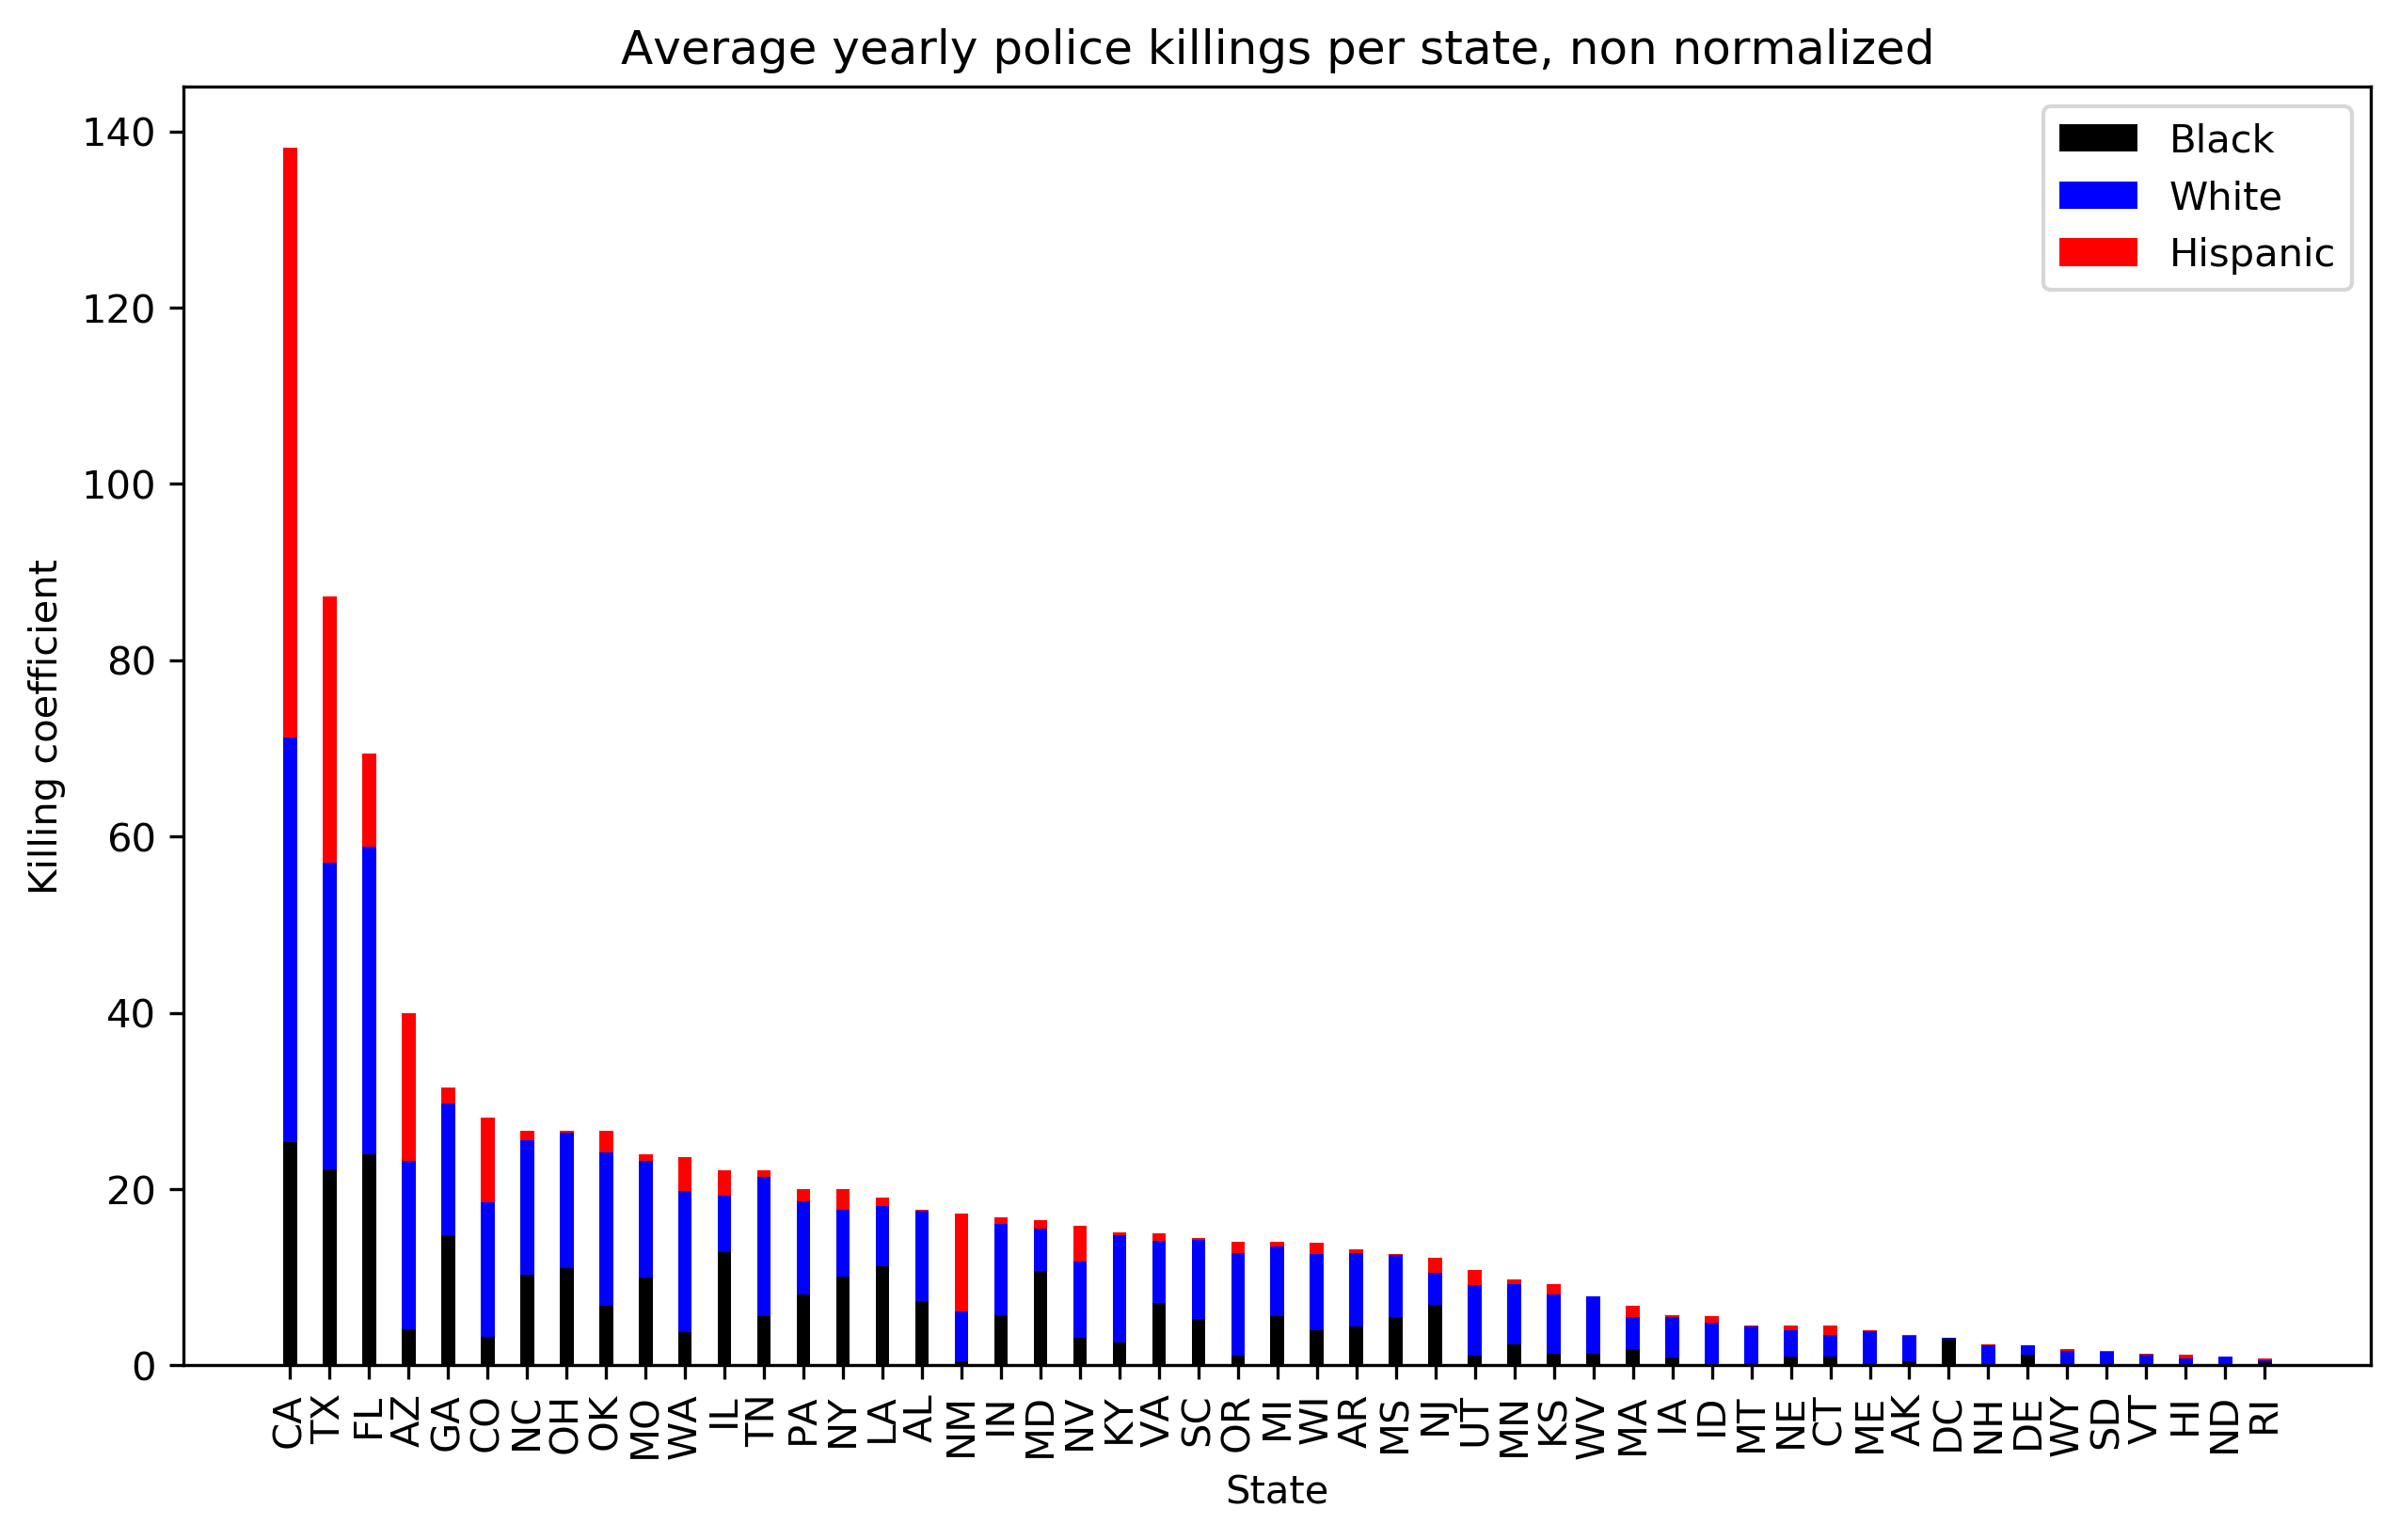

In [37]:

most_killings_sorted_index_non_normalized = killings_per_state_non_normalized.sum(axis=1).sort_values(ascending=False).index.to_list()
killings_per_state_non_normalized = killings_per_state_non_normalized.reindex(most_killings_sorted_index_non_normalized)

plt_non_normalized = plot_killings_per_state_stacked(killings_per_state_non_normalized)
plt_non_normalized.title("Average yearly police killings per state, non normalized")
plt_non_normalized.savefig('./images/killings_non_normalized.jpg')
plt_non_normalized.show()

Now that we have the average police killings per state and race, we can apply the two normalization factors we have prepared.

Let's start by normalizing by the density of the population of each state compared to the population in the US.

In [38]:
#Normalize deaths by state population
killings_per_state["Deaths"] = killings_per_state.apply(lambda x: x.Deaths * population_dict[x.State], axis=1)

In [39]:
killings_per_state.head()

State      Race    Deaths
0    AK     Black  0.001100
1    AK  Hispanic  0.000275
2    AK     Other  0.005500
3    AK     White  0.006325
4    AL     Black  0.107300

Let's sort by number of deaths and plot the data.

In [40]:
killings_per_state_normalized_population = pd.pivot_table(killings_per_state, index="State",columns=['Race'])
killings_per_state_normalized_population = killings_per_state_normalized_population.fillna(0) #Fill data about missing races

killings_per_state_normalized_population.columns = killings_per_state_normalized_population.columns.droplevel()

In [41]:
killings_per_state_normalized_population.head()

Race      Black  Hispanic    Other     White
State                                       
AK     0.001100  0.000275  0.00550  0.006325
AL     0.107300  0.001850  0.02405  0.151700
AR     0.039813  0.003413  0.01365  0.076213
AZ     0.089513  0.363475  0.17360  0.415013
CA     3.034850  7.998250  3.31890  5.486650

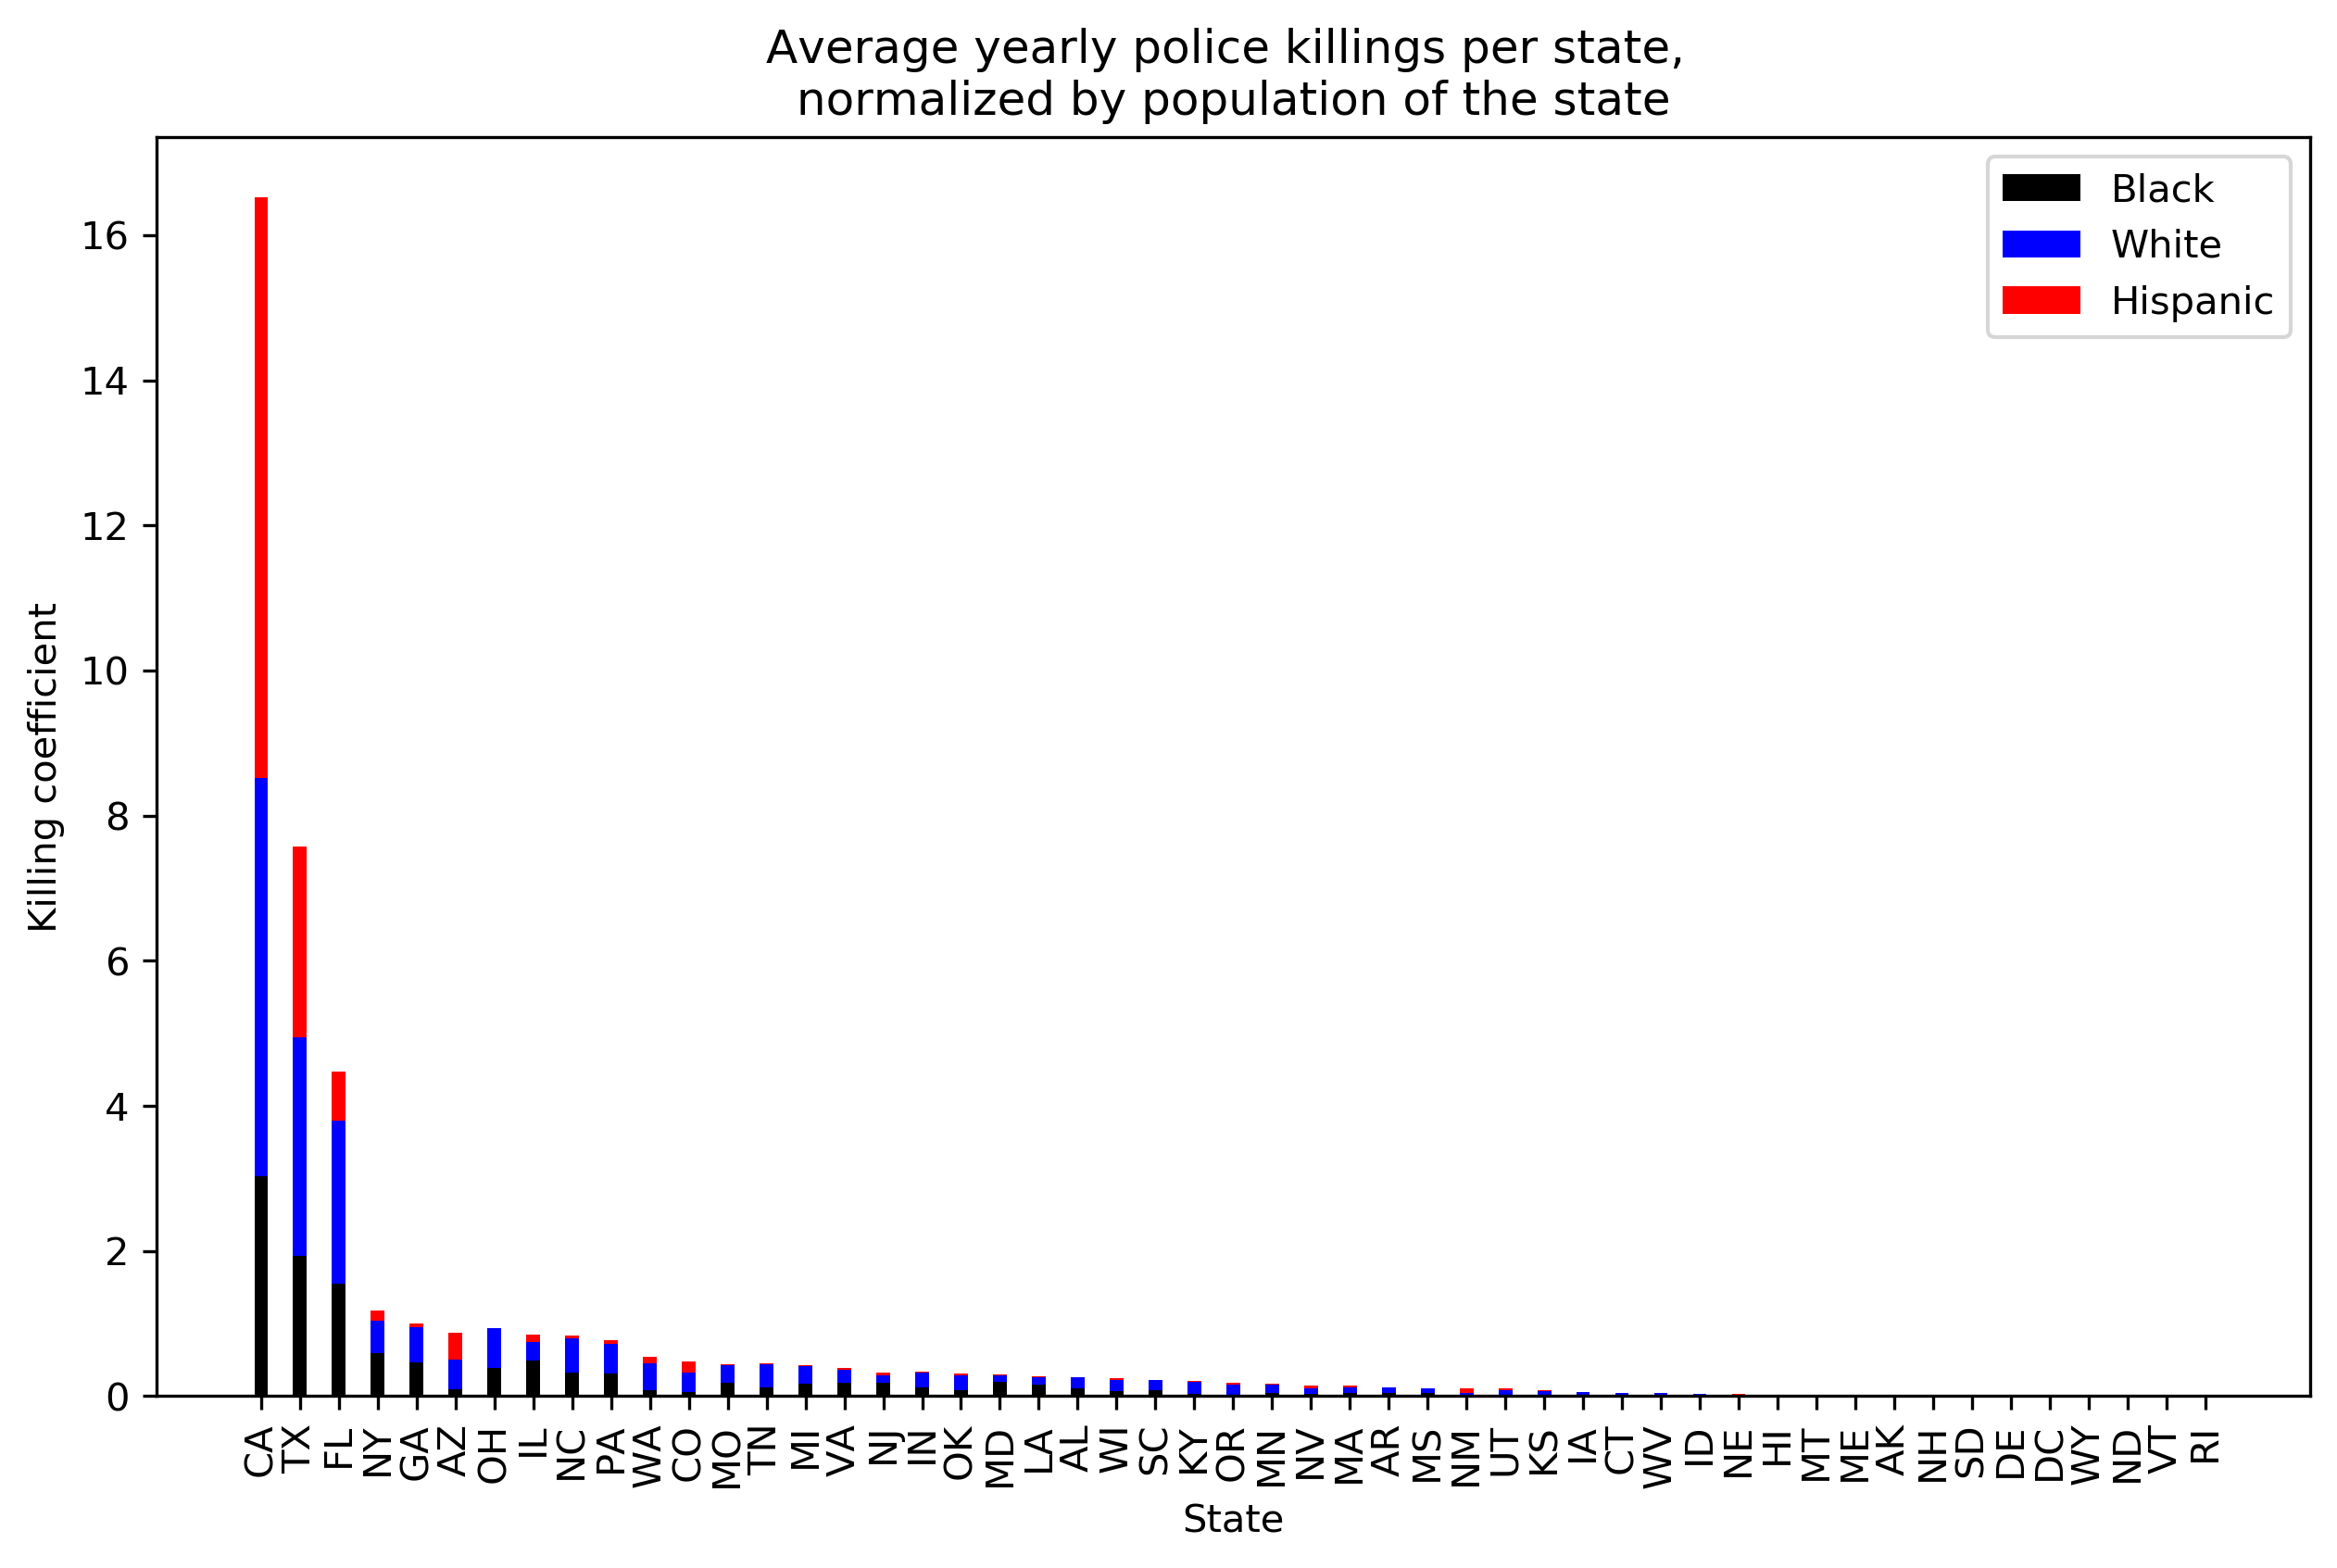

In [42]:
most_killings_sorted_index_population = killings_per_state_normalized_population.sum(axis=1).sort_values(ascending=False).index.to_list()
killings_per_state_normalized_population = killings_per_state_normalized_population.reindex(most_killings_sorted_index_population)

plt_plopulation_normalized = plot_killings_per_state_stacked(killings_per_state_normalized_population)

plt_plopulation_normalized.title("Average yearly police killings per state, \nnormalized by population of the state")
plt_plopulation_normalized.savefig('./images/killings_population_normalized.jpg')
plt_plopulation_normalized.show()

Now let's apply the second normalization factor. For each state, we will normalize the police killings proportionately to the racial distribution of that state. Let's define a helper function that does just that.

In [43]:
def normalize_per_race_density(row):
    '''
    Multiply the killing values of each race, whith the corresponding normalization factor of that state and race
    '''


    row.Black = row.Black * race_per_state_df[race_per_state_df["State"]==row.name]["Black"]
    row.White = row.White * race_per_state_df[race_per_state_df["State"]==row.name]["White"]
    row.Hispanic = row.Hispanic * race_per_state_df[race_per_state_df["State"]==row.name]["Hispanic"]
    row.Other = row.Other * race_per_state_df[race_per_state_df["State"]==row.name]["Other"]
  
    return row

In [44]:
killings_per_state_normalized_population_race = killings_per_state_normalized_population.apply(lambda x: normalize_per_race_density(x), axis=1)

In [45]:
killings_per_state_normalized_population_race.head()

Race      Black  Hispanic     Other     White
State                                        
CA     0.166917  3.127316  0.491197  2.030061
TX     0.227893  1.034526  0.052015  1.263830
FL     0.238022  0.173107  0.017629  1.208321
NY     0.085569  0.026950  0.009862  0.244231
GA     0.145875  0.005342  0.008149  0.250902

***Finally, we have obtained a truly normalized dataframe of police killings in the US*** 

Let's plot one last time to see the diffrence from before

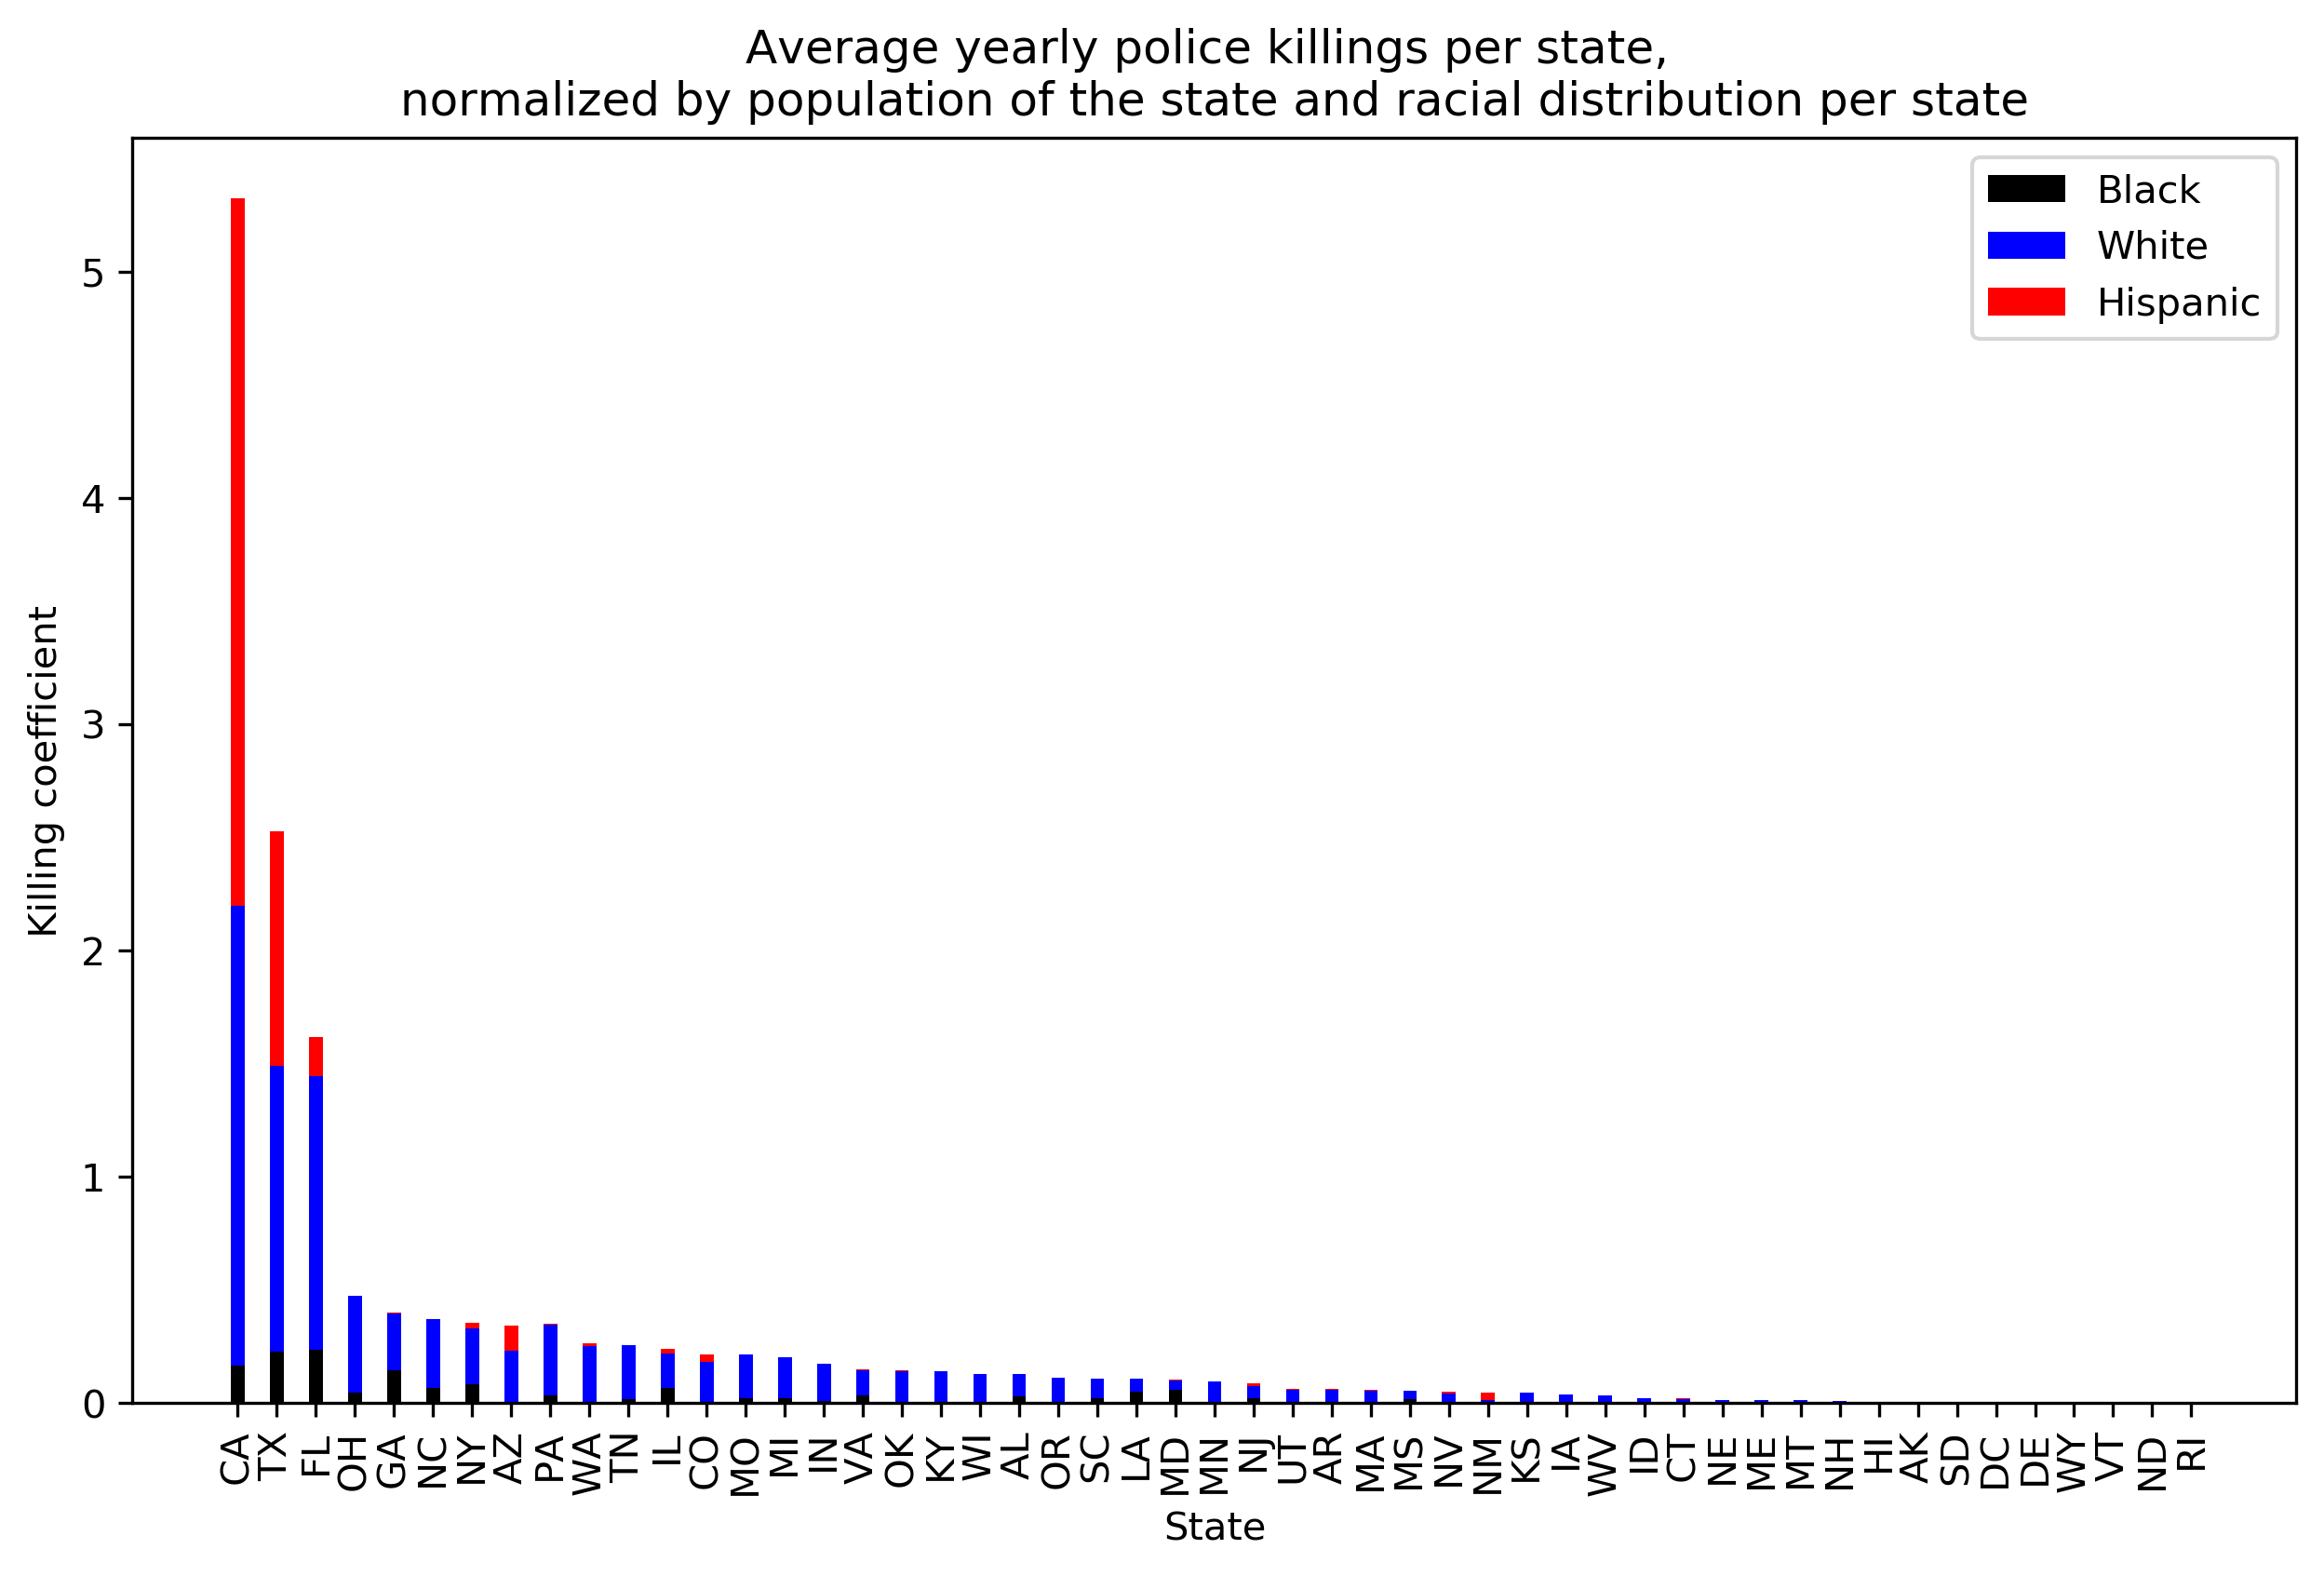

In [46]:
most_killings_sorted_index = killings_per_state_normalized_population_race.sum(axis=1).sort_values(ascending=False).index.to_list()
killings_per_state_normalized_population_race = killings_per_state_normalized_population_race.reindex(most_killings_sorted_index)

plt_plopulation_race_normalized = plot_killings_per_state_stacked(killings_per_state_normalized_population_race)

plt_plopulation_race_normalized.title("Average yearly police killings per state, \nnormalized by population of the state and racial distribution per state")
plt_plopulation_race_normalized.savefig('./images/killings_population_race_normalized.jpg')
plt_plopulation_race_normalized.show()

### Great! Now that we finally have all the information we need neatly cleaned and prepared, we can start combining the different datasets and see what results we get.

In [47]:
main_df.head()

mean_police   mean_edu  mean_health
State                                     
AL        545.4375  3026.6875    2648.4250
AK       1423.0625  4669.4625    3528.7125
AZ        757.7875  2209.9375    1721.4500
AR        529.2500  2877.7125    2451.8375
CA       1185.1375  3338.5500    3530.4750

In [48]:
killings_per_state_normalized_population_race.head()

Race      Black  Hispanic     Other     White
State                                        
CA     0.166917  3.127316  0.491197  2.030061
TX     0.227893  1.034526  0.052015  1.263830
FL     0.238022  0.173107  0.017629  1.208321
OH     0.047373  0.000327  0.001800  0.428220
GA     0.145875  0.005342  0.008149  0.250902

Let's first create an index sorted on police funding.

In [49]:
police_funding_sorted_index = main_df.sort_values(by='mean_police', ascending=False).index.to_list()

In [50]:
#Sort the killing data on the new index
killings_per_state_normalized_most_killings = killings_per_state_normalized_population_race.reset_index()

In [51]:
killings_per_state_normalized_most_killings.head()

Race State     Black  Hispanic     Other     White
0       CA  0.166917  3.127316  0.491197  2.030061
1       TX  0.227893  1.034526  0.052015  1.263830
2       FL  0.238022  0.173107  0.017629  1.208321
3       OH  0.047373  0.000327  0.001800  0.428220
4       GA  0.145875  0.005342  0.008149  0.250902

In [52]:
#Also sort the funding dataset on the same index
main_df_most_killings = main_df.reindex(most_killings_sorted_index)
main_df_most_killings = main_df_most_killings.reset_index()

In [53]:
main_df_most_police_funding = main_df.reindex(police_funding_sorted_index)
killings_per_state_normalized_most_police_funding = killings_per_state_normalized_population_race.reindex(police_funding_sorted_index)

main_df_most_police_funding = main_df_most_police_funding.reset_index()
killings_per_state_normalized_most_police_funding = killings_per_state_normalized_most_police_funding.reset_index()

Let's write a heloing function that will be used for ploting the data we prepared.

In [60]:
def plot_killing_funding(killings, spendings, onlyBlack=False, size =10):
    '''
    Plot a vertical bar plot containing both data on killing and on funding, using two separate axes.
    '''

    fig, ax = plt.subplots()

    ax2=ax.twiny()
    if(onlyBlack==True):
        ax2.set_xscale('log')
    fig.set_size_inches(10, size)
    
    ax2.grid(not onlyBlack, which="both")
    
    width = 0.4   
    ax2.barh(2*killings.index-0.4, killings["Black"].to_list(), width, label='Black', color='black')
    if(onlyBlack==False):
        ax2.barh(2*killings.index-0.4, killings["White"].to_list(), width, left=killings["Black"].to_list(),
               label='White', color='blue')
        ax2.barh(2*killings.index-0.4, killings["Hispanic"].to_list(), width, left=killings["White"]+killings["Black"],
               label='Hispanic', color='red')

    
    ax.barh(2*spendings.index, spendings.mean_police, width, label="Police funding", color='orange')
    if(onlyBlack==False):
        ax.barh(2*spendings.index+0.4, spendings.mean_edu, width, label="Education funding", color='green')
        ax.barh(2*spendings.index+0.8, spendings.mean_health, width, label="Health funding", color='purple')


    plt.yticks(np.arange(0, len(killings)*2, 2.0)[::-1])
    plt.yticks(rotation=90)
    ax2.set_yticklabels(spendings.State[::-1])
    if(onlyBlack==False):
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.94))
        ax.legend(loc='lower right')

    ax2.set_xlabel('Normalized killings per race',fontsize=13)
    ax.set_xlabel('Funding in USD per capita',fontsize=13)
    plt.gca().invert_yaxis()
 

    return fig, plt

Let's first visualize the top 20 states per killing numbers, alongside government funding for each state. We want to see if there is any relation of these values.

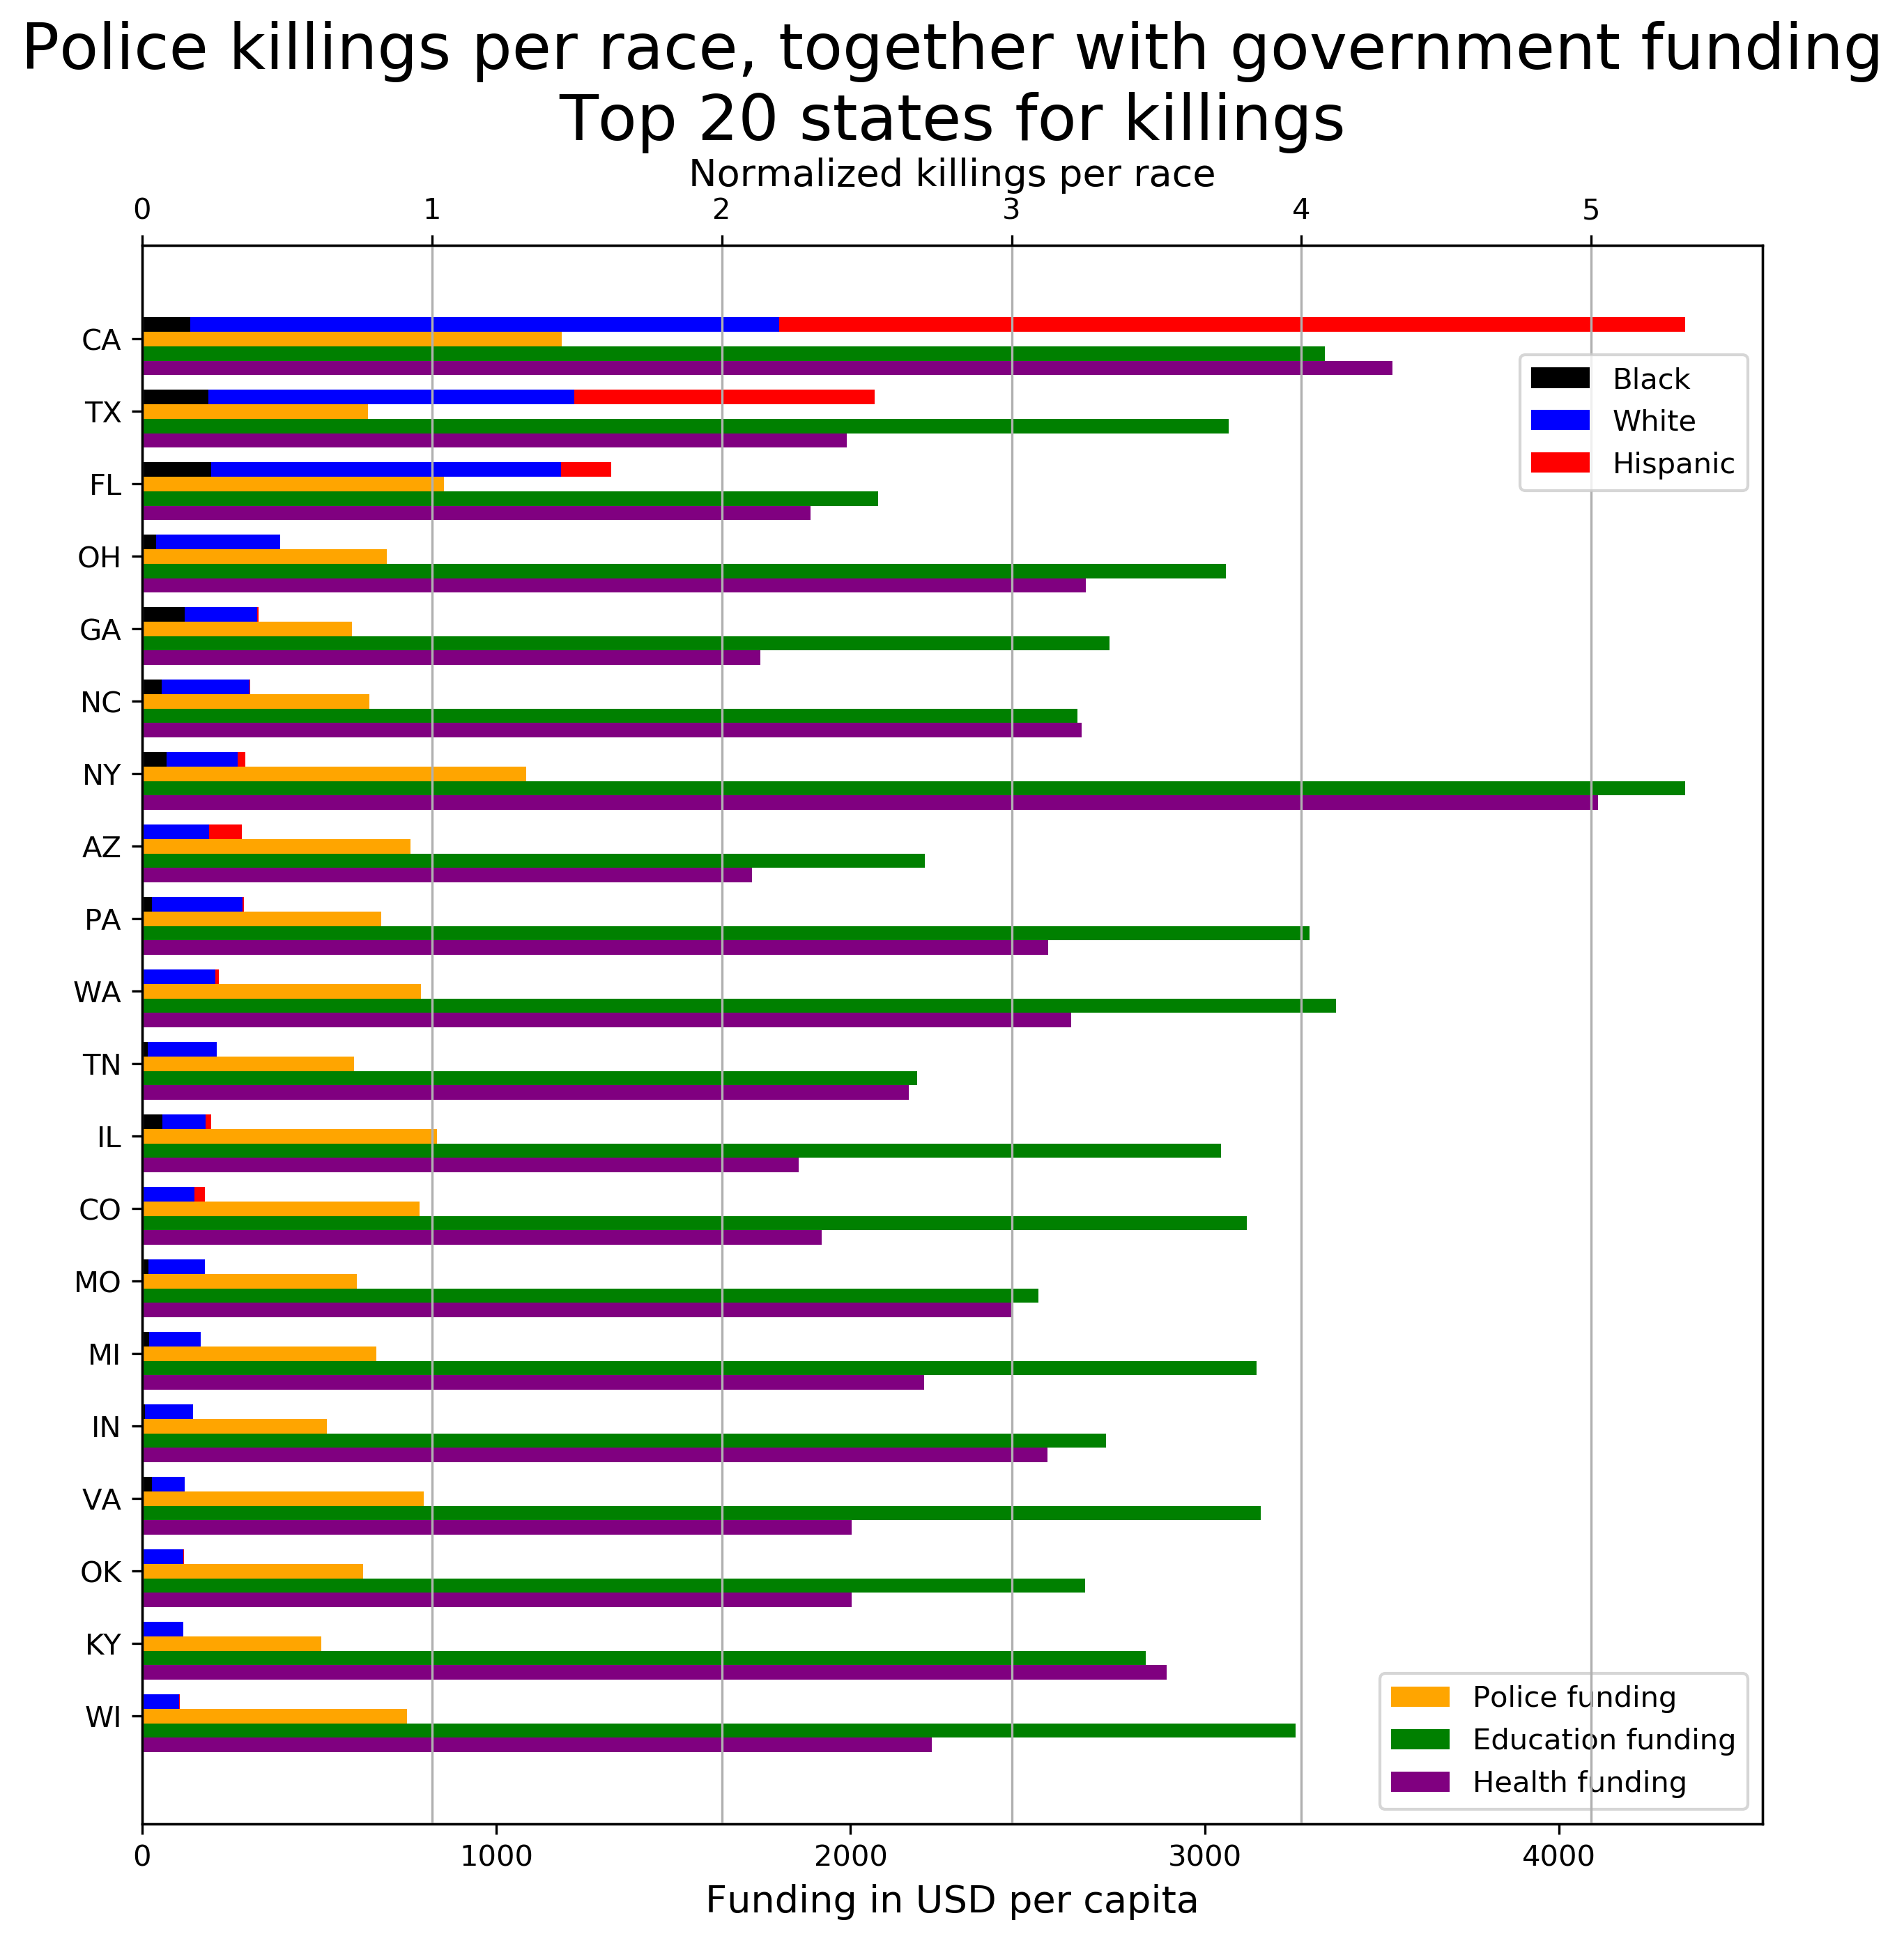

In [55]:
fig_most_killings,plt_most_killings = plot_killing_funding(killings_per_state_normalized_most_killings[:20], main_df_most_killings[:20],False)
plt_most_killings.title('Police killings per race, together with government funding\nTop 20 states for killings',fontsize=22)
plt_most_killings.savefig('./images/top20killing_funding.jpg')
plt_most_killings.show()

By looking at this plot, it's hard to conclude if there is any relation on the two factors. There are states like California,that have the highest normalized number of killings, and a high budget for the police. But right next to it we see Texas, with a big drop in police funding. Same thing goes for the rest of the states included here.

We might be better off if we show the data sorted on police funding, since there is a very high variation on the killing numbers. This time let's focus only on the black race, since we are interested in comparing our results with the BLM movement requests.

We are plotting both ends of the spectrum this time, so the top 10 states per police funding, alongside the bottom 10. This way it might be easier to spot any major relations

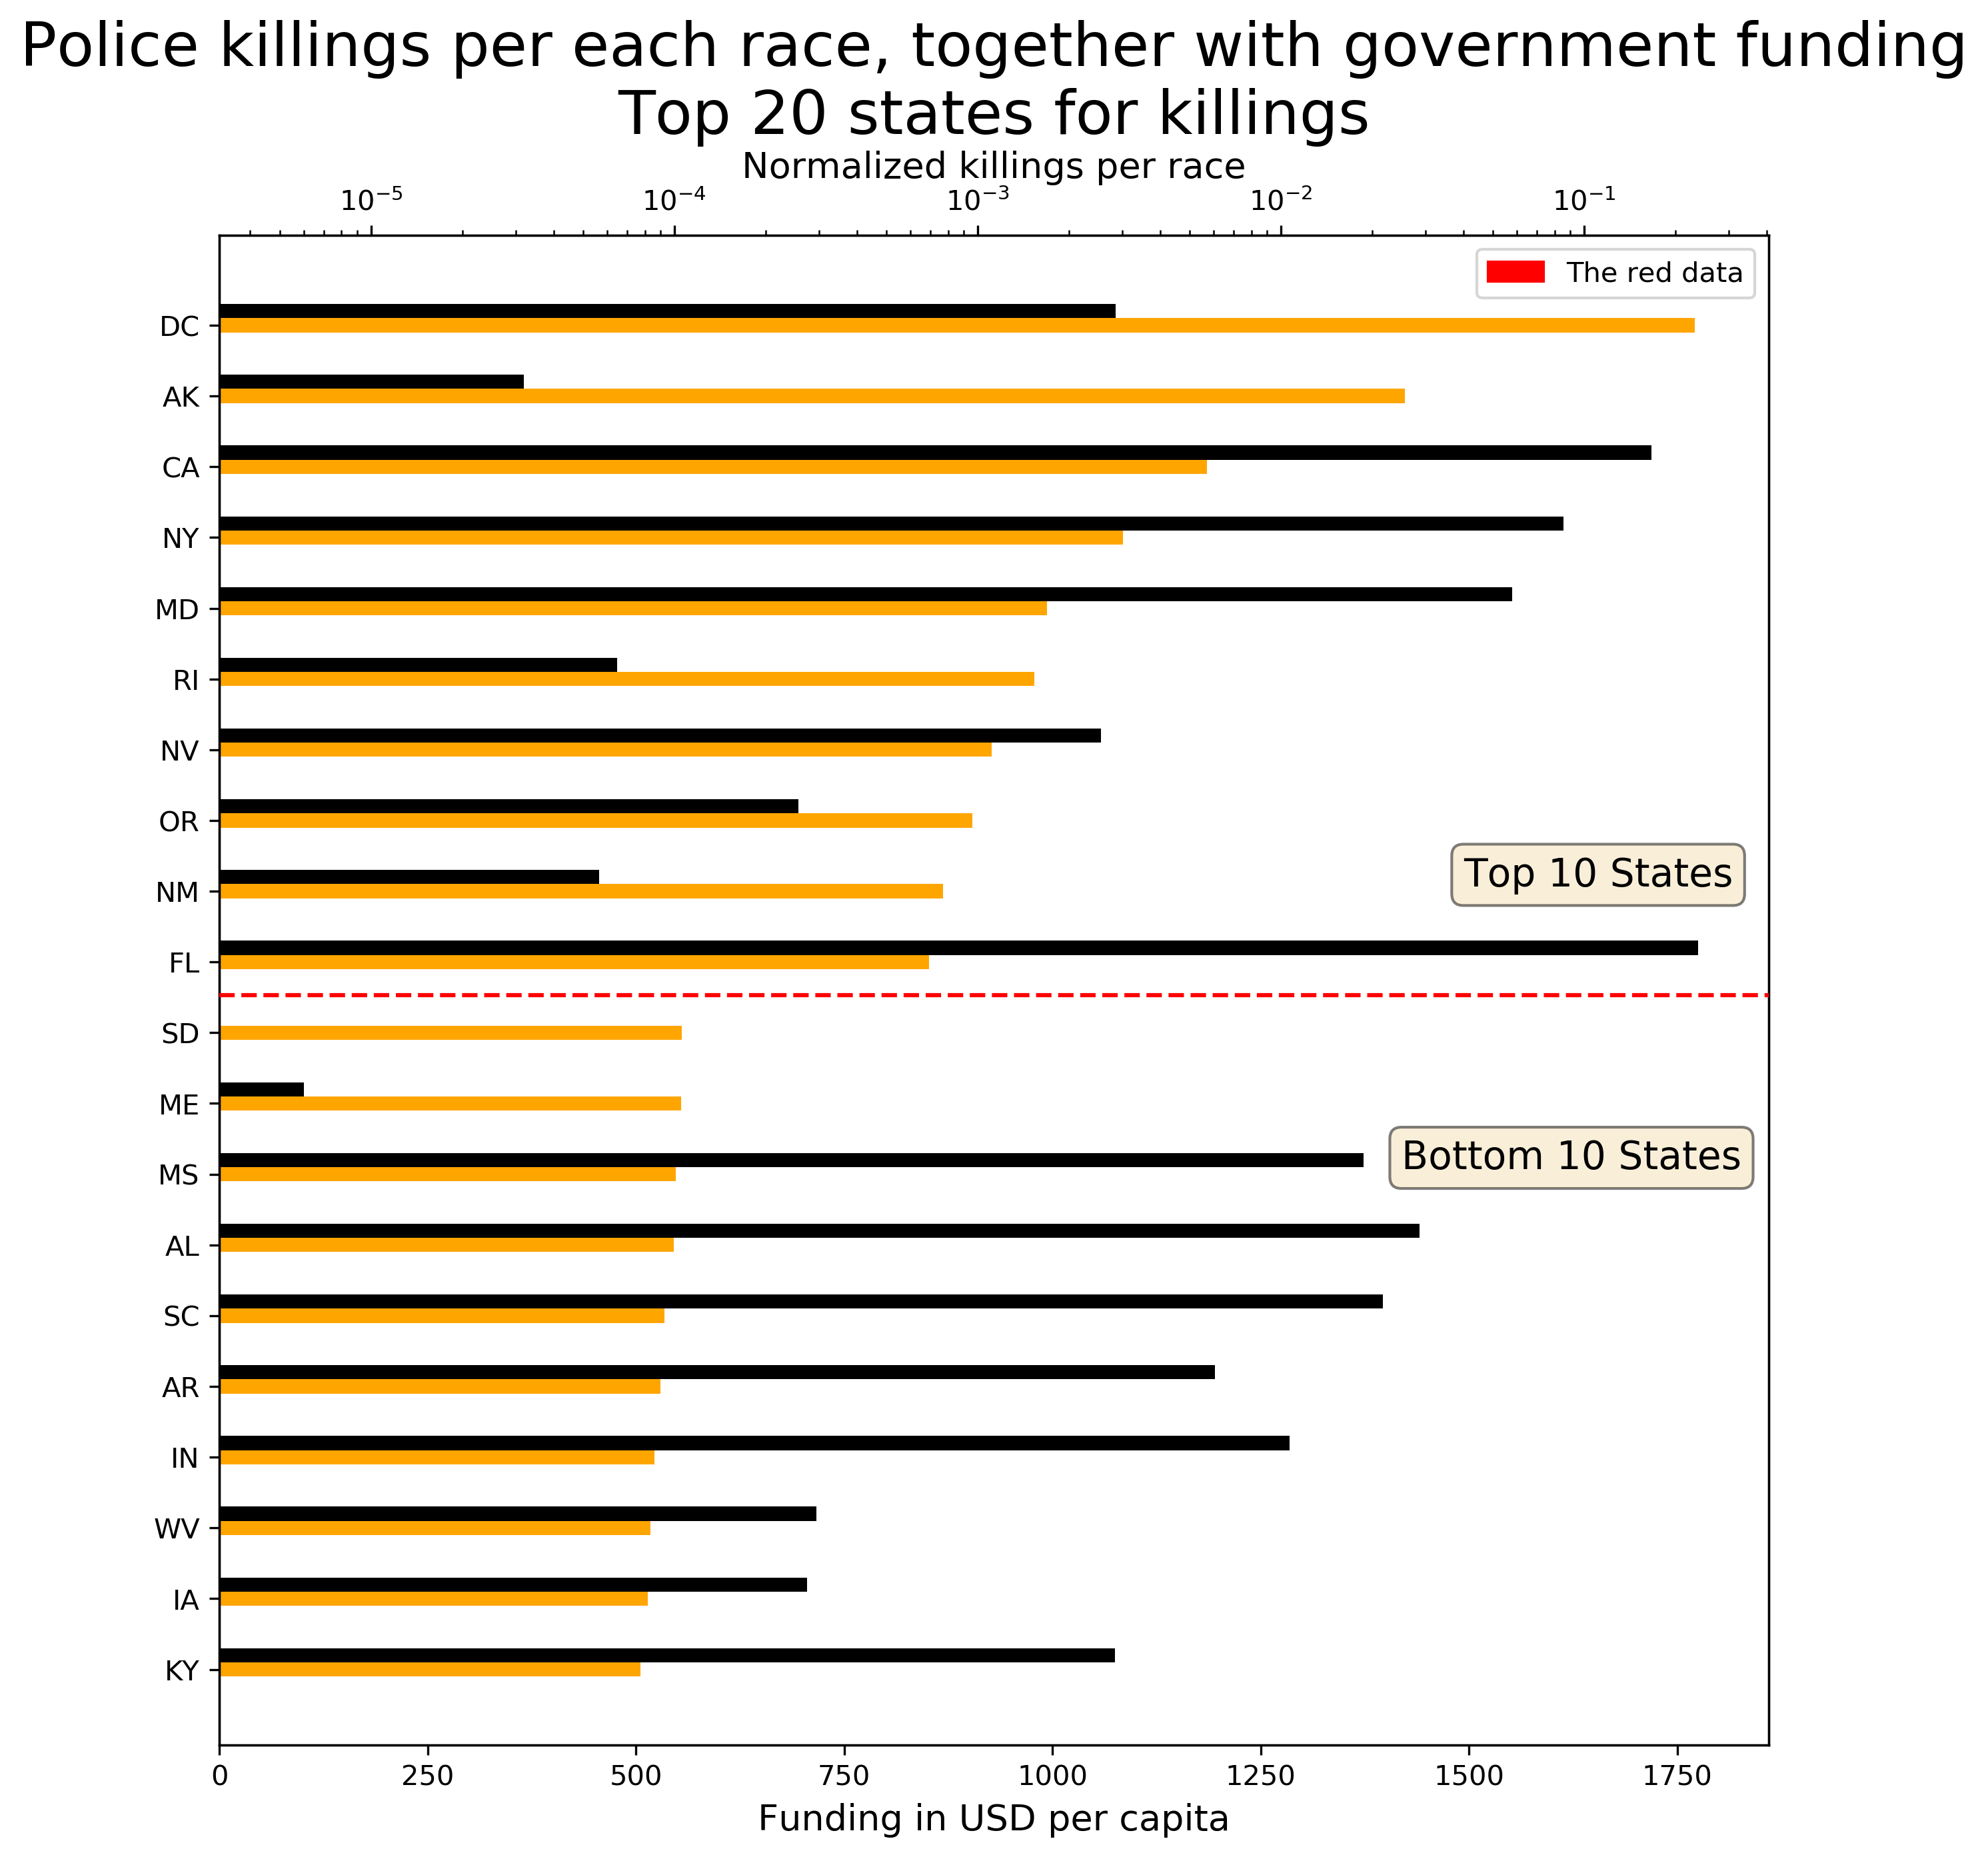

In [61]:
import matplotlib.patches as mpatches
fig_black_killing_funding, plt_black_killing_funding = plot_killing_funding(killings_per_state_normalized_most_police_funding[:10].append(killings_per_state_normalized_most_police_funding[-10:]).reset_index(), main_df_most_police_funding[:10].append( main_df_most_police_funding[-10:]).reset_index(), True)

#Draw horizontal line
fig_black_killing_funding.add_artist(lines.Line2D([0.125, 0.9], [0.5, 0.5], color= 'red', linestyle='--'))

plt_black_killing_funding.text(0.04, 15, 'Top 10 States', fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt_black_killing_funding.text(0.025, 23, 'Bottom 10 States', fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt_black_killing_funding.title('Police killings per each race, together with government funding\nTop 20 states for killings',fontsize=22)

red_patch = mpatches.Patch(color='yellow', label='Police fundi')
plt_black_killing_funding.legend(handles=[red_patch])

plt_black_killing_funding.savefig('./images/top_bottom10_black_killing_funding.jpg')
plt_black_killing_funding.show()

### Observations:

We decided to use a logarithmic axis ***for the number of killings only***, since there were some very big differences in numbers along the states, and this way it's easier to compare them.

We can notice, that indeed there seems to be a visible decrease in the number of killings from the top states for police funding, to the bottom ones. So the requests of the BLM movement seem to be well funded. 

Note however that this is not the case for all states. In the top 10, we have states like Arkansas, Rhode Island and New Mexico, that have very low number of police killings for the black population. And remember that the number of killings is normalized. But we also have states like California and Florida, that have some of the highest values of police killings. 

So ultimately, police funding seems to be related to the number of killings, but it's not very obvious to see this. 

On the other hand, higher funding for healthcare and Education, don't seem to necessarily  make a huge difference on the number of killing.